# Projet 3 OpenFoodFacts - Notebook d'analyse des données


Lien vers les consignes du projet sur openclassrooms : https://openclassrooms.com/fr/projects/628/assignment

Lien vers la définition des variables : https://world.openfoodfacts.org/data/data-fields.txt

# Sommaire :

**Partie 1**

 - <a href="#C1">1 - Partie 1</a>
     - <a href="#C11">1.1 - Installation </a>
     - <a href="#C12">1.2 - Imports </a>     
     - <a href="#C13">1.3 - Définition des fonctions</a>
     - <a href="#C14">1.4 - Chargement des données</a>     
     - <a href="#C15">1.5 - Correction des types</a>  
<!--      - <a href="#C16">1.6 - Fichier EdStatsFootNote.csv</a>   -->
 
**Partie 2**

 - <a href="#C2">2 - QUESTION 2 </a>  
     - <a href="#C21">2.1 - Analyse Univariée</a>     
     - <a href="#C22">2.2 - Répartition des Nutriscores</a>
     - <a href="#C23">2.3 - Évolution des additifs</a>
         
**Partie 3**         
 - <a href="#C3">3 - Question 3</a>
     - <a href="#C31">3.1 - Analyse Bivariée et multivarié</a> 
         - <a href="#C311">3.1.1 - Matrice de corrélation</a>
         - <a href="#C313">3.1.3 - Test du Chi 2 - Indépendance des variables</a>
         - <a href="#C314">3.1.4 - Test ANOVA (Analyse de la variance) -  Indépendance des variables</a>
            - <a href="#CA">A : Test du Chi 2 - Indépendance des variables</a> 
            - <a href="#CB">B : Test de normalité Kolmogorov Smirnov/a> 
            - <a href="#CC">C : ANOVA : analyse de la variance</a> 
         - <a href="#C315">3.1.5 - Test de student d'indépendance</a>
         - <a href="#C316">3.1.6 - Marques et nutriscore</a>    
         - <a href="#C317">3.1.7 - Corrélation de pearson</a>   
         - <a href="#C318">3.1.8 - Coefficient des composantes principales </a>       
         - <a href="#C319">3.1.9 - Rapport de variance expliquée  </a> 
         - <a href="#C3110">3.1.10 - Cerdle de corrélation  </a> 
    


# <a name="C1">1 - Partie 1 </a> 

## <a name="C11">1.1 - Installation </a> 

In [198]:
!pip install missingno
!pip install mlxtend
!pip install ppscore
!pip install --upgrade statsmodels
!pip install fuzzywuzzy


Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


- missingno : cette bibliothèque fournit des outils pour visualiser les données manquantes dans un ensemble de données. Elle est utile pour identifier rapidement les valeurs manquantes et les tendances des données. Elle peut être utilisée en conjonction avec d'autres bibliothèques d'analyse de données telles que pandas et matplotlib.

- mlxtend : cette bibliothèque est un ensemble d'outils pour l'analyse de données et l'apprentissage automatique. Elle fournit des algorithmes d'apprentissage automatique, des outils pour l'évaluation et la sélection de modèles, et des méthodes de prétraitement des données telles que le codage en une chaîne binaire.

- ppscore : cette bibliothèque fournit une mesure de la corrélation entre les variables appelée "Predictive Power Score" (PPS), qui peut être utilisée pour identifier les variables les plus importantes dans un ensemble de données pour la prédiction. La PPS est une mesure plus complète que la corrélation de Pearson, car elle peut identifier des relations non linéaires et non monotones entre les variables.

## <a name="C12">1.2 - Imports </a> 

In [240]:
# Importation des bibliothèques nécessaires
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns
import re
import missingno as msno
import matplotlib.dates as mdates
import os
from sklearn.decomposition import PCA
# Importation de la classe KMeans à partir de la bibliothèque scikit-learn
from sklearn.cluster import KMeans
from scipy.stats import trim_mean
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.stattools import adfuller

import ppscore as pps
import warnings
warnings.filterwarnings('ignore')

from matplotlib.colors import ListedColormap

from scipy.stats import f_oneway, kruskal, rankdata
from sklearn.linear_model import LinearRegression

# POUR RECALCULER LA PCA AVEC MLXTEND
from mlxtend.plotting import plot_pca_correlation_graph
from scipy.stats import pearsonr, spearmanr, kendalltau

# Affichage des graphiques dans le notebook
%matplotlib inline


In [241]:
#Modification des affichages de colonnes, lignes et largeurs de colonnes pour avoir un maximum d'information
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_colwidth', -1)

## <a name="C13">1.3 - Définition des fonctions </a> 

In [242]:
# Printing total nb and percentage of null

def print_null_pct(df):
    tot_null = df.isna().sum().sum()
    print('nb of null: ', tot_null, '\npct of null: ',
        '{:.1f}'.format(tot_null*100/(df.shape[0]*df.shape[1])))

In [243]:
# Définition d'une fonction pour tracer une heatmap
# paramètres :
# corr : matrice de corrélation
# title : titre du graphe
# figsize : taille de la figure
# vmin : valeur minimale de la colormap
# vmax : valeur maximale de la colormap
# center : valeur centrale de la colormap
# palette : palette de couleurs
# shape : forme de la heatmap (rectangle ou triangle)
# fmt : format des nombres affichés
# robust : booléen pour utiliser une méthode de calcul robuste ou non
def plot_heatmap(corr, title, figsize=(8,4), vmin=-1, vmax=1, center=0,
                 palette = sns.color_palette("coolwarm", 20), shape='rect',
                 fmt='.2f', robust=False):
    
    # Création d'une figure et d'un axe
    fig, ax = plt.subplots(figsize=figsize)
    
    # Définition du masque pour la forme de la heatmap
    if shape == 'rect':
        mask=None
    elif shape == 'tri':
        mask = np.zeros_like(corr, dtype=np.bool)
        mask[np.triu_indices_from(mask)] = True
    else:
        print('ERROR : this type of heatmap does not exist')

    # Définition de la palette de couleurs
    palette = palette
    
    # Tracé de la heatmap
    ax = sns.heatmap(corr, mask=mask, cmap=palette, vmin=vmin, vmax=vmax,
                     center=center, annot=True, annot_kws={"size": 10},fmt=fmt,
                     square=False, linewidths=.5, linecolor = 'white',
                     cbar_kws={"shrink": .9, 'label': None}, robust = robust,
                     xticklabels= corr.columns, yticklabels = corr.index)
    
    # Configuration des axes et de la légende
    ax.tick_params(labelsize=8,top=False, bottom=True,
                labeltop=False, labelbottom=True)
    ax.collections[0].colorbar.ax.tick_params(labelsize=8)
    plt.setp(ax.get_xticklabels(), rotation=25, ha="right",rotation_mode="anchor")
    ax.set_title(title, fontweight='bold', fontsize=14)
    
    # Retourne le masque (inutilisé dans ce code)
    # return mask


In [244]:
from scipy.stats import trim_mean
from statsmodels.tsa.stattools import adfuller, kpss
import numpy as np

def stationary_tests(data, print_opt=True, trim_prop=0.9):
    # Suppression des valeurs manquantes et NaN
    data_m = data.dropna().values.astype(float)
#     data_m = data_m[~np.isnan(data_m)]
    data_m = data_m[~np.isnan(data_m)].astype(float)

    # Troncature des valeurs extrêmes
    trim_value = int(len(data_m) * trim_prop)
    data_m = trim_mean(data_m, trim_value)
    
    # apply KPSS test on residuals
    stat, p, lags, crit = kpss(data_m, nlags='auto')
    result = adfuller(data_m)

    if print_opt:
        # H0: series is not trend-stationary.
        print('--- Kwiatkowski---') 
        print('stat=%.3f, p=%.3f' % (stat, p))
        # not rejected -> series is not trend-stationary.
        print('prob. not trend-stationary') if p > 0.05\
             else print('prob. trend-stationary') # rejected -> trend-stationary
        
        # H0: there is a unit root i.e. series is non-stationary
        print('--- Aug. Dickey-Fuller ---\n stat.: %f' % result[0]) 
        print('p-value: %f' % result[1])
        # not rejected -> series is non-stationary
        print('prob. not stationary\n') if result[1] > 0.05\
                    else print('prob. stationary\n' )# rejected -> stationary
    # True : stationary/trend-stationary
    return {'Kwiatkowski': (round(p,4), str(p <= 0.05)),
            'Aug. Dickey-Fuller': (round(result[1],4), str(result[1] <= 0.05))}


# # Function applying stationary tests to data and returning if stat. or not

# def stationary_tests(data, print_opt=True):

#     data_m = np.array(data[~np.isnan(data)])
#     stat, p, lags, crit = kpss(data_m, nlags='auto')
#     result = adfuller(data_m)

#     if print_opt:

#         # : H0 : series is not trend-stationary.
#         print('--- Kwiatkowski---') 
#         print('stat=%.3f, p=%.3f' % (stat, p))
#         # not rejected -> series is not trend-stationary.
#         print('prob. not trend-stationary') if p > 0.05\
#              else print('prob. trend-stationary') # rejected -> trend-stationary
        
#         # H0 there is a unit root i.e. series is non-stationary
#         print('--- Aug. Dickey-Fuller ---\n stat.: %f' % result[0]) 
#         print('p-value: %f' % result[1])
#         # not rejected -> series is non-stationary
#         print('prob. not stationary\n') if result[1] > 0.05\
#                     else print('prob. stationary\n' )# rejected -> stationary
#     # True : stationnary/trend-stationnary
#     return {'Kwiatkowski': (round(p,4), str(p <= 0.05)),
#             'Aug. Dickey-Fuller': (round(result[1],4), str(result[1] <= 0.05))}



# def stationary_tests(data, print_opt=True, trim_prop=0.3):
# #     # On enlève les valeurs manquantes et on met les données dans un array numpy
# #     data_m = data.fillna(df.mean())

#     # Suppression des valeurs manquantes et NaN
    
#     data_m = data.dropna().values.astype(float)
#     data_m = data_m[~np.isnan(data_m)]

# #     data_m = data_m.dropna().values
# #     data_m = np.array(data_m[~np.isnan(data_m)])
#     data_m = data_m[~np.isnan(data_m)]
  
#     # Troncature des valeurs extrêmes
#     trim_value = int(len(data_m) * trim_prop)
#     data_m = trim_mean(data_m, trim_value)
    
#     # apply KPSS test on residuals
# #     resids = data_m - np.mean(data_m)
#     data_m = data_m[~np.isnan(data_m)]
    
#     stat, p, lags, crit = kpss(data_m, nlags='auto')
#     result = adfuller(data_m)

#     if print_opt:
#         # H0: series is not trend-stationary.
#         print('--- Kwiatkowski---') 
#         print('stat=%.3f, p=%.3f' % (stat, p))
#         # not rejected -> series is not trend-stationary.
#         print('prob. not trend-stationary') if p > 0.05\
#              else print('prob. trend-stationary') # rejected -> trend-stationary
        
#         # H0: there is a unit root i.e. series is non-stationary
#         print('--- Aug. Dickey-Fuller ---\n stat.: %f' % result[0]) 
#         print('p-value: %f' % result[1])
#         # not rejected -> series is non-stationary
#         print('prob. not stationary\n') if result[1] > 0.05\
#                     else print('prob. stationary\n' )# rejected -> stationary
#     # True : stationary/trend-stationary
#     return {'Kwiatkowski': (round(p,4), str(p <= 0.05)),
#             'Aug. Dickey-Fuller': (round(result[1],4), str(result[1] <= 0.05))}


In [245]:
# Plotting ANOVA and Kruskall-Wallis H test and return if same dist. or not

def id_cat_distrib_tests(data_df, Q_col, C_col, print_opt=True):

    gb = data_df.groupby(C_col)[Q_col]
    cat = list(gb.groups.keys())
    cat_series = [gr.dropna().values for n, gr in gb]

    if print_opt: print('oooooooo- {} vs. {} -oooooooo'.format(Q_col, C_col))

    # Analysis of Variance Test
    stat1, p1 = f_oneway(*cat_series)
    if print_opt:
        print('---ANOVA---')
        print('stat=%.3f, p=%.10f' % (stat1, p1))
        print('Prob. same distr') if p1 > 0.05 else print('Prob. different distr')
    # Kruskal-Wallis H Test
    stat2, p2 = kruskal(*cat_series)
    if print_opt:
        print('---Kruskal-Wallis---')
        print('stat={:.3f}, p={:.10f}'.format(stat2, p2))
        print('Prob. same distr') if p2 > 0.05 else print('Prob. different distr')
        
    return {'ANOVA': (round(p1,4), str(p1 > 0.05)),
            'Kruskal-Wallis': (round(p2,4), str(p2 > 0.05))}

 # - > at least one of the groups has a significantly different mean from the others.

In [246]:
def mult_test(data_df, test_func, print_opt=True, res_df=pd.DataFrame(), **kwargs):
    res_df_mod = res_df.copy('deep')
    
    data_df = pd.DataFrame(data_df).dropna()
    print(res_df_mod)
    for c in data_df.select_dtypes(include=np.number).columns:
        if print_opt: print('oooo--'+c+'--oooo')
        if test_func == 'stat':
            dic_stat = stationary_tests(data_df[c], print_opt=print_opt)
        elif test_func == 'id_dist':
            dic_stat = id_cat_distrib_tests(data_df, C_col=kwargs['C_col'],
                                            Q_col=c, print_opt=print_opt)
        else:
            print('ERROR: this function does not exist')
        for s in dic_stat.keys():
            res_df_mod.loc[s, c] = str(dic_stat.get(s))

    return res_df_mod


In [247]:
def mult_test(data_df, test_func, print_opt=True, res_df=pd.DataFrame(), **kwargs):
    res_df_mod = res_df.copy('deep')
    
    data_df = pd.DataFrame(data_df).dropna()
    print(res_df_mod)
    for c in data_df.select_dtypes(include=np.number).columns:
        if print_opt: print('oooo--'+c+'--oooo')
        if test_func == 'stat':
            dic_stat = stationary_tests(data_df[c], print_opt=print_opt)
        elif test_func == 'id_dist':
            dic_stat = id_cat_distrib_tests(data_df, C_col=kwargs['C_col'],
                                            Q_col=c, print_opt=print_opt)
        else:
            print('ERROR: this function does not exist')
        for s in dic_stat.keys():
            if np.var(data_df[c]) > 1e-10:  # Vérification de la variance des échantillons
                res_df_mod.loc[s, c] = str(dic_stat.get(s))
            else:
                res_df_mod.loc[s, c] = 'Insufficient variation'

    return res_df_mod


In [248]:
# # Plotting proportion of categories among newly entered products and returning
# # the dataframe of aggregated data for each categories

# def plot_cat_prop_thr_time(col, palette='dark', ncol=3):
#     print(df)
#     df_fx = df.copy()
#     if 'last_modified_t' in df_fx.columns:
#         print("la colonne existe ")
#     print("les colonnes df ")    
#     print(df_fx.columns)    
#     df_fx['last_modified_t'] = pd.to_datetime(df['last_modified_t'])   
#     df_fx.set_index('last_modified_t', inplace=True)
#     df_fx.index = pd.to_datetime(df_fx.index, unit='s')
#     print(df_fx)
# #     if 'last_modified_t' in df_f.columns:
# #     # Vérifier si "last_modified_t" a besoin d'être converti en datetime index
# #         if not pd.api.types.is_datetime64_any_dtype(df_f['last_modified_t']):
# #             df_f['last_modified_t'] = pd.to_datetime(df_f['last_modified_t'], unit='s')

# #         # Vérifier si la colonne "last_modified_t" est l'index du dataframe
# #         if 'last_modified_t' not in df.index.names:
# #             df.set_index('last_modified_t', inplace=True)
# #         else:
    
# #     # Vérifier si "last_modified_t" existe dans le dataframe
# #     if 'last_modified_t' in df_f.columns:
# #         # Vérifier si "last_modified_t" a besoin d'être converti en datetime index
# #         if not pd.api.types.is_datetime64_any_dtype(df_f['last_modified_t']):
# #             df_f['last_modified_t'] = pd.to_datetime(df_f['last_modified_t'], unit='s')

# #         # Vérifier si la colonne "last_modified_t" est l'index du dataframe
# #         if 'last_modified_t' not in df.index.names:
# #             df_f.set_index('last_modified_t', inplace=True)
            
# #     df_100g_thr_time = df.set_index('last_modified_t').sort_index()[col_100g]
# #     df_100g_thr_time.index = pd.to_datetime(df_100g_thr_time.index, unit='s')

# #     # Convert "last_modified_t" to datetime index
# #     df_f['last_modified_t'] = pd.to_datetime(df['last_modified_t'], unit='s')
# #     df_f.set_index('last_modified_t', inplace=True)

#     fig = plt.figure(figsize=(10,5))
#     gb = df_fx.groupby(col)
#     lab = gb.size().index
#     # mean aggregation by month
#     gb_week = df_fx.groupby([pd.Grouper(key='last_modified_t', freq='M'), col])
#     cat_n_item_counts = gb_week.size().unstack()
# #     print(cat_n_item_counts)
#     cat_n_item_prop = cat_n_item_counts\
#          .div(cat_n_item_counts.sum(axis='columns').values/100, axis='rows')
# #     print(cat_n_item_prop  )
#     with sns.color_palette(palette):
#         plt.stackplot(cat_n_item_prop.index, cat_n_item_prop.T.values,
#                       alpha=0.8, labels=cat_n_item_prop.columns)

#     ax = plt.gca()
#     plt.legend(bbox_to_anchor=[0.9,-0.1], ncol=ncol)
#     ax.set_xlabel("Time"), ax.set_ylabel("Category proportions (%)")
#     ax.set_title("Proportion of each category among new items ("+col+")")
#     plt.tight_layout(rect=[0, 0.05, 1, 1.2])
  
#     return cat_n_item_prop

In [249]:
# Tracé de la proportion de chaque catégorie parmi les nouveaux produits entrés et les produits retournés,
# en retournant le dataframe de données agrégées pour chaque catégorie.

def plot_cat_prop_thr_time(df_fx, col, palette='dark', ncol=3):
    # Affichage du dataframe de base
#     print(df)
    
    # Copie du dataframe pour éviter la modification de l'original
#     df_fx = df.copy()
    
    # Vérification si la colonne last_modified_t existe dans le dataframe copié
    if 'last_modified_t' in df_fx.columns:
        print("la colonne existe dans le dataframe")
    else:
        print("la colonne N'existe PAS dans le dataframe") 
      
    # Affichage des colonnes du dataframe copié
    print("les colonnes df ")    
    print(df_fx.columns)    
    
    # Conversion de la colonne last_modified_t en datetime
    df_fx['last_modified_t'] = pd.to_datetime(df['last_modified_t'] , unit='s')
    print(df_fx['last_modified_t'])
    # Mise en index du dataframe copié sur la colonne last_modified_t
#     df_fx.set_index('last_modified_t', inplace=True)
    
    # Affichage du dataframe copié
#     print(df_fx)
    if 'last_modified_t' in df_fx.index:
        print("la colonne existe dans la serie ") 
    else:
        print("la colonne N'existe PAS dans le serie")       
    print(df_fx.index)
#     print(s.index)
    
    # Création de la figure de plot
    fig = plt.figure(figsize=(10,5))
    
    # Groupe par la colonne 'col' du dataframe copié
    gb = df_fx.groupby(col)
    
    # Création des étiquettes pour chaque groupe
    lab = gb.size().index
    
    # Agrégation de la moyenne par mois
    gb_week = df_fx.groupby([pd.Grouper(key='last_modified_t', freq='M'), col])
    
    # Comptage du nombre d'éléments par catégorie
    cat_n_item_counts = gb_week.size().unstack()
#     print(cat_n_item_counts)
    
    # Calcul de la proportion de chaque catégorie
    cat_n_item_prop = cat_n_item_counts\
         .div(cat_n_item_counts.sum(axis='columns').values/100, axis='rows')
#     print(cat_n_item_prop  )
    
    # Tracé de la proportion de chaque catégorie au fil du temps
    with sns.color_palette(palette):
        plt.stackplot(cat_n_item_prop.index, cat_n_item_prop.T.values,
                      alpha=0.8, labels=cat_n_item_prop.columns)

    # Paramètres de la légende
    ax = plt.gca()
    plt.legend(bbox_to_anchor=[0.9,-0.1], ncol=ncol)
    
    # Paramètres des axes et titre
    ax.set_xlabel("Time"), ax.set_ylabel("Category proportions (%)")
    ax.set_title("Proportion de chaque catégorie : ("+col+")")
    
    # Réglages de la disposition
    plt.tight_layout(rect=[0, 0.05, 1, 1.2])
  
    # Retourne le dataframe de la proportion de chaque catégorie
    return cat_n_item_prop


In [250]:
def display_factorial_planes(X_proj, n_comp, pca, axis_ranks, labels=None,
                             width=16, alpha=1, n_cols=3, illus_var=None,
                             lab_on=True, size=10):
    # Détermine le nombre de lignes pour afficher les plans factoriels
    n_rows = (n_comp+1)//n_cols
    # Crée une nouvelle figure avec la taille spécifiée
    fig = plt.figure(figsize=(width,n_rows*width/n_cols))
    # Boucle sur chaque plan factoriel
    for i, (d1,d2) in (enumerate(axis_ranks)):
        # Vérifie que l'axe d2 est inférieur au nombre de composantes principales
        if d2 < n_comp:
            # Ajoute un subplot à la figure
            ax = fig.add_subplot(n_rows, n_cols, i+1)
            # Points
            if illus_var is None:
                # Affiche des points simples sans distinction de couleur
                ax.scatter(X_proj[:, d1], X_proj[:, d2], alpha=alpha, s=size)
            else:
                # Si illus_var est spécifié, affiche les points avec des couleurs différentes pour chaque valeur unique de illus_var
                illus_var = np.array(illus_var)
                for value in np.unique(illus_var):
                    sel = np.where(illus_var == value)
                    ax.scatter(X_proj[sel, d1], X_proj[sel, d2], 
                                alpha=alpha, label=value)
                ax.legend()
            labels = labels.astype(str)
    
            # Labels des points
            if labels is not None and lab_on:
                # Ajoute les labels pour chaque point
                for i,(x,y) in enumerate(X_proj[:,[d1,d2]]):
                    ax.text(x, y, labels[i],
                              fontsize='14', ha='center',va='center')   
            # Limites de l'axe
            bound = np.max(np.abs(X_proj[:, [d1,d2]])) * 1.1
            ax.set(xlim=(-bound,bound), ylim=(-bound,bound))
            # Lignes horizontales et verticales
            ax.plot([-100, 100], [0, 0], color='grey', ls='--')
            ax.plot([0, 0], [-100, 100], color='grey', ls='--')
            # Noms des axes avec le pourcentage d'inertie expliqué
            ax.set_xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            ax.set_ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))
            # Titre du subplot
            ax.set_title("Projection des individus (sur F{} et F{})".format(d1+1, d2+1))
    # Ajuste les paramètres de la figure pour éviter les chevauchements
    plt.tight_layout()


In [251]:

# import time

# def save_figure_opt(n_file, repertoire='Graphique', library='matplotlib'):
#     # Create the directory path based on the current time and the specified subdirectory
#     fig_dir = os.path.join(os.getcwd(), 'FIG', repertoire, time.strftime("%d_%m_%Y_%H_%M"))
#     # Create the directory if it does not exist
#     if not os.path.exists(fig_dir):
#         os.makedirs(fig_dir)
#     # Set the path to save the figure inside the directory
#     fig_path = os.path.join(fig_dir, n_file)
#     # Save the figure using the specified library
#     if library == 'seaborn':
#         sns.savefig(fig_path, dpi=400)
#     else:
#         plt.savefig(fig_path, dpi=400)
#     # Show the figure
#     plt.show()

import time

# def save_figure_opt(n_file, repertoire='Graphique', library='matplotlib'):
#     # Create the directory path based on the current time and the specified subdirectory
#     fig_dir = os.path.join(os.getcwd(), 'FIG', repertoire, time.strftime("%d_%m_%Y_%H_%M"))
#     # Create the directory if it does not exist
#     if not os.path.exists(fig_dir):
#         os.makedirs(fig_dir)
#     # Set the path to save the figure inside the directory
#     fig_path = os.path.join(fig_dir, n_file)
#     # Save the figure using the specified library
#     if library == 'seaborn':
#         sns.savefig(fig_path, dpi=800)
#     else:
#         plt.savefig(fig_path, dpi=800)

#     # Show the figure
#     plt.show()
def save_figure_opt(n_file, repertoire='Graphique', library='matplotlib'):
    # Create the directory path based on the current time and the specified subdirectory
    print(os.getcwd())
    fig_dir = os.path.join(os.getcwd(), 'FIG', repertoire, time.strftime("%d_%m_%Y_%H_%M"))
    print(fig_dir)
    # Create the directory if it does not exist
    if not os.path.exists(fig_dir):
        os.makedirs(fig_dir)
    # Set the path to save the figure inside the directory
    fig_path = os.path.join(fig_dir, n_file)
    print(fig_path)
    # Save the figure using the specified library
    if library == 'seaborn':
        sns.savefig(fig_path, dpi=800, transparent=True)
    else:
        plt.savefig(fig_path, dpi=300)
    # Adjust the layout to avoid overlapping of axis labels and titles
    fig = plt.gcf()
    fig.tight_layout()    
    fig.subplots_adjust(left=0, right=1, wspace=None, hspace=None)

    # Adjust the margins of the figure to include all texts and legends
    plt.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9)
    # Show the figure
    plt.show()

    

In [252]:
import pandas as pd
import scipy.stats as stats
from sklearn.linear_model import LinearRegression

def compare_analyses(column, quant_cols, df):
    # Créer un DataFrame de résultats vide
    results = []
    df = df.fillna(0).round(2)
#     pnns1_n_item_prop = pnns1_n_item_prop.drop('unknown', axis=1, inplace=True)


    # Parcourir chaque colonne quantitative et comparer avec la colonne de référence
    for col in quant_cols:
        # Calculer la p-value de l'ANOVA
        anova = stats.f_oneway(*[df[column][df[col].notnull()] for col in quant_cols])
        pval_anova = anova.pvalue
        
        # Calculer la corrélation entre la colonne de référence et la colonne quantitative
        corr = df[[column, col]].corr().iloc[0,1]
        
        # Calculer la p-value du t-test pour les moyennes égales
        ttest = stats.ttest_ind(df[column][df[col].notnull()], df[col][df[col].notnull()], equal_var=True)
        pval_ttest = ttest.pvalue
        
        # Calculer la p-value du test Kruskal-Wallis pour les médianes égales
        kruskal = stats.kruskal(*[df[column][df[col].notnull()] for col in quant_cols])
        pval_kruskal = kruskal.pvalue
        
        # Calculer la pente de la régression linéaire et l'ordonnée à l'origine
        lm = LinearRegression()
        lm.fit(df[[col]][df[col].notnull()], df[[column]][df[col].notnull()])
        slope = lm.coef_[0][0]
        intercept = lm.intercept_[0]
        
        # Ajouter les résultats de la comparaison à la liste de résultats
        results.append([col, pval_anova, corr, pval_ttest, pval_kruskal, slope, intercept])
    
    # Créer un DataFrame à partir de la liste de résultats
    columns = ['colonne de référence', 'p-value ANOVA', 'corr', 'p-value t-Test', 'p-value Kruskal-Wallis', 'pente de la régression', 'ordonnée à l\'origine']
    df_results = pd.DataFrame(results, columns=columns)
    
    # Retourner le DataFrame de résultats
    return df_results


In [253]:
def replace_nan(df):
    return df.fillna(0)


In [254]:
# Function calculating regression for each categories through time

def mult_reg_thr_time(df):
#     data = df.dropna(how='any')
#     dates = mdates.date2num(data.index)
#     dates_rel = dates-dates.min()
#     df_reg_prop = pd.DataFrame([])

#     for c in df.columns:
#         X = dates_rel
#         y = data[c].values
#         X, y = [arr.reshape(-1, 1) for arr in [X,y]]
#         reg = LinearRegression()
#         reg.fit(X,y)
#         reg.score(X, y)
#         df_reg_prop.loc['coef', c] = reg.coef_[0,0]
#         df_reg_prop.loc['intercept',c] = reg.intercept_[0]
#         df_reg_prop.loc['mean',c] = y.mean()
#     return df_reg_prop

    # Drop les valeurs nulles
    data = df.dropna(how='any')

    # Convertir les dates en numéro de jours pour pouvoir les utiliser dans la régression
    dates = mdates.date2num(data.index)
    dates_rel = dates-dates.min()

    # Initialiser une nouvelle DataFrame pour stocker les coefficients, intercepts et moyennes pour chaque catégorie
    df_reg_prop = pd.DataFrame([])

    # Calculer la régression pour chaque colonne de la DataFrame
    for c in df.columns:
        X = dates_rel
        y = data[c].values
        X, y = [arr.reshape(-1, 1) for arr in [X,y]]
        reg = LinearRegression()
        reg.fit(X,y)
        reg.score(X, y)

        # Stocker les coefficients, intercepts et moyennes dans la nouvelle DataFrame
        df_reg_prop.loc['coef', c] = reg.coef_[0,0]
        df_reg_prop.loc['intercept',c] = reg.intercept_[0]
        df_reg_prop.loc['mean',c] = y.mean()

    # Renvoyer la nouvelle DataFrame contenant les informations de la régression pour chaque catégorie
    return df_reg_prop


In [255]:
def correlation_tests(data1, data2, print_opt=False):
    res_df = pd.DataFrame([])
    # data1_notna = data1[data1.notna()]
    # Pearson, Spearman, Kendall
    for f_name, func in zip(['Pearson', 'Spearman', 'Kendall'],[pearsonr, spearmanr, kendalltau]):
        stat, p = func(data1, data2)
        res_df.loc[f_name,'stat'] = stat
        res_df.loc[f_name,'p_value'] = p
        if print_opt: print('---'+f_name)
        if print_opt: print('stat=%.3f, p=%.3f' % (stat, p))
        if print_opt: print('Probably independent') if p > 0.05 else print('Probably dependent')
    return res_df

In [256]:
def save_table_opt(df, repertoire, filename, library='matplotlib', **kwargs):
    """
    Enregistre un tableau pandas dans un fichier image.

    Parameters:
    -----------
    df : pandas.DataFrame
        Le tableau à sauvegarder.
    title : str
        Le titre à afficher sur le tableau.
    filename : str
        Le nom du fichier image à sauvegarder.
    library : str, optional
        La librairie à utiliser pour générer l'image ('matplotlib' ou 'plotly').
    **kwargs : dict, optional
        Des options supplémentaires pour la fonction de génération d'image.

    Returns:
    --------
    None
    """

    # Créer le chemin vers le dossier en utilisant le répertoire actuel et la date/heure courante
    fig_dir = os.path.join(os.getcwd(), 'FIG', repertoire, time.strftime("%d_%m_%Y_%H_%M"))
    
    # Créer le dossier s'il n'existe pas
    if not os.path.exists(fig_dir):
        os.makedirs(fig_dir)
    
    # Définir le chemin où sauvegarder l'image dans le dossier créé
    fig_path = os.path.join(fig_dir, filename)
    
    # Vérifier la librairie utilisée pour la génération de l'image
    if library == 'matplotlib':
        import matplotlib.pyplot as plt
                
        # Créer une figure matplotlib avec une taille de 10 pouces sur 4 pouces
        plt.figure(figsize=(12, 4))

        # Ajouter un subplot à la figure avec une seule rangée, une seule colonne et l'index 1 (le seul)
        ax = plt.subplot(111, frame_on=False)

        # Masquer les axes x et y du subplot
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)


        
        # Utiliser la fonction pd.plotting.table pour dessiner le tableau pandas dans la figure
        pd.plotting.table(ax, df, loc='center')
        
        # Ajouter un titre à la figure
        plt.title(repertoire, fontsize=16)
        plt.subplots_adjust(top=0.8)
        # Sauvegarder la figure
        plt.savefig(fig_path, transparent=True)
        
    elif library == 'plotly':
        import plotly.graph_objects as go
        
        # Créer la figure plotly avec le tableau pandas
        fig = go.Figure(data=[go.Table(header=dict(values=list(df.columns)),
                                        cells=dict(values=[df[col] for col in df.columns]))
                             ])
        # Ajouter un titre et des options supplémentaires à la figure
        fig.update_layout(title=repertoire, **kwargs)
        fig.update_layout(margin=dict(l=0, r=0))
        fig.update_layout(plot_bgcolor='rgba(0,0,0,0)', paper_bgcolor='rgba(0,0,0,0)')

        plt.subplots_adjust(top=0.8)
        # Sauvegarder la figure
        fig.write_image(fig_path, transparent=True)


In [257]:
def affectation_types_object(dataframe):
    '''Corrige les types pour les colonnes dont les résultats sont des booléens'''
    try:
        # Colonnes à convertir en type 'object'
        object_columns = ['code', 'url', 'cities', 'creator', 'product_name', 'generic_name', 'quantity', 'packaging', 'packaging_tags', 'brands', 'brands_tags', 'categories', 'categories_tags', 'categories_en', 'origins', 'origins_tags', 'manufacturing_places', 'manufacturing_places_tags', 'labels', 'labels_tags', 'labels_en', 'emb_codes', 'emb_codes_tags', 'first_packaging_code_geo', 'cities_tags', 'purchase_places', 'stores', 'countries', 'countries_tags', 'countries_en', 'ingredients_text', 'allergens', 'traces', 'traces_tags', 'traces_en', 'serving_size', 'additives', 'additives_tags', 'additives_en', 'nutrition_grade_fr', 'pnns_groups_1', 'pnns_groups_2', 'states', 'states_tags', 'states_en', 'main_category', 'main_category_en', 'image_url', 'image_small_url', 'image_ingredients_url', 'image_ingredients_small_url', 'image_nutrition_url', 'image_nutrition_small_url']

        # Convertit les colonnes en type 'object' si elles existent
        for column in object_columns:
            if column in dataframe.columns:
                dataframe[column] = dataframe[column].astype('object')
            else:
                print(f'La colonne {column} n\'existe pas dans le dataframe')
                
    except:
        print('Erreur de conversion de type, vérifiez les colonnes')
        
    return dataframe


## <a name="C14">1.4 - Chargement des données </a> 

In [258]:
data = pd.read_csv('../data/fr.openfoodfacts.org.products_cleaned8.csv')

In [259]:
data.head(1)

additives_n  ingredients_from_palm_oil_n  \
0  0.0          0.0                           

   ingredients_that_may_be_from_palm_oil_n  energy_100g  fat_100g  \
0  0.0                                      100.0        18.27      

   saturated-fat_100g  carbohydrates_100g  sugars_100g  proteins_100g  \
0  1.92                63.46               11.54        13.46           

   salt_100g  sodium_100g  nutrition-score-fr_100g            product_name  \
0  0.001593   0.075404     0.0                      Organic Salted Nut Mix   

  nutrition_grade_fr  
0  d

In [260]:
data.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36906 entries, 0 to 36905
Data columns (total 14 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   additives_n                              36906 non-null  float64
 1   ingredients_from_palm_oil_n              36906 non-null  float64
 2   ingredients_that_may_be_from_palm_oil_n  36906 non-null  float64
 3   energy_100g                              36906 non-null  float64
 4   fat_100g                                 36906 non-null  float64
 5   saturated-fat_100g                       36906 non-null  float64
 6   carbohydrates_100g                       36906 non-null  float64
 7   sugars_100g                              36906 non-null  float64
 8   proteins_100g                            36906 non-null  float64
 9   salt_100g                                36906 non-null  float64
 10  sodium_100g                              36906

In [261]:
# if 'Unnamed: 0' in data.columns:
#     data.drop('Unnamed: 0', axis=1, inplace=True)

In [262]:
data.shape

(36906, 14)

In [263]:
data.isna().sum()

additives_n                                0
ingredients_from_palm_oil_n                0
ingredients_that_may_be_from_palm_oil_n    0
energy_100g                                0
fat_100g                                   0
saturated-fat_100g                         0
carbohydrates_100g                         0
sugars_100g                                0
proteins_100g                              0
salt_100g                                  0
sodium_100g                                0
nutrition-score-fr_100g                    0
product_name                               0
nutrition_grade_fr                         0
dtype: int64

## <a name="C15">1.5 - Correction des types </a> 

In [264]:
data.dtypes

additives_n                                float64
ingredients_from_palm_oil_n                float64
ingredients_that_may_be_from_palm_oil_n    float64
energy_100g                                float64
fat_100g                                   float64
saturated-fat_100g                         float64
carbohydrates_100g                         float64
sugars_100g                                float64
proteins_100g                              float64
salt_100g                                  float64
sodium_100g                                float64
nutrition-score-fr_100g                    float64
product_name                               object 
nutrition_grade_fr                         object 
dtype: object

In [265]:
types = pd.read_csv('../dtypes.csv')
types

index    dtypes
0   code                                     object  
1   url                                      object  
2   creator                                  category
3   last_modified_t                          object  
4   product_name                             object  
5   quantity_original                        category
6   packaging                                category
7   packaging_tags                           category
8   brands                                   category
9   categories_fr                            category
10  labels_fr                                category
11  countries_fr                             category
12  ingredients_text                         object  
13  allergens                                category
14  additives_n                              float32 
15  additives                                object  
16  additives_tags                           category
17  additives_fr                             category
18  ingredients_from_palm_oil_n              float32 
19  ingredients_that_may_be_from_palm_oil_n  float32 
20  nutrition_grade_fr                       category
21  pnns_groups_1                            category
22  pnns_groups_2                            category
23  states_fr                                category
24  main_category_fr                         category
25  image_url                                category
26  image_small_url                          category
27  energy_100g                              float32 
28  fat_100g                                 float32 
29  saturated-fat_100g                       float32 
30  carbohydrates_100g                       float32 
31  sugars_100g                              float32 
32  fiber_100g                               float32 
33  proteins_100g                            float32 
34  salt_100g                                float32 
35  sodium_100g                              float32 
36  nutrition-score-fr_100g                  float32 
37  quantity_origine                         category
38  quantity                                 float64 
39  quantity_unit                            category

In [266]:
for column in data.columns:
    if types['index'].str.contains(fr"\b{column}\b").any():
        column_type = types[types['index'].str.contains(fr"\b{column}\b")]['dtypes'].values[0]
        data[column] = data[column].astype(column_type)


In [267]:
data.dtypes

additives_n                                float32 
ingredients_from_palm_oil_n                float32 
ingredients_that_may_be_from_palm_oil_n    float32 
energy_100g                                float32 
fat_100g                                   float32 
saturated-fat_100g                         float32 
carbohydrates_100g                         float32 
sugars_100g                                float32 
proteins_100g                              float32 
salt_100g                                  float32 
sodium_100g                                float32 
nutrition-score-fr_100g                    float32 
product_name                               object  
nutrition_grade_fr                         category
dtype: object


# <a name="C2">2 - QUESTION 2 </a> 

**Tout au long de l’analyse, produire des visualisations afin de mieux comprendre les données. Effectuer une analyse univariée pour chaque variable intéressante, afin de synthétiser son comportement.**

## <a name="C21">2.1 - Analyse Univariée </a> 

### Distribution

In [268]:
# Charger les données
df = pd.read_csv('../data/fr.openfoodfacts.org.products_cleaned8.csv')

In [269]:
df.shape

(36906, 14)

In [270]:
df.head(1)

additives_n  ingredients_from_palm_oil_n  \
0  0.0          0.0                           

   ingredients_that_may_be_from_palm_oil_n  energy_100g  fat_100g  \
0  0.0                                      100.0        18.27      

   saturated-fat_100g  carbohydrates_100g  sugars_100g  proteins_100g  \
0  1.92                63.46               11.54        13.46           

   salt_100g  sodium_100g  nutrition-score-fr_100g            product_name  \
0  0.001593   0.075404     0.0                      Organic Salted Nut Mix   

  nutrition_grade_fr  
0  d

In [271]:

# Appliquer la condition sur chaque élément numérique de chaque colonne
invalid_values = df.select_dtypes(include=['int8', 'float32' ,'int32','float64']).apply(lambda x: (x < 0) | (x > 100))

# Afficher le maximum et le minimum de chaque colonne
if invalid_values.any().any():
    print("Les valeurs suivantes sont invalides :")
    for col in invalid_values.columns:
        if invalid_values[col].any():
            print(f"{col}: min={df[col].min()}, max={df[col].max()}")
else:
    print("Toutes les valeurs sont valides")

# Définir les colonnes à vérifier
cols_to_check = df.select_dtypes(include=['int8', 'float32' ,'int32','float64']).filter(regex='_100g$')

# Appliquer la condition sur chaque élément de ces colonnes
invalid_values = cols_to_check

print("Max et Min : ")
    
for col in invalid_values.columns:
    if invalid_values[col].any():
        print(f"{col}: min={df[col].min()}, max={df[col].max()}")


Toutes les valeurs sont valides
Max et Min : 
energy_100g: min=0.0, max=100.0
fat_100g: min=0.0, max=100.0
saturated-fat_100g: min=0.0, max=32.14
carbohydrates_100g: min=0.0, max=100.0
sugars_100g: min=0.0, max=96.67
proteins_100g: min=0.0, max=39.29
salt_100g: min=0.0, max=7.19582
sodium_100g: min=0.0, max=2.833
nutrition-score-fr_100g: min=0.0, max=28.0


In [273]:
# Sélectionner les colonnes 'product_name' et 'energy_100g'
selection = data.loc[:, ['product_name', 'energy_100g']]

# Boucler sur les lignes et afficher les valeurs
for i, row in selection.iterrows():
    print(row['product_name'], row['energy_100g'])


Organic Salted Nut Mix 100.0
Organic Muesli 100.0
Zen Party Mix 100.0
Cinnamon Nut Granola 100.0
Organic Hazelnuts 100.0
Organic Oat Groats 100.0
Energy Power Mix 100.0
Antioxidant Mix - Berries & Chocolate 100.0
Organic Quinoa Coconut Granola With Mango 100.0
Fire Roasted Hatch Green Chile Almonds 100.0
Peanut Butter Power Chews 100.0
Organic Unswt Berry Coconut Granola 100.0
Roasted Salted Black Pepper Cashews 100.0
Thai Curry Roasted Cashews 100.0
Wasabi Tamari Almonds 100.0
Dark Chocolate Coconut Chews 100.0
Organic Unsweetened Granola, Cinnamon Almond 100.0
Organic Blueberry Almond Granola 100.0
Organic Coconut Chips 100.0
Aunt Ginger's Snappy Granola 100.0
Dark Chocolate Sea Salt & Turbinado Almonds 100.0
Coconut Almond Granola 100.0
Super Nutty Granola 100.0
Maple Almond Granola 100.0
Tricolor Tortellini 100.0
10-Grain Pancake Mix 100.0
Foods, Spanish Peanuts 100.0
Foods, Honey Roasted Nut Mix 100.0
Roasted Salted Sunflower Seeds 100.0
Foods, Deluxe Nut Mix 100.0
Foods, Honey Ro

No Salt Added Broth, Chicken 100.0
Broth, Chicken, 40% Less Sodim 100.0
Apple Danish 100.0
Cheese Coffee Cake 100.0
Cream Cheese Cake 100.0
Whipping Cream 100.0
Classic Condensed Chicken With Rice Soup 92.65918731689453
Condensed Cream Of Chicken Soup, Classic 100.0
Classic Condensed Cream Of Celery Soup 100.0
Gelatin Dessert, Strawberry 100.0
Gelatin Dessert, Orange 100.0
Gelatin Dessert, Cherry 100.0
Pudding & Pie Filling, Chocolate 100.0
Nonfat Frozen Yogurt 100.0
Dry Taco Seasoning Mix 100.0
Pinto Beans 0.0
Pinto Beans 100.0
Pinto Beans 100.0
Blackeye Peas 100.0
Great Northern Beans 100.0
Large Lima Beans 100.0
Baby Lima Beans 100.0
Navy Beans 100.0
Red Kidney Beans 100.0
Premium Ice Cream, Cookies 'N Cream 100.0
Light Brown Sugar 0.0
Mixed Beans 0.0
Cranberry Beans 100.0
Cream Of Chicken Condensed Soup 71.0
Powdered Sugar 100.0
Sliced Carrots 100.0
100% Pure Pumpkin 100.0
Juice Cocktail From Concentrate 100.0
Light Flavored Juice Dirnk 100.0
Juice Drink 100.0
Bread Sticks 100.0
Cu

Abound, Refined Coconut Oil 96.0
Red & Pink Heart Pops 100.0
Sugar Coated Hearts Candy 100.0
Springtime Candy Corn 0.0
Red & Pink, Cherry Heart Pops 100.0
Springtime Sixlets 100.0
Teriyaki Beef Jerky 100.0
Buttery Snack Cracker 100.0
Roasted Edamame 100.0
Orange Slices 100.0
Sugar Free Assorted Tropical Candy 100.0
Abound, Superfruit Baobab Bites 100.0
Gum Balls 100.0
Spice Drops 100.0
Fruit Slices 100.0
Shortcake Dessert Bites 100.0
Abound, Fruit & Veggie Snack Bars, Mango & Strawberry 100.0
Jordan Almonds 100.0
Fruit & Veggie Snack Bar 100.0
Cookie Bites 100.0
Caramel Creams 100.0
Apple Pie Dessert Bites 100.0
Autumn Mix 100.0
Tuxedo Mix 0.0
Holiday Bells 100.0
Candy Corn 0.0
Holiday Trees & Snowmen 100.0
Starlight Mints 100.0
Chocolate Covered Espresso Beans 100.0
Holiday Spice Drops 100.0
Holiday Wreaths 100.0
Old Fashioned Hard Candy 100.0
Popcorn Crunch Snack Pack 100.0
White Chocolate Coated Pretzels 100.0
Cookies & Creme Eggs 79.0
Holiday Nonpareils 100.0
Cottondale, Gummy Bunn

Chopped Spinach 100.0
Seasons Cider Drink Mix 100.0
Cider Drink Mix 100.0
Cappuccino 100.0
Chipotle Mayo Sandwich Spread 100.0
Ultimate Burger Mayo Sandwich Spread 100.0
Organic Baby Romaine Leaves 100.0
Organic Baby Kale 100.0
Organic 50/50 Blend 100.0
Organic Baby Spinach 100.0
Green Split Peas 100.0
All Natural Navy Beans 100.0
Lentils 100.0
Essentially You, Cereal, Fruit & Yogurt 100.0
Praline Pecan Pieces, Ice Cream Toppings 100.0
Simple Living, Oat Cereal, Cinnamon 100.0
Alfredo Sauce 100.0
Coffee Creamer, Salted Caramel Mocha 100.0
Coffee Creamer, Pumpkin Spice 100.0
Transformers Fruit Flavored Snacks 100.0
Classic Italian Salad Dressing 100.0
High Protein Bar 100.0
Hard Candy, Lemon, Orange, Cherry & Strawberry 100.0
Sugar Free Hard Candy, Cinnamon 100.0
Sugar Free Peppermint Hard Candy 100.0
Sugar Free Hard Candy, Caramel Creme 100.0
Vegetable Oil 100.0
Soft & Chewy Cookies 100.0
Whipped Topping, Chocolate 100.0
Heavy Whipping Cream 100.0
Ultra-Pasteurized Heavy Whipping Cream

Soft Cookies 100.0
Biscuit Sandwich 100.0
Chicken Sandwich 100.0
Cheese Burger 92.65918731689453
Mini Biscuit Sandwiches 100.0
Jjajang Men Chajang Noodle 100.0
Lucini Italia, Fig & Walnut Savory Balsamic Artisan Vinaigrette 100.0
Lucini, Artisan Vinaigrette, Cherry Balsamic & Rosemary 5.199999809265137
Lucini Italia, Bold Parmesan & Garlic Artisan Vinaigrette 100.0
Lucini Italia, Delicate Cucumber & Shallot Artisan Vinaigrette 100.0
Lucini, Tuscan Balsamic & Extra Virgin 100.0
Turkish Apricots 100.0
Sun Dried Tomatoes 100.0
Rita's Pure Earth Organics, Organic Green Earth Almond Trail Mix 100.0
Simply Organic Granola, Very Berry 100.0
Rita's Pure Earth Organics, Organic Pecans 100.0
Rita's Pure Earth Organics, Organic Raw Mixed Nuts 100.0
Organic Turkish Apricots 100.0
Organic Banana Chips 100.0
Organic Cranberries 100.0
Organic Golden Flax Seeds 100.0
Organic Brown Flax Seeds 100.0
Organic Banana Chips 100.0
Organic Energy Mix 92.65918731689453
American Pistachio Farms, Dry Roasted Cal

Beanitos, Navy Bean Chip & Sea Salt 100.0
Beanitos, Navy Bean Chip, Nacho Cheese 92.65918731689453
Crunch Goji Berries 92.65918731689453
Organic Acai Powder 100.0
Organic Mangos, 92.65918731689453
Organic Bananas + Strawberries 92.65918731689453
Nature's All Foods, Organic Raspberries 92.65918731689453
Organic Blueberries 100.0
Himalania, Coarse Pink Salt Grinder 100.0
Himalania, Fine Pink Salt Mix 100.0
Antioxidant - Goji Berries 100.0
Toasted Hemp Seeds 100.0
Natierra, Himalania, Fine Ice Salt 100.0
Natierra, Inkasalt Fine Pink Salt 92.65918731689453
Black Chia Seeds 92.65918731689453
Natierra, Nature's All Foods, Organic Pomegranate Arils 92.65918731689453
Natierra, Desert Pearl Salt Grinder 92.65918731689453
Natierra, Chia Crunch, Strawberry 92.65918731689453
Organic Cooca Powder 92.65918731689453
Natierra, Organic Raw Cacao Nibs 92.65918731689453
Hawaiian Style Teriyaki Beef Patties 92.65918731689453
Hawaiian Style Teriyaki Beef Patties 92.65918731689453
Hawaiian Style Beef Picnic

Radish 100.0
Zotz, Power Candy, Cherry, Apple Watermelon 100.0
Zotz, Ambrosoli Power Candy, Blue Raspberry, Orange, Grape 100.0
Fizz Power Candy, Blue Raspberry 100.0
Zotz, Fizzz Power, Blue Raspberry Candy, Blue Raspberry 92.65918731689453
Zotz, Fizzz, Power Strings, Cherry 92.65918731689453
Zotz, Fizzz, Power Strings, Watermelon 100.0
Zotz, Fizzz Power, Strawberry Strings Candy, Strawberry 100.0
Cherry tomatoes 92.65918731689453
Limes 92.65918731689453
Couscous 100.0
Organic tenderleaf salad 92.65918731689453
Simple mixed leaf salad 92.65918731689453
Peppery Babyleaf Rocket Salad 92.65918731689453
Simple mixed leaf salad 92.65918731689453
Sweet & Crunchy Salad 92.65918731689453
Caesar Dressing 92.65918731689453
Hummus Falafel 0.0
Light Dressing 92.65918731689453
Thon entier au naturel Albacore 92.65918731689453
Deluxe Cashews 75.5
Activia 92.65918731689453
Crackers à la betterave rouge épeautre 100.0
Volvic Citron 92.65918731689453
Lentilles vertes 92.65918731689453
Melba Toast Plain

Margarine allégée tournesol 100.0
Petit Beurre Pocket 100.0
Pruneaux d'Agen Dénoyautés 100.0
Melange De Cranberries Enrobees De Chocolat Noir 100.0
Sauce tomate aux champignons 92.65918731689453
Gaufres 100.0
Compote pomme pêche 100.0
Corned Beef 100.0
Noix d'Épaule cuite désossée 100.0
Terrine De Cerf Au Cognac 100.0
Chorizo Supérieur Doux [même code barre 26013077 que Chorizo Supérieur Fort, voir 2000000007433] 100.0
Jambonneau Recettes Traditionnelles 100.0
Bloc de foie gras de canard 100.0
Saucisson Sec Pur Porc 92.65918731689453
Mini Saucissons Sec 100.0
Saucisse sèche Pur Porc 100.0
Blanc de Poulet Cuit Supérieur 4 Tranches 100.0
Blanc de dinde 100.0
Smoothie fruits 100.0
Mousse de Foie à l'Ancienne 100.0
Brioche tranchée aux pepites de chocolat 100.0
Tomates Farcies et riz cuisiné 100.0
Colin d'Alaska et riz aux légumes 100.0
Poire entière rouge confite 100.0
4 coupes glacées Coco & Ananas 100.0
Saucisses Cocktail 100.0
5 saucisses cuites fumées 100.0
Moules au naturel 100.0
Sar

C:\Users\Zbook\OpenClassRoom\Projet\Projet_3\Livrable
C:\Users\Zbook\OpenClassRoom\Projet\Projet_3\Livrable\FIG\Aanalyse_univariée_Distribution_par_variable_libre\12_06_2023_20_58
C:\Users\Zbook\OpenClassRoom\Projet\Projet_3\Livrable\FIG\Aanalyse_univariée_Distribution_par_variable_libre\12_06_2023_20_58\Distribution de additives_n


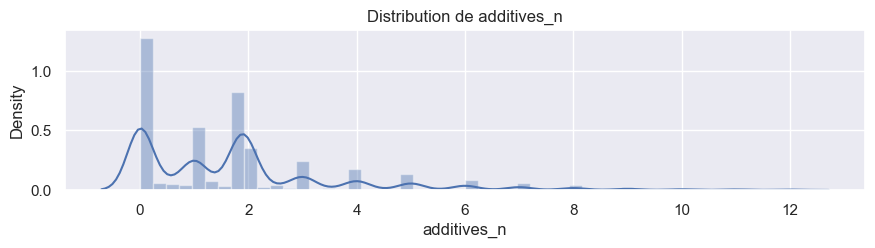

C:\Users\Zbook\OpenClassRoom\Projet\Projet_3\Livrable
C:\Users\Zbook\OpenClassRoom\Projet\Projet_3\Livrable\FIG\Aanalyse_univariée_Distribution_par_variable_libre\12_06_2023_20_58
C:\Users\Zbook\OpenClassRoom\Projet\Projet_3\Livrable\FIG\Aanalyse_univariée_Distribution_par_variable_libre\12_06_2023_20_58\Distribution de ingredients_from_palm_oil_n


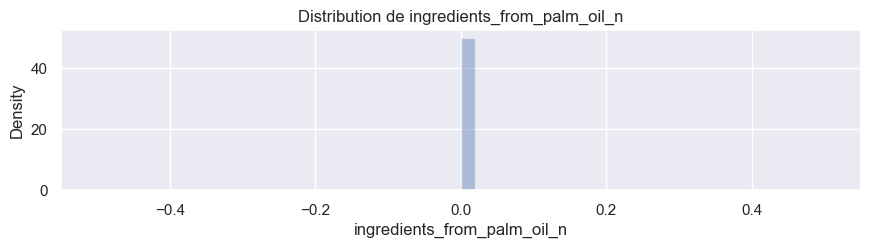

C:\Users\Zbook\OpenClassRoom\Projet\Projet_3\Livrable
C:\Users\Zbook\OpenClassRoom\Projet\Projet_3\Livrable\FIG\Aanalyse_univariée_Distribution_par_variable_libre\12_06_2023_20_58
C:\Users\Zbook\OpenClassRoom\Projet\Projet_3\Livrable\FIG\Aanalyse_univariée_Distribution_par_variable_libre\12_06_2023_20_58\Distribution de ingredients_that_may_be_from_palm_oil_n


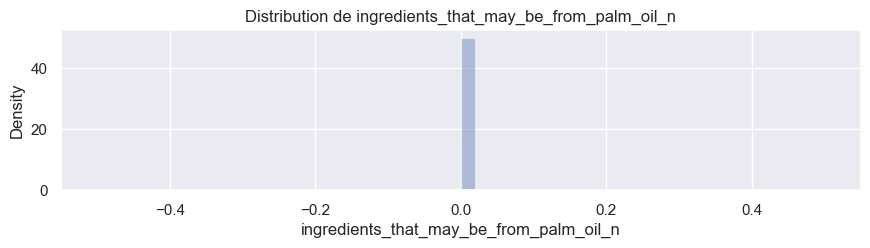

C:\Users\Zbook\OpenClassRoom\Projet\Projet_3\Livrable
C:\Users\Zbook\OpenClassRoom\Projet\Projet_3\Livrable\FIG\Aanalyse_univariée_Distribution_par_variable_libre\12_06_2023_20_58
C:\Users\Zbook\OpenClassRoom\Projet\Projet_3\Livrable\FIG\Aanalyse_univariée_Distribution_par_variable_libre\12_06_2023_20_58\Distribution de energy_100g


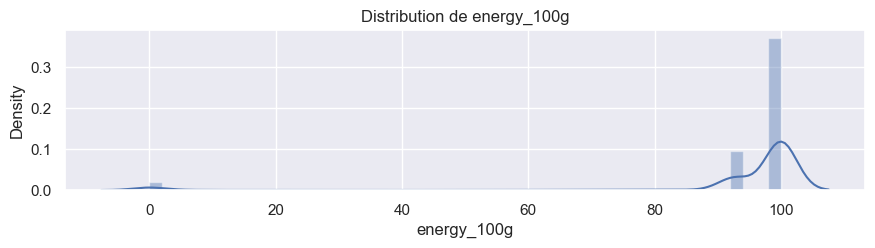

C:\Users\Zbook\OpenClassRoom\Projet\Projet_3\Livrable
C:\Users\Zbook\OpenClassRoom\Projet\Projet_3\Livrable\FIG\Aanalyse_univariée_Distribution_par_variable_libre\12_06_2023_20_58
C:\Users\Zbook\OpenClassRoom\Projet\Projet_3\Livrable\FIG\Aanalyse_univariée_Distribution_par_variable_libre\12_06_2023_20_58\Distribution de fat_100g


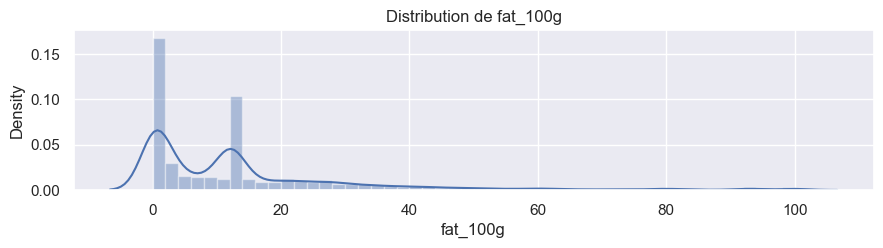

C:\Users\Zbook\OpenClassRoom\Projet\Projet_3\Livrable
C:\Users\Zbook\OpenClassRoom\Projet\Projet_3\Livrable\FIG\Aanalyse_univariée_Distribution_par_variable_libre\12_06_2023_20_58
C:\Users\Zbook\OpenClassRoom\Projet\Projet_3\Livrable\FIG\Aanalyse_univariée_Distribution_par_variable_libre\12_06_2023_20_58\Distribution de saturated-fat_100g


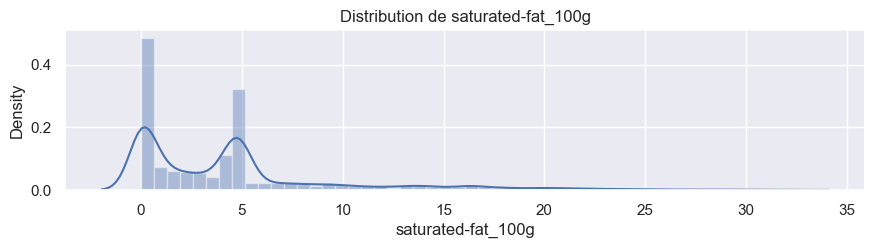

C:\Users\Zbook\OpenClassRoom\Projet\Projet_3\Livrable
C:\Users\Zbook\OpenClassRoom\Projet\Projet_3\Livrable\FIG\Aanalyse_univariée_Distribution_par_variable_libre\12_06_2023_20_58
C:\Users\Zbook\OpenClassRoom\Projet\Projet_3\Livrable\FIG\Aanalyse_univariée_Distribution_par_variable_libre\12_06_2023_20_58\Distribution de carbohydrates_100g


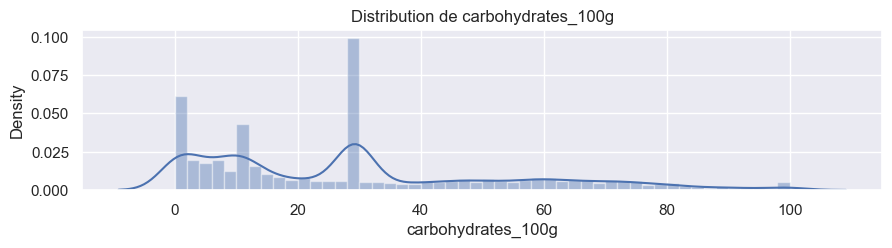

C:\Users\Zbook\OpenClassRoom\Projet\Projet_3\Livrable
C:\Users\Zbook\OpenClassRoom\Projet\Projet_3\Livrable\FIG\Aanalyse_univariée_Distribution_par_variable_libre\12_06_2023_20_58
C:\Users\Zbook\OpenClassRoom\Projet\Projet_3\Livrable\FIG\Aanalyse_univariée_Distribution_par_variable_libre\12_06_2023_20_58\Distribution de sugars_100g


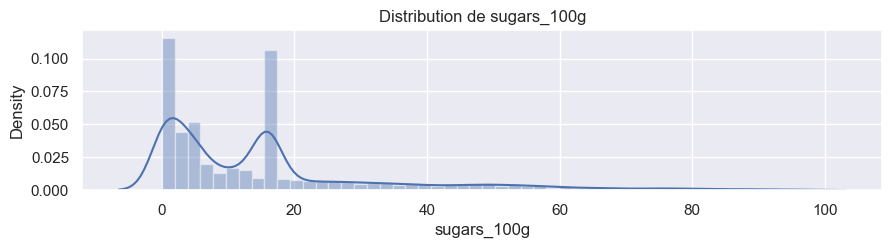

C:\Users\Zbook\OpenClassRoom\Projet\Projet_3\Livrable
C:\Users\Zbook\OpenClassRoom\Projet\Projet_3\Livrable\FIG\Aanalyse_univariée_Distribution_par_variable_libre\12_06_2023_20_58
C:\Users\Zbook\OpenClassRoom\Projet\Projet_3\Livrable\FIG\Aanalyse_univariée_Distribution_par_variable_libre\12_06_2023_20_58\Distribution de proteins_100g


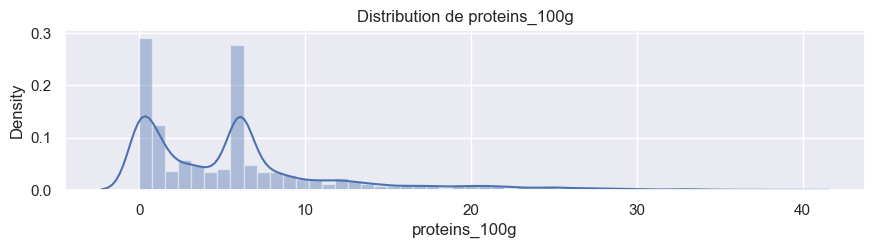

C:\Users\Zbook\OpenClassRoom\Projet\Projet_3\Livrable
C:\Users\Zbook\OpenClassRoom\Projet\Projet_3\Livrable\FIG\Aanalyse_univariée_Distribution_par_variable_libre\12_06_2023_20_58
C:\Users\Zbook\OpenClassRoom\Projet\Projet_3\Livrable\FIG\Aanalyse_univariée_Distribution_par_variable_libre\12_06_2023_20_58\Distribution de salt_100g


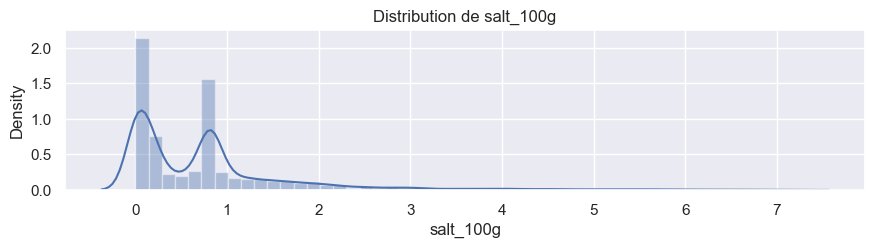

C:\Users\Zbook\OpenClassRoom\Projet\Projet_3\Livrable
C:\Users\Zbook\OpenClassRoom\Projet\Projet_3\Livrable\FIG\Aanalyse_univariée_Distribution_par_variable_libre\12_06_2023_20_58
C:\Users\Zbook\OpenClassRoom\Projet\Projet_3\Livrable\FIG\Aanalyse_univariée_Distribution_par_variable_libre\12_06_2023_20_58\Distribution de sodium_100g


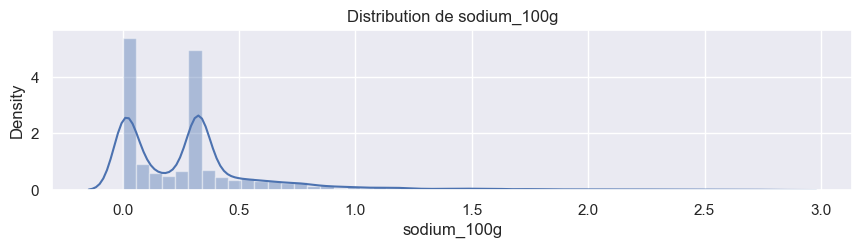

C:\Users\Zbook\OpenClassRoom\Projet\Projet_3\Livrable
C:\Users\Zbook\OpenClassRoom\Projet\Projet_3\Livrable\FIG\Aanalyse_univariée_Distribution_par_variable_libre\12_06_2023_20_58
C:\Users\Zbook\OpenClassRoom\Projet\Projet_3\Livrable\FIG\Aanalyse_univariée_Distribution_par_variable_libre\12_06_2023_20_58\Distribution de nutrition-score-fr_100g


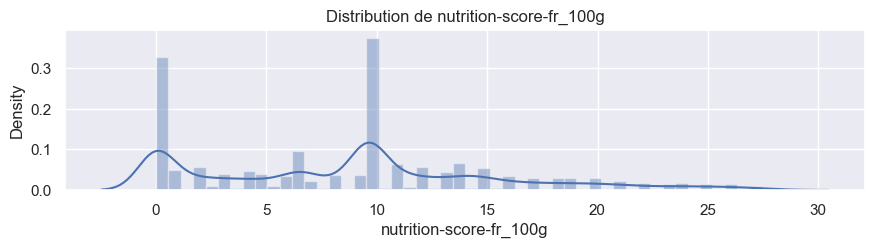

In [274]:
# numeric_columns = data.select_dtypes(include = ['int8', 'float32','int32','float64']).columns
# for column in numeric_columns:
#     plt.figure(figsize = (10,2))
#     sns.set(font_scale=1)
#     sns.distplot(data[column], bins=50)
#     chaine = 'Distribution de ' + column
#     plt.title(chaine)
#     plt.xlabel(column)
# #    plt.show()
#     save_figure_opt(chaine,"Aanalyse_univariée_Distribution_par_variable", library='matplotlib')
numeric_columns = data.select_dtypes(include = ['int8', 'float32','int32','float64']).columns

for column in numeric_columns:
    plt.figure(figsize = (10,2))
    sns.set(font_scale=1)
    sns.distplot(data[column], bins=50)
    chaine = 'Distribution de ' + column
    plt.title(chaine)
    plt.xlabel(column)
#     x_max = min(100, data[column].max() * 1.1)
#     plt.xlim(0, x_max)
#     plt.ylim(0, 100)
#    plt.show()
    save_figure_opt(chaine,"Aanalyse_univariée_Distribution_par_variable_libre", library='matplotlib')


C:\Users\Zbook\OpenClassRoom\Projet\Projet_3\Livrable
C:\Users\Zbook\OpenClassRoom\Projet\Projet_3\Livrable\FIG\Aanalyse_univariée_Distribution_par_variable_100g\12_06_2023_20_58
C:\Users\Zbook\OpenClassRoom\Projet\Projet_3\Livrable\FIG\Aanalyse_univariée_Distribution_par_variable_100g\12_06_2023_20_58\Distribution de additives_n


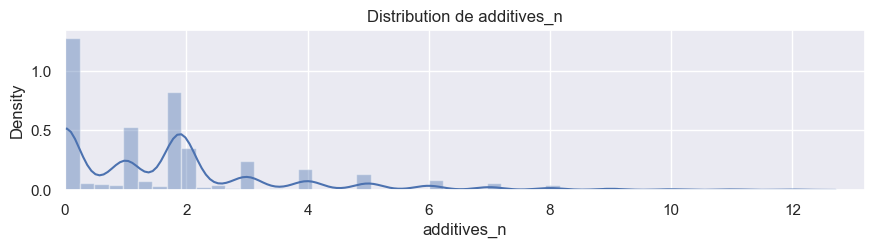

C:\Users\Zbook\OpenClassRoom\Projet\Projet_3\Livrable
C:\Users\Zbook\OpenClassRoom\Projet\Projet_3\Livrable\FIG\Aanalyse_univariée_Distribution_par_variable_100g\12_06_2023_20_58
C:\Users\Zbook\OpenClassRoom\Projet\Projet_3\Livrable\FIG\Aanalyse_univariée_Distribution_par_variable_100g\12_06_2023_20_58\Distribution de ingredients_from_palm_oil_n


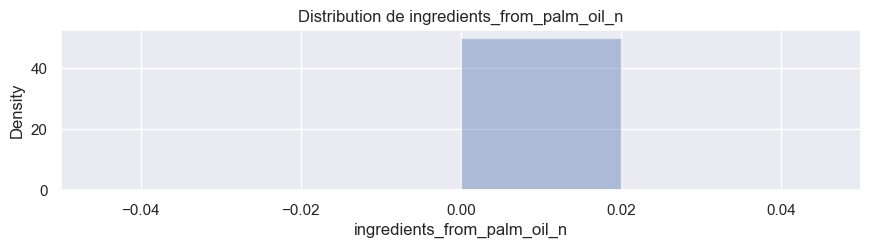

C:\Users\Zbook\OpenClassRoom\Projet\Projet_3\Livrable
C:\Users\Zbook\OpenClassRoom\Projet\Projet_3\Livrable\FIG\Aanalyse_univariée_Distribution_par_variable_100g\12_06_2023_20_58
C:\Users\Zbook\OpenClassRoom\Projet\Projet_3\Livrable\FIG\Aanalyse_univariée_Distribution_par_variable_100g\12_06_2023_20_58\Distribution de ingredients_that_may_be_from_palm_oil_n


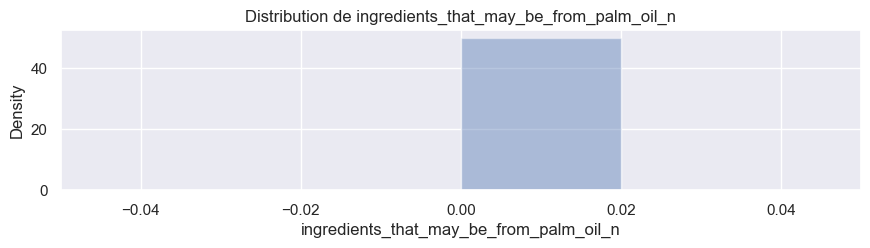

C:\Users\Zbook\OpenClassRoom\Projet\Projet_3\Livrable
C:\Users\Zbook\OpenClassRoom\Projet\Projet_3\Livrable\FIG\Aanalyse_univariée_Distribution_par_variable_100g\12_06_2023_20_58
C:\Users\Zbook\OpenClassRoom\Projet\Projet_3\Livrable\FIG\Aanalyse_univariée_Distribution_par_variable_100g\12_06_2023_20_58\Distribution de energy_100g


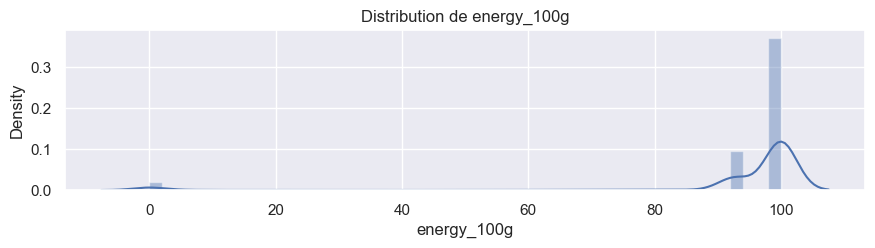

C:\Users\Zbook\OpenClassRoom\Projet\Projet_3\Livrable
C:\Users\Zbook\OpenClassRoom\Projet\Projet_3\Livrable\FIG\Aanalyse_univariée_Distribution_par_variable_100g\12_06_2023_20_58
C:\Users\Zbook\OpenClassRoom\Projet\Projet_3\Livrable\FIG\Aanalyse_univariée_Distribution_par_variable_100g\12_06_2023_20_58\Distribution de fat_100g


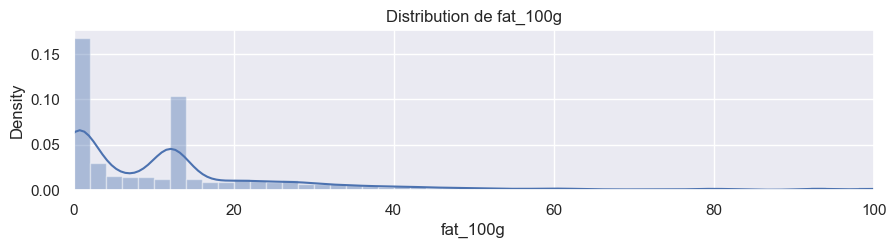

C:\Users\Zbook\OpenClassRoom\Projet\Projet_3\Livrable
C:\Users\Zbook\OpenClassRoom\Projet\Projet_3\Livrable\FIG\Aanalyse_univariée_Distribution_par_variable_100g\12_06_2023_20_58
C:\Users\Zbook\OpenClassRoom\Projet\Projet_3\Livrable\FIG\Aanalyse_univariée_Distribution_par_variable_100g\12_06_2023_20_58\Distribution de saturated-fat_100g


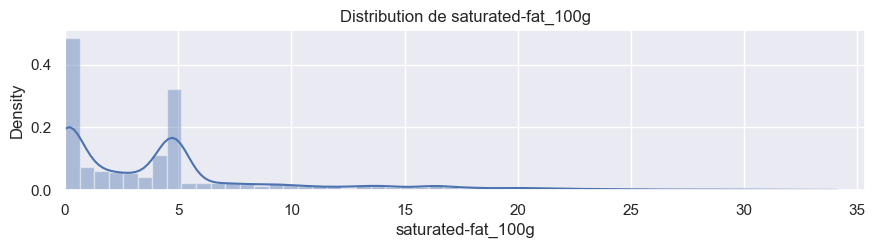

C:\Users\Zbook\OpenClassRoom\Projet\Projet_3\Livrable
C:\Users\Zbook\OpenClassRoom\Projet\Projet_3\Livrable\FIG\Aanalyse_univariée_Distribution_par_variable_100g\12_06_2023_20_58
C:\Users\Zbook\OpenClassRoom\Projet\Projet_3\Livrable\FIG\Aanalyse_univariée_Distribution_par_variable_100g\12_06_2023_20_58\Distribution de carbohydrates_100g


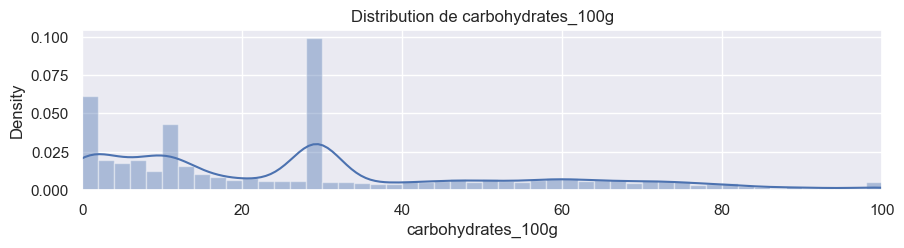

C:\Users\Zbook\OpenClassRoom\Projet\Projet_3\Livrable
C:\Users\Zbook\OpenClassRoom\Projet\Projet_3\Livrable\FIG\Aanalyse_univariée_Distribution_par_variable_100g\12_06_2023_20_58
C:\Users\Zbook\OpenClassRoom\Projet\Projet_3\Livrable\FIG\Aanalyse_univariée_Distribution_par_variable_100g\12_06_2023_20_58\Distribution de sugars_100g


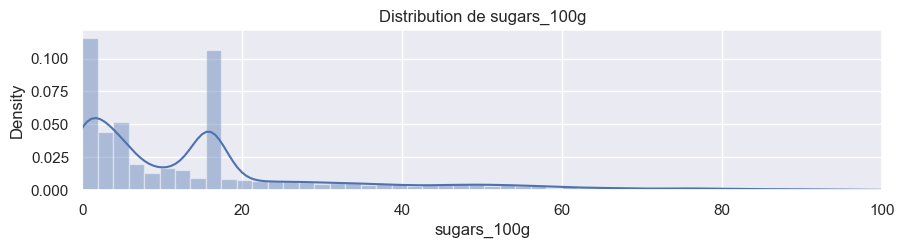

C:\Users\Zbook\OpenClassRoom\Projet\Projet_3\Livrable
C:\Users\Zbook\OpenClassRoom\Projet\Projet_3\Livrable\FIG\Aanalyse_univariée_Distribution_par_variable_100g\12_06_2023_20_58
C:\Users\Zbook\OpenClassRoom\Projet\Projet_3\Livrable\FIG\Aanalyse_univariée_Distribution_par_variable_100g\12_06_2023_20_58\Distribution de proteins_100g


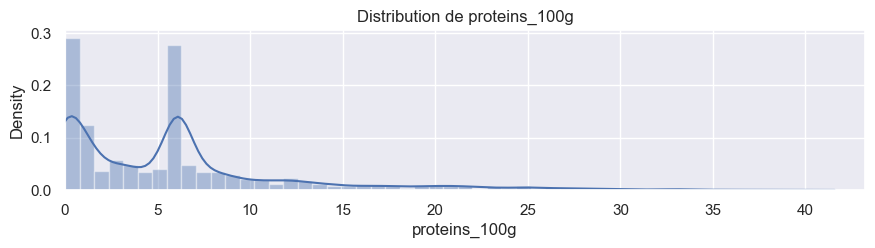

C:\Users\Zbook\OpenClassRoom\Projet\Projet_3\Livrable
C:\Users\Zbook\OpenClassRoom\Projet\Projet_3\Livrable\FIG\Aanalyse_univariée_Distribution_par_variable_100g\12_06_2023_20_58
C:\Users\Zbook\OpenClassRoom\Projet\Projet_3\Livrable\FIG\Aanalyse_univariée_Distribution_par_variable_100g\12_06_2023_20_58\Distribution de salt_100g


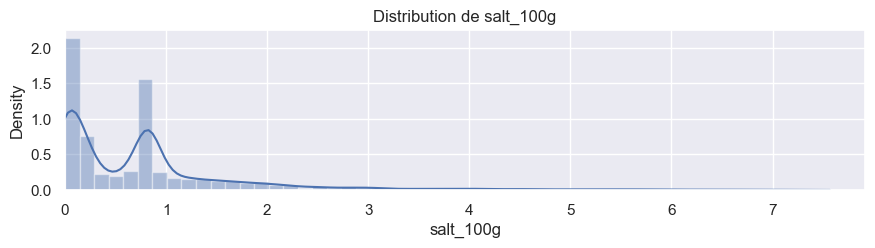

C:\Users\Zbook\OpenClassRoom\Projet\Projet_3\Livrable
C:\Users\Zbook\OpenClassRoom\Projet\Projet_3\Livrable\FIG\Aanalyse_univariée_Distribution_par_variable_100g\12_06_2023_20_58
C:\Users\Zbook\OpenClassRoom\Projet\Projet_3\Livrable\FIG\Aanalyse_univariée_Distribution_par_variable_100g\12_06_2023_20_58\Distribution de sodium_100g


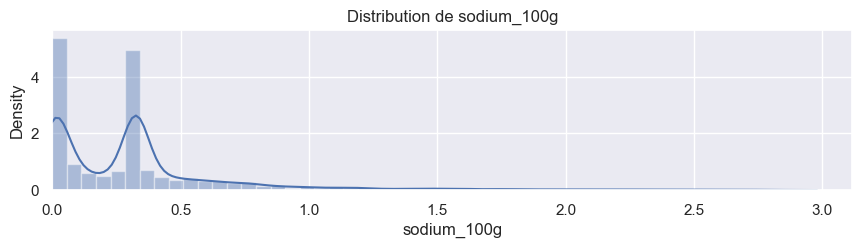

C:\Users\Zbook\OpenClassRoom\Projet\Projet_3\Livrable
C:\Users\Zbook\OpenClassRoom\Projet\Projet_3\Livrable\FIG\Aanalyse_univariée_Distribution_par_variable_100g\12_06_2023_20_58
C:\Users\Zbook\OpenClassRoom\Projet\Projet_3\Livrable\FIG\Aanalyse_univariée_Distribution_par_variable_100g\12_06_2023_20_58\Distribution de nutrition-score-fr_100g


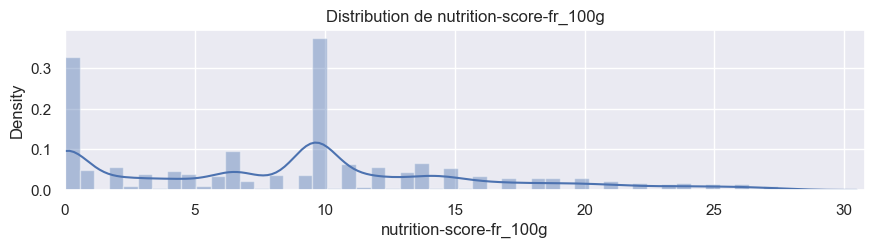

In [275]:
numeric_columns = data.select_dtypes(include = ['int8', 'float32','int32','float64']).columns

for column in numeric_columns:
    plt.figure(figsize = (10,2))
    sns.set(font_scale=1)
    if column in ['energy_100g', 'quantity']:
        sns.distplot(data[column].dropna(), bins=50)
    else:
        sns.distplot(data[column], bins=50)
    chaine = 'Distribution de ' + column
    plt.title(chaine)
    plt.xlabel(column)
    if column not in ['energy_100g', 'quantity']:
        x_max = min(100, data[column].max() * 1.1)
        plt.xlim(0, x_max)
    save_figure_opt(chaine,"Aanalyse_univariée_Distribution_par_variable_100g", library='matplotlib')



In [276]:
numeric_columns

Index(['additives_n', 'ingredients_from_palm_oil_n',
       'ingredients_that_may_be_from_palm_oil_n', 'energy_100g', 'fat_100g',
       'saturated-fat_100g', 'carbohydrates_100g', 'sugars_100g',
       'proteins_100g', 'salt_100g', 'sodium_100g', 'nutrition-score-fr_100g'],
      dtype='object')

**Observations :**
* Certaines distributions ont une allure très semblable:
    * fat_100g
    * saturated-fat_100g
    * carbohydrates_100g (à l’exception de la partie entre 40 et 80g)
    * sugars_100g
    * sodium_100g
    * salt_100g
    * proteins_100g
    
    
* Certaines variables sont discrètes:
    * nutrition-score-fr_100g
    * additives_n

### Boîtes à moustaches

C:\Users\Zbook\OpenClassRoom\Projet\Projet_3\Livrable
C:\Users\Zbook\OpenClassRoom\Projet\Projet_3\Livrable\FIG\Boite_moustache_Distribution_par_variable\12_06_2023_21_03
C:\Users\Zbook\OpenClassRoom\Projet\Projet_3\Livrable\FIG\Boite_moustache_Distribution_par_variable\12_06_2023_21_03\Distribution de additives_n


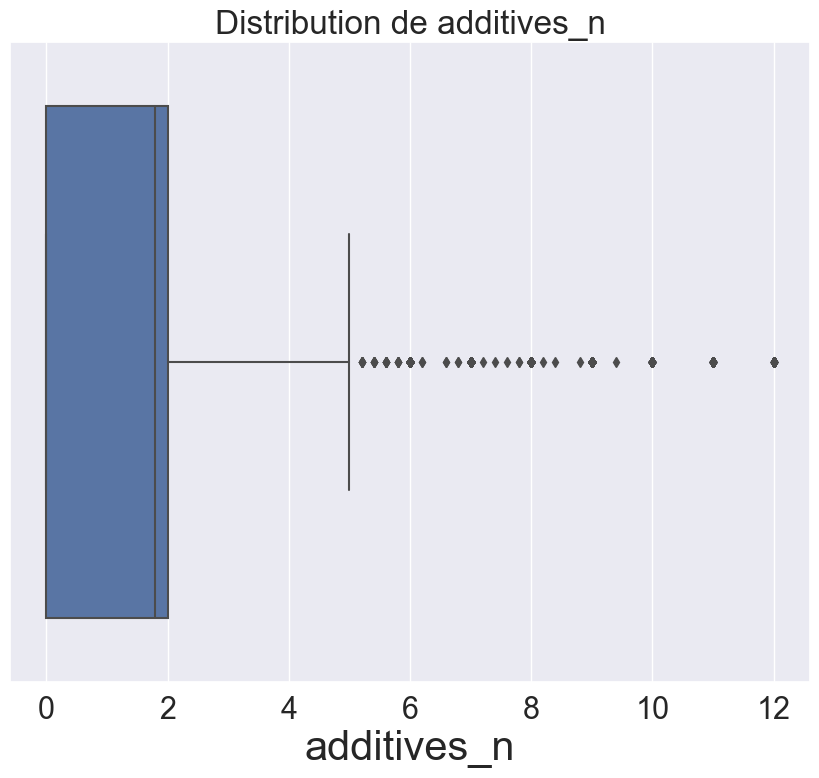

C:\Users\Zbook\OpenClassRoom\Projet\Projet_3\Livrable
C:\Users\Zbook\OpenClassRoom\Projet\Projet_3\Livrable\FIG\Boite_moustache_Distribution_par_variable\12_06_2023_21_03
C:\Users\Zbook\OpenClassRoom\Projet\Projet_3\Livrable\FIG\Boite_moustache_Distribution_par_variable\12_06_2023_21_03\Distribution de ingredients_from_palm_oil_n


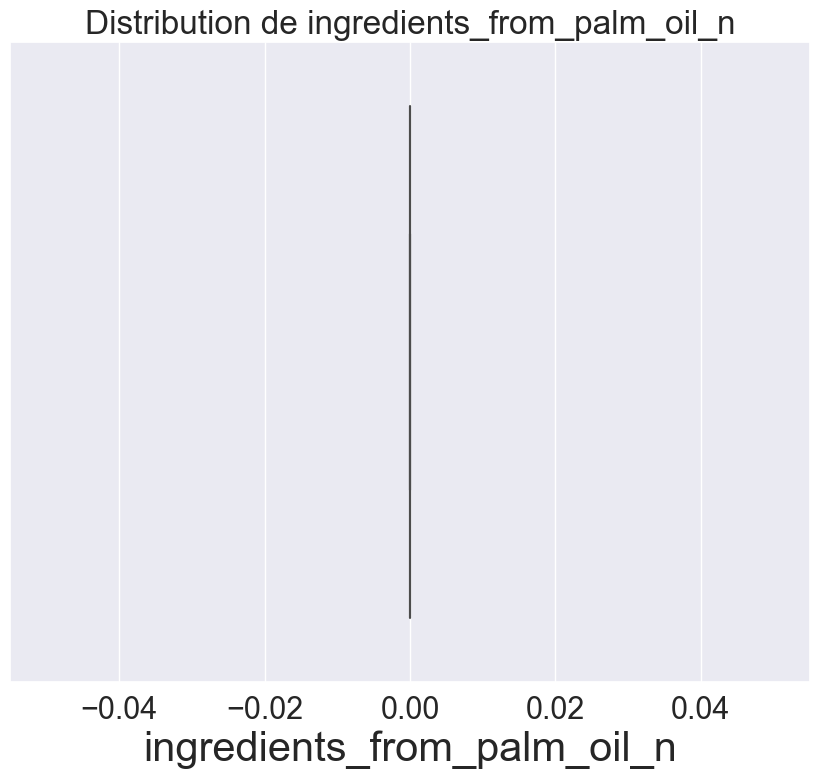

C:\Users\Zbook\OpenClassRoom\Projet\Projet_3\Livrable
C:\Users\Zbook\OpenClassRoom\Projet\Projet_3\Livrable\FIG\Boite_moustache_Distribution_par_variable\12_06_2023_21_03
C:\Users\Zbook\OpenClassRoom\Projet\Projet_3\Livrable\FIG\Boite_moustache_Distribution_par_variable\12_06_2023_21_03\Distribution de ingredients_that_may_be_from_palm_oil_n


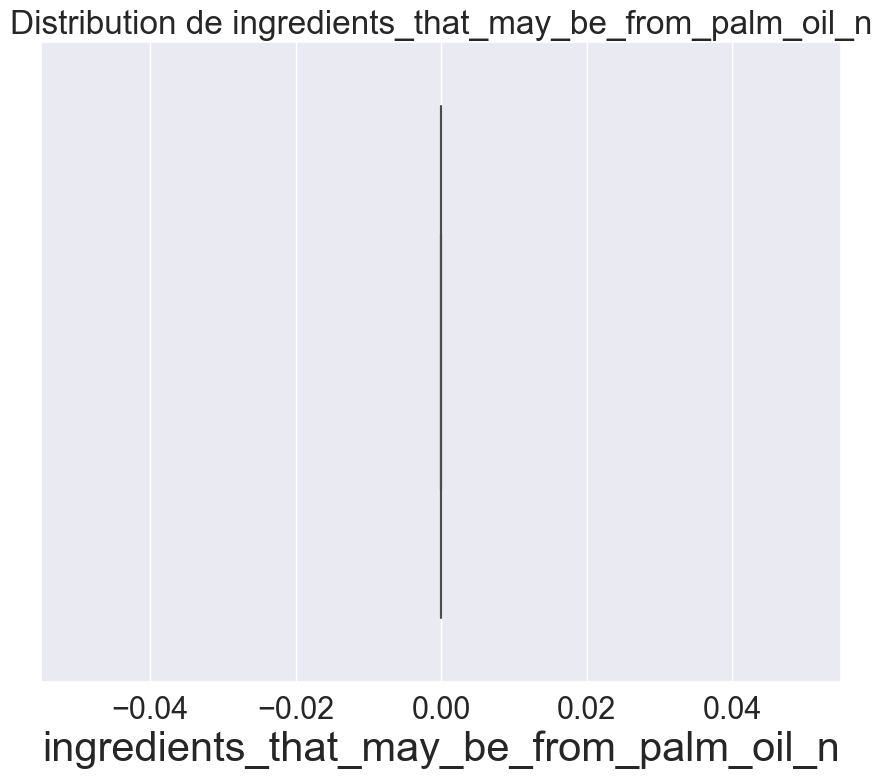

C:\Users\Zbook\OpenClassRoom\Projet\Projet_3\Livrable
C:\Users\Zbook\OpenClassRoom\Projet\Projet_3\Livrable\FIG\Boite_moustache_Distribution_par_variable\12_06_2023_21_03
C:\Users\Zbook\OpenClassRoom\Projet\Projet_3\Livrable\FIG\Boite_moustache_Distribution_par_variable\12_06_2023_21_03\Distribution de energy_100g


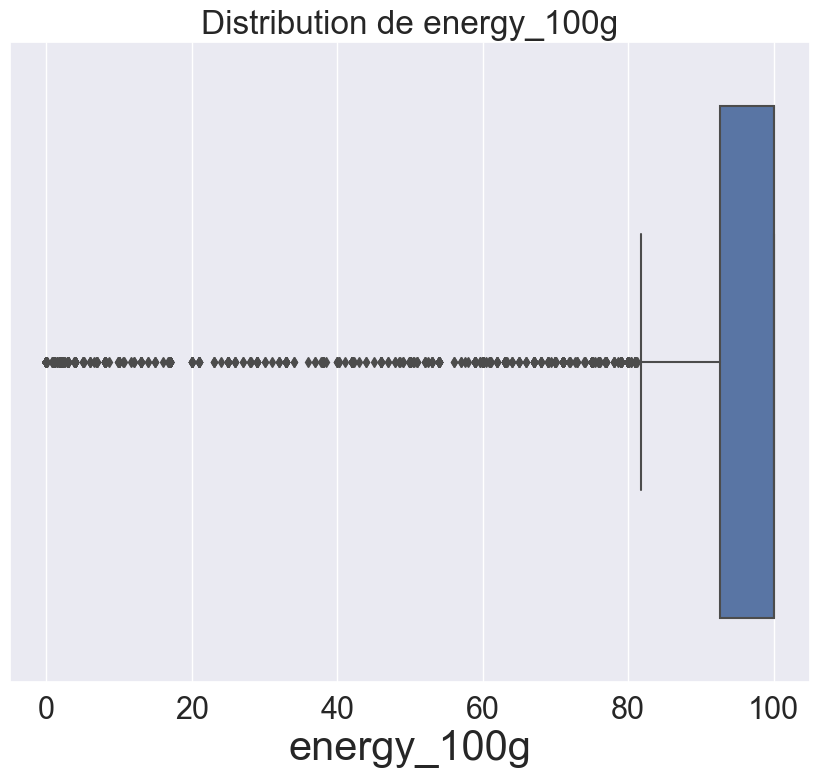

C:\Users\Zbook\OpenClassRoom\Projet\Projet_3\Livrable
C:\Users\Zbook\OpenClassRoom\Projet\Projet_3\Livrable\FIG\Boite_moustache_Distribution_par_variable\12_06_2023_21_03
C:\Users\Zbook\OpenClassRoom\Projet\Projet_3\Livrable\FIG\Boite_moustache_Distribution_par_variable\12_06_2023_21_03\Distribution de fat_100g


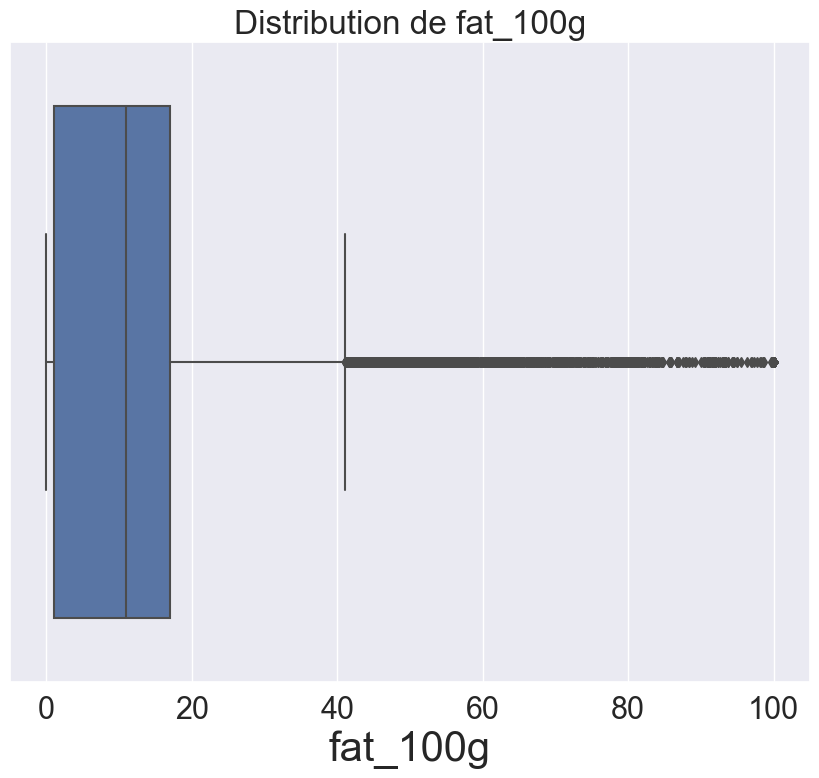

C:\Users\Zbook\OpenClassRoom\Projet\Projet_3\Livrable
C:\Users\Zbook\OpenClassRoom\Projet\Projet_3\Livrable\FIG\Boite_moustache_Distribution_par_variable\12_06_2023_21_03
C:\Users\Zbook\OpenClassRoom\Projet\Projet_3\Livrable\FIG\Boite_moustache_Distribution_par_variable\12_06_2023_21_03\Distribution de saturated-fat_100g


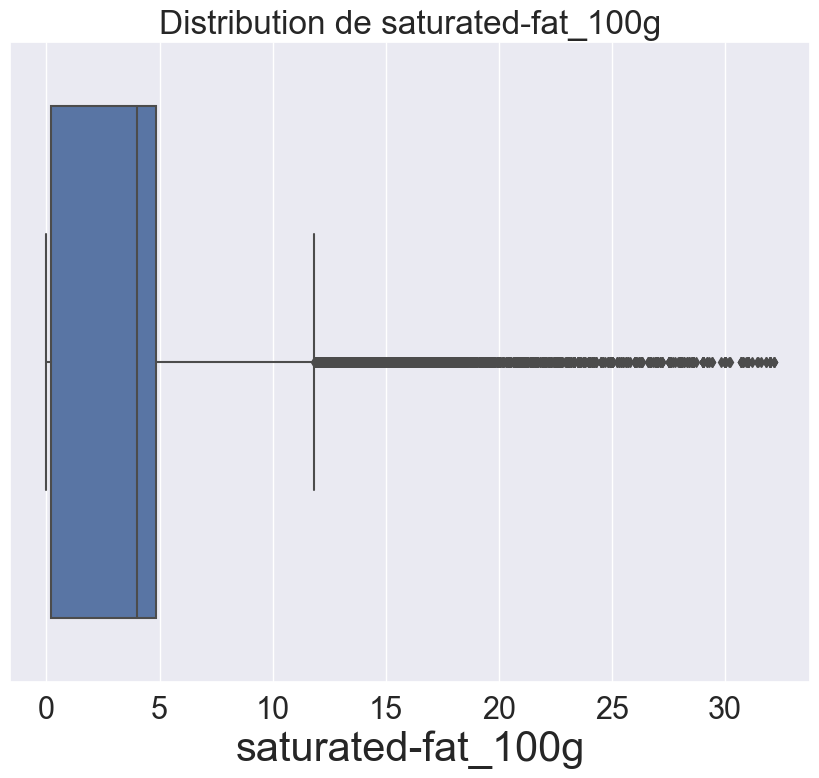

C:\Users\Zbook\OpenClassRoom\Projet\Projet_3\Livrable
C:\Users\Zbook\OpenClassRoom\Projet\Projet_3\Livrable\FIG\Boite_moustache_Distribution_par_variable\12_06_2023_21_03
C:\Users\Zbook\OpenClassRoom\Projet\Projet_3\Livrable\FIG\Boite_moustache_Distribution_par_variable\12_06_2023_21_03\Distribution de carbohydrates_100g


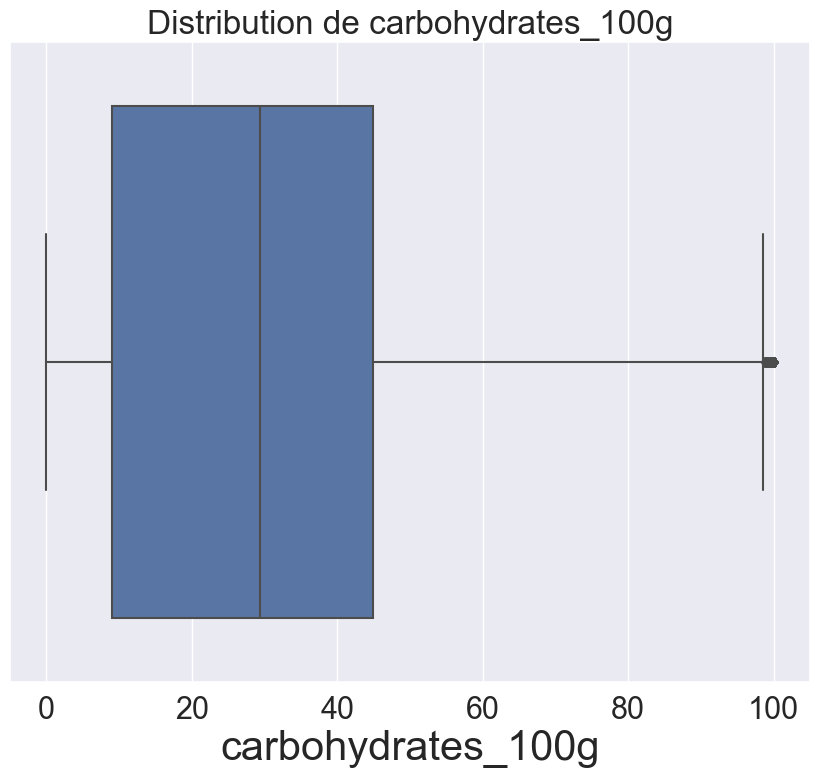

C:\Users\Zbook\OpenClassRoom\Projet\Projet_3\Livrable
C:\Users\Zbook\OpenClassRoom\Projet\Projet_3\Livrable\FIG\Boite_moustache_Distribution_par_variable\12_06_2023_21_03
C:\Users\Zbook\OpenClassRoom\Projet\Projet_3\Livrable\FIG\Boite_moustache_Distribution_par_variable\12_06_2023_21_03\Distribution de sugars_100g


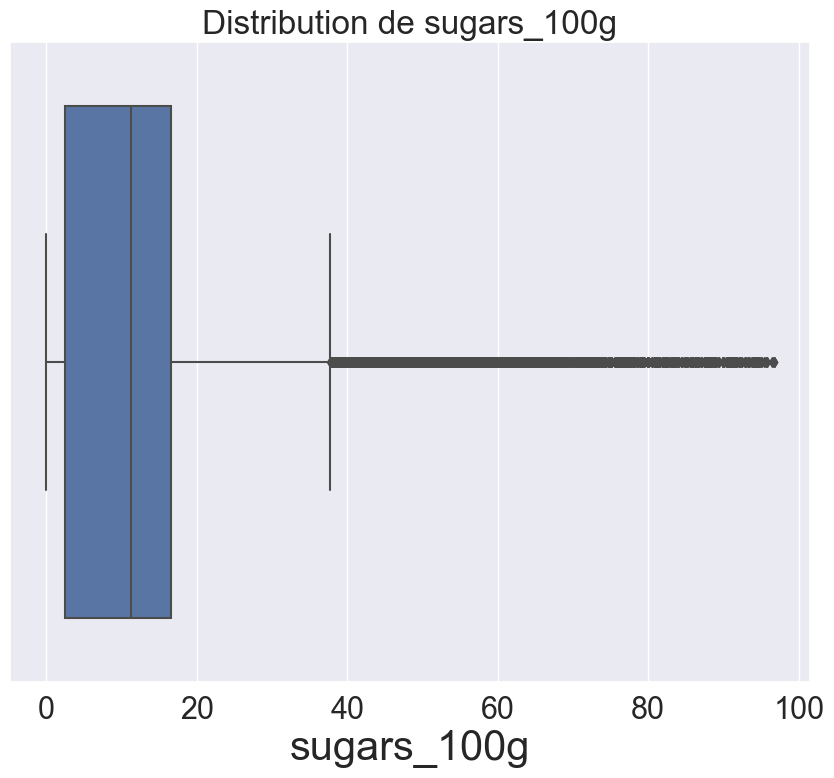

C:\Users\Zbook\OpenClassRoom\Projet\Projet_3\Livrable
C:\Users\Zbook\OpenClassRoom\Projet\Projet_3\Livrable\FIG\Boite_moustache_Distribution_par_variable\12_06_2023_21_03
C:\Users\Zbook\OpenClassRoom\Projet\Projet_3\Livrable\FIG\Boite_moustache_Distribution_par_variable\12_06_2023_21_03\Distribution de proteins_100g


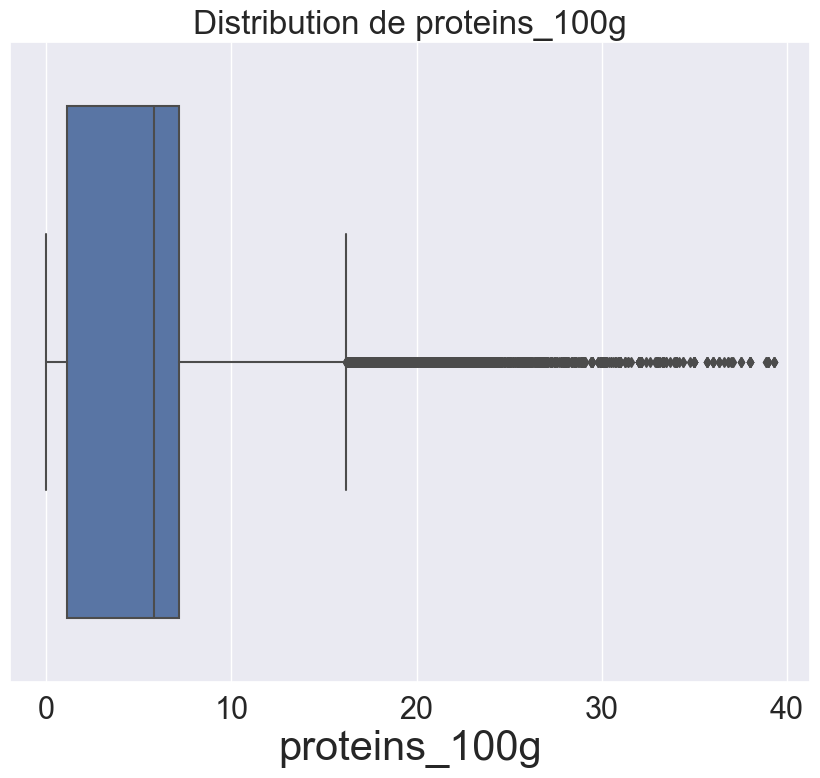

C:\Users\Zbook\OpenClassRoom\Projet\Projet_3\Livrable
C:\Users\Zbook\OpenClassRoom\Projet\Projet_3\Livrable\FIG\Boite_moustache_Distribution_par_variable\12_06_2023_21_03
C:\Users\Zbook\OpenClassRoom\Projet\Projet_3\Livrable\FIG\Boite_moustache_Distribution_par_variable\12_06_2023_21_03\Distribution de salt_100g


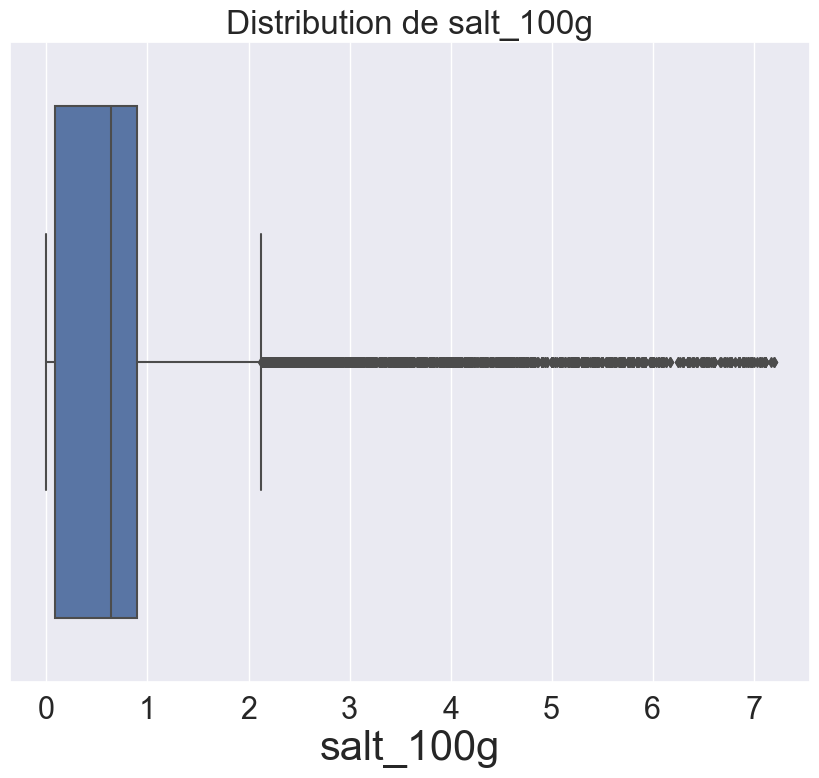

C:\Users\Zbook\OpenClassRoom\Projet\Projet_3\Livrable
C:\Users\Zbook\OpenClassRoom\Projet\Projet_3\Livrable\FIG\Boite_moustache_Distribution_par_variable\12_06_2023_21_03
C:\Users\Zbook\OpenClassRoom\Projet\Projet_3\Livrable\FIG\Boite_moustache_Distribution_par_variable\12_06_2023_21_03\Distribution de sodium_100g


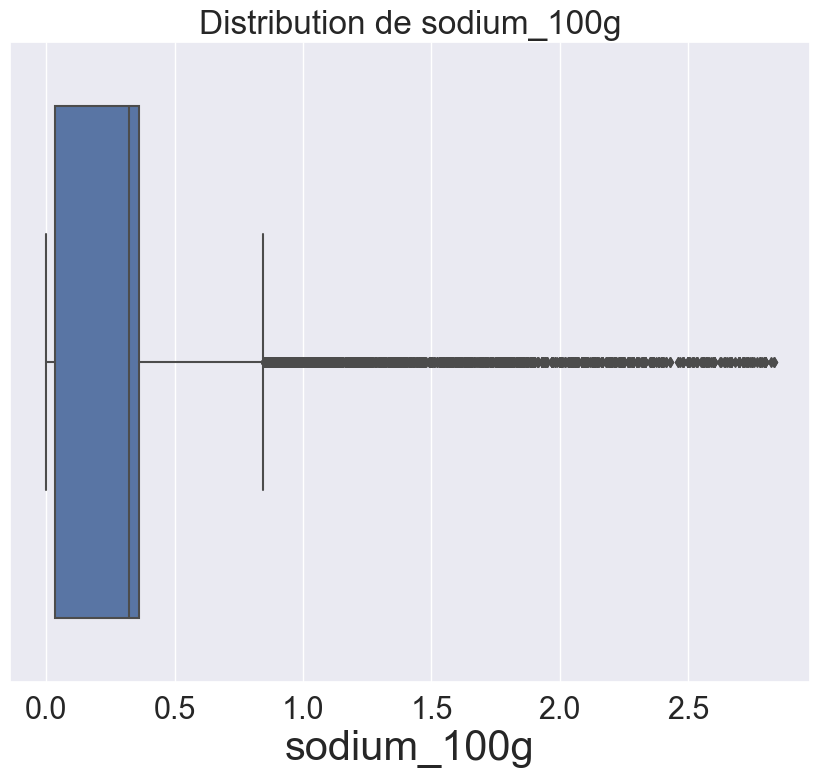

C:\Users\Zbook\OpenClassRoom\Projet\Projet_3\Livrable
C:\Users\Zbook\OpenClassRoom\Projet\Projet_3\Livrable\FIG\Boite_moustache_Distribution_par_variable\12_06_2023_21_03
C:\Users\Zbook\OpenClassRoom\Projet\Projet_3\Livrable\FIG\Boite_moustache_Distribution_par_variable\12_06_2023_21_03\Distribution de nutrition-score-fr_100g


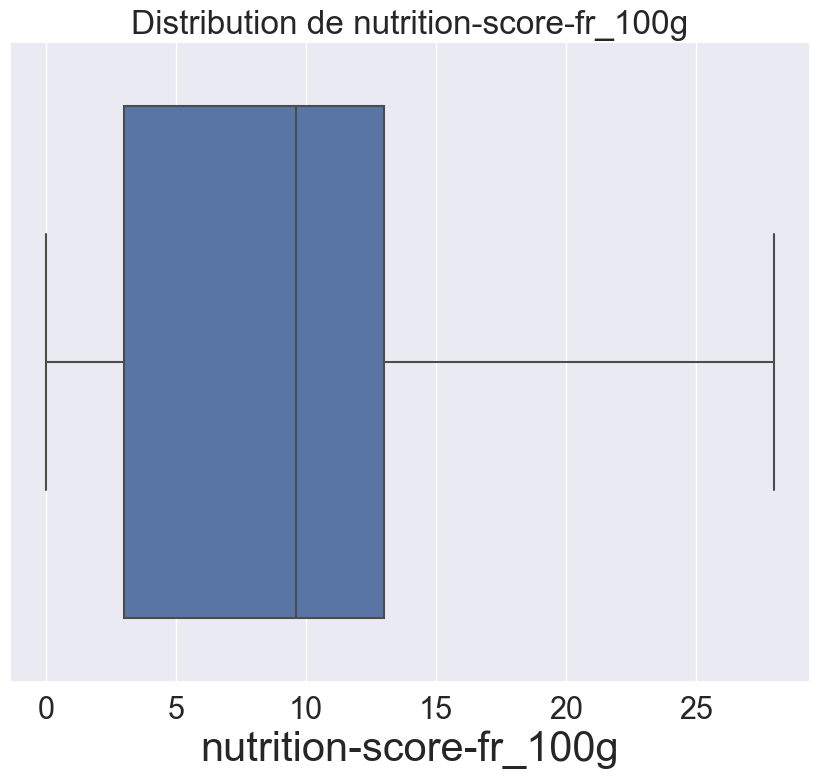

In [277]:
numeric_columns = data.select_dtypes(include = ['int8', 'float32','int32','float64']).columns
sns.set(font_scale=2)
for column in numeric_columns:
    plt.figure(figsize = (10,8))
    
    sns.boxplot(data[column])
    chaine = 'Distribution de ' + column
    plt.title(chaine)
    plt.xlabel(column, fontsize=30)
    save_figure_opt(chaine,"Boite_moustache_Distribution_par_variable", library='matplotlib')
#     plt.show()
sns.set(font_scale=1)


En observant les boxplot, on constate que les différentes variables ne semblent pas suivre une loi normale.

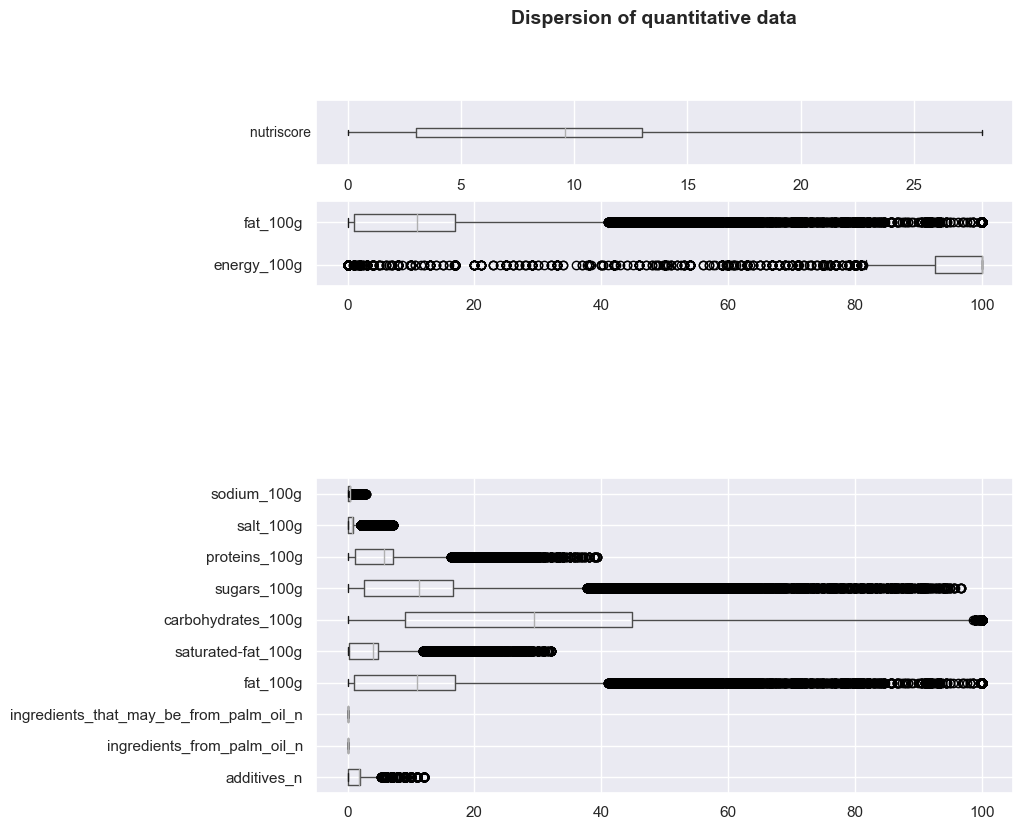

In [278]:
# Plotting boxplot of quantitative features for each nutrigrade

fig = plt.figure(figsize=(9,9))

ax1 = fig.add_subplot(9,1,1)
sel_cols = [ 'nutrition-score-fr_100g']
df[sel_cols].boxplot(vert=False, patch_artist= False, ax=ax1)
# ax1.boxplot(df['nutrition-score-fr_100g'], widths=[0.25], vert=False, patch_artist= False)
ax1.set_ylabel('nutriscore    ', rotation=0, va = 'center', fontsize=10, labelpad = 20)
ax1.set_yticks([])
# ax1.set_yticklabels(['']*10)

ax2 = fig.add_subplot(7,1,2)
# sel_cols = ['energy_100g', 'energy_from_fat_kj_100g']
sel_cols = ['energy_100g', 'fat_100g']
df[sel_cols].boxplot(vert=False, widths=[0.4,0.4], patch_artist= False, ax=ax2)

ax3 = fig.add_subplot(2,1,2)
# sel_cols = ['fat_100g', 'carbohydrates_100g', 'proteins_100g','saturated-fat_100g', 'sugars_100g', 'fiber_100g', 'salt_100g', 'sodium_100g']

sel_cols = ['additives_n', 'ingredients_from_palm_oil_n',
       'ingredients_that_may_be_from_palm_oil_n', 'fat_100g',
       'saturated-fat_100g', 'carbohydrates_100g', 'sugars_100g',
   'proteins_100g', 'salt_100g', 'sodium_100g']

df[sel_cols].boxplot(vert=False, patch_artist= False, ax=ax3)

plt.suptitle('Dispersion of quantitative data', fontsize=14,
             fontweight='bold')

plt.show()


In [279]:
categories_columns = data.select_dtypes(include = ['category']).columns

In [280]:
categories_columns

Index(['nutrition_grade_fr'], dtype='object')

In [281]:
data = affectation_types_object(data)

La colonne code n'existe pas dans le dataframe
La colonne url n'existe pas dans le dataframe
La colonne cities n'existe pas dans le dataframe
La colonne creator n'existe pas dans le dataframe
La colonne generic_name n'existe pas dans le dataframe
La colonne quantity n'existe pas dans le dataframe
La colonne packaging n'existe pas dans le dataframe
La colonne packaging_tags n'existe pas dans le dataframe
La colonne brands n'existe pas dans le dataframe
La colonne brands_tags n'existe pas dans le dataframe
La colonne categories n'existe pas dans le dataframe
La colonne categories_tags n'existe pas dans le dataframe
La colonne categories_en n'existe pas dans le dataframe
La colonne origins n'existe pas dans le dataframe
La colonne origins_tags n'existe pas dans le dataframe
La colonne manufacturing_places n'existe pas dans le dataframe
La colonne manufacturing_places_tags n'existe pas dans le dataframe
La colonne labels n'existe pas dans le dataframe
La colonne labels_tags n'existe pas da

### Occurences des mots

In [282]:
object_columns = data.select_dtypes(include = ['object']).columns
object_columns

Index(['product_name', 'nutrition_grade_fr'], dtype='object')

In [283]:
data.head(1)

additives_n  ingredients_from_palm_oil_n  \
0  0.0          0.0                           

   ingredients_that_may_be_from_palm_oil_n  energy_100g  fat_100g  \
0  0.0                                      100.0        18.27      

   saturated-fat_100g  carbohydrates_100g  sugars_100g  proteins_100g  \
0  1.92                63.459999           11.54        13.46           

   salt_100g  sodium_100g  nutrition-score-fr_100g            product_name  \
0  0.001593   0.075404     0.0                      Organic Salted Nut Mix   

  nutrition_grade_fr  
0  d

In [284]:
df.head(1)

additives_n  ingredients_from_palm_oil_n  \
0  0.0          0.0                           

   ingredients_that_may_be_from_palm_oil_n  energy_100g  fat_100g  \
0  0.0                                      100.0        18.27      

   saturated-fat_100g  carbohydrates_100g  sugars_100g  proteins_100g  \
0  1.92                63.46               11.54        13.46           

   salt_100g  sodium_100g  nutrition-score-fr_100g            product_name  \
0  0.001593   0.075404     0.0                      Organic Salted Nut Mix   

  nutrition_grade_fr  
0  d

In [285]:
object_columns = ['product_name','product_name','additives_n','nutrition_grade_fr']

C:\Users\Zbook\OpenClassRoom\Projet\Projet_3\Livrable
C:\Users\Zbook\OpenClassRoom\Projet\Projet_3\Livrable\FIG\Occurence_par_variable_\12_06_2023_21_05
C:\Users\Zbook\OpenClassRoom\Projet\Projet_3\Livrable\FIG\Occurence_par_variable_\12_06_2023_21_05\occurences_de_la_colonne_product_name


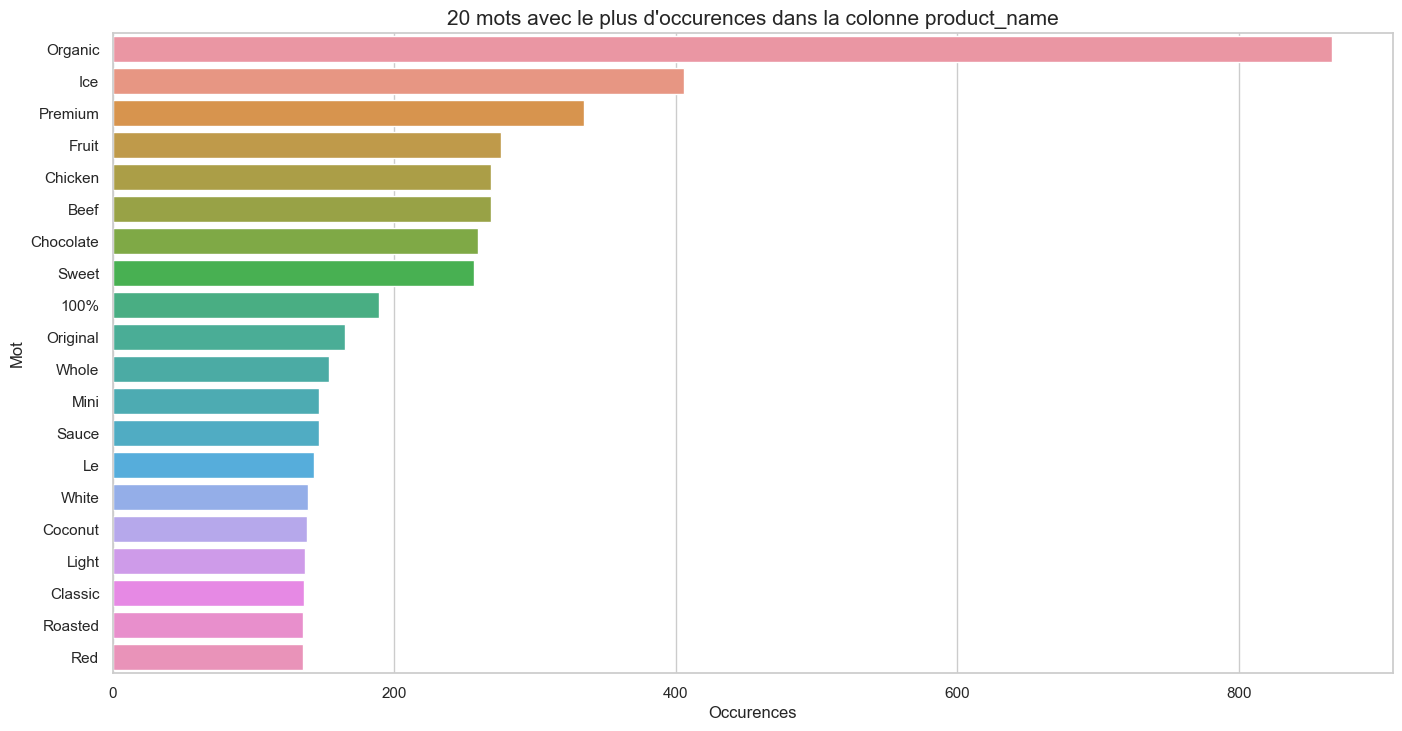

C:\Users\Zbook\OpenClassRoom\Projet\Projet_3\Livrable
C:\Users\Zbook\OpenClassRoom\Projet\Projet_3\Livrable\FIG\Occurence_par_variable_\12_06_2023_21_06
C:\Users\Zbook\OpenClassRoom\Projet\Projet_3\Livrable\FIG\Occurence_par_variable_\12_06_2023_21_06\occurences_de_la_colonne_additives_n


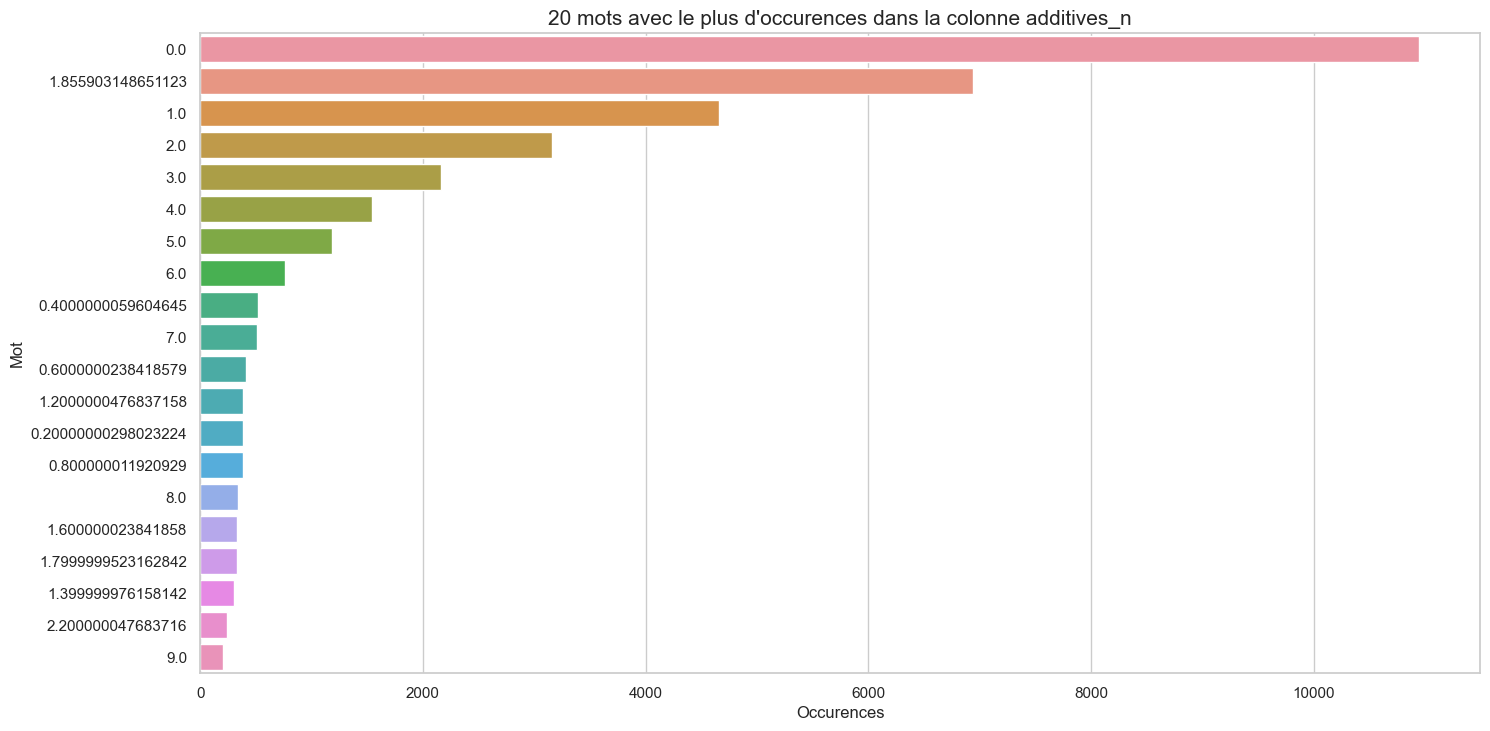

C:\Users\Zbook\OpenClassRoom\Projet\Projet_3\Livrable
C:\Users\Zbook\OpenClassRoom\Projet\Projet_3\Livrable\FIG\Occurence_par_variable_\12_06_2023_21_06
C:\Users\Zbook\OpenClassRoom\Projet\Projet_3\Livrable\FIG\Occurence_par_variable_\12_06_2023_21_06\occurences_de_la_colonne_nutrition_grade_fr


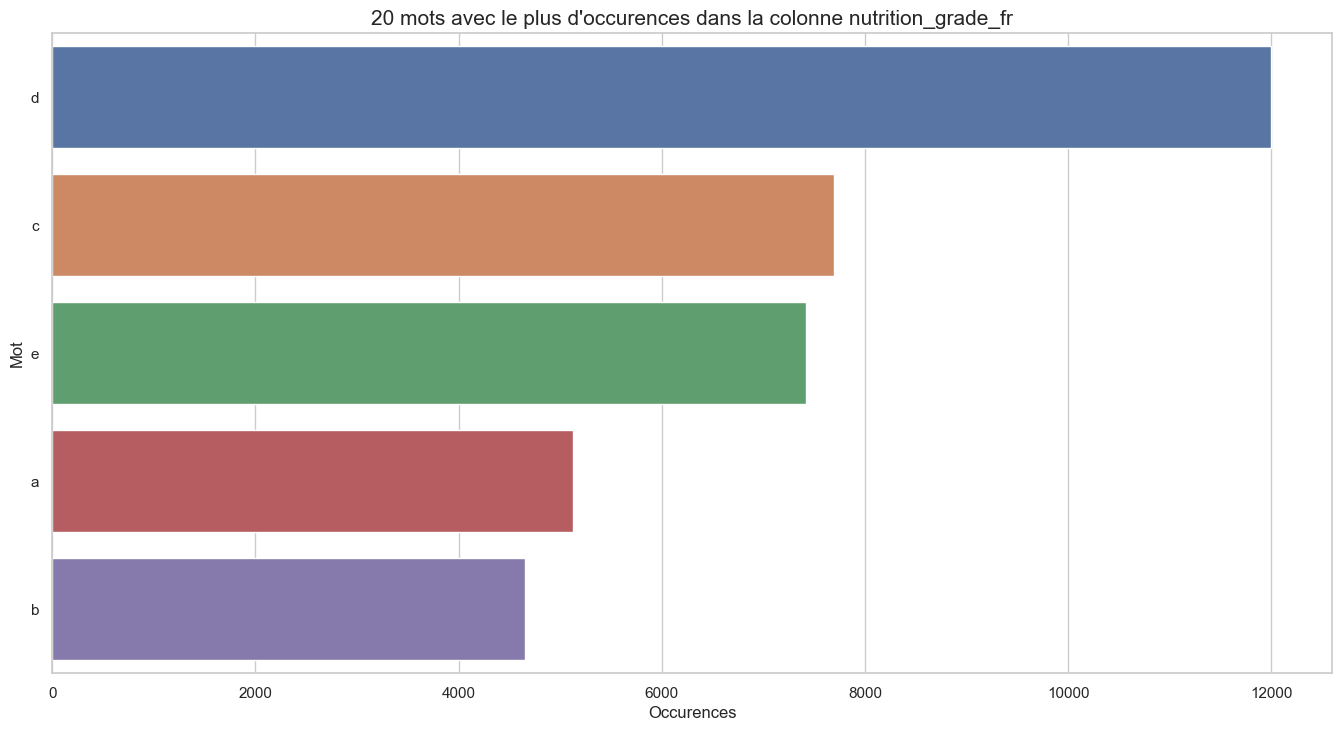

In [286]:
import collections

# Initialisation d'une liste pour stocker les mots populaires de chaque colonne
mots_populaires = []

# Pour chaque colonne de la liste object_columns, vérifier si elle existe dans le dataframe data
for colonne in object_columns :
    if colonne in data.columns:
        # Création d'une liste contenant le premier mot de chaque valeur non nulle de la colonne
        liste_mots = [str(i).split(' ', 1)[0] for i in data[colonne].dropna().tolist()]
        # Ajout des 20 mots les plus fréquents de la colonne dans la liste mots_populaires
        mots_populaires.append(collections.Counter(liste_mots).most_common(20))

# Réglage de la taille de police pour le graphique
sns.set(font_scale=2.5)

# Pour chaque colonne et sa liste de mots populaires, tracer un graphique
for nom_colonne, liste_mots in zip(object_columns[1:], mots_populaires[1:]):
    # Vérification que la liste de mots n'est pas vide
    if liste_mots:
        # Réglages du style et de la taille de la figure
        sns.set(style="whitegrid")
        plt.figure(figsize=(16, 8))

        # Création d'un dataframe contenant les 20 mots les plus fréquents de la colonne
        df_mots_utilises = pd.DataFrame(liste_mots, columns = ['Mot', 'Occurences']).sort_values(by='Occurences', ascending=False)
        df_mots_utilises.head()

        # Tracé d'un graphique en barres horizontales des mots et de leur fréquence
        sns.barplot(y = 'Mot', x='Occurences', data = df_mots_utilises)
        chaine = 'occurences_de_la_colonne_' + nom_colonne
        # Ajout d'un titre au graphique
        plt.title('20 mots avec le plus d\'occurences dans la colonne ' + nom_colonne, size=15)
        
        # Affichage du graphique
        #plt.show()
        save_figure_opt(chaine,"Occurence_par_variable_", library='matplotlib')

# Réinitialisation de la taille de police à la valeur par défaut
sns.set(font_scale=1)



In [287]:
import collections

# Initialisation d'une liste pour stocker les mots populaires de chaque colonne
mots_populaires = []

# Pour chaque colonne de la liste object_columns, vérifier si elle existe dans le dataframe data
for colonne in object_columns:
    if colonne in data.columns:
        # Création d'une liste contenant le premier mot de chaque valeur non nulle de la colonne
        liste_mots = [str(i).split(' ', 1)[0] for i in data[colonne].dropna().tolist()]
        # Ajout des 20 mots les plus fréquents de la colonne dans la liste mots_populaires
        mots_populaires.append(collections.Counter(liste_mots).most_common(20))

# Trier la liste mots_populaires par ordre décroissant d'occurrence
mots_populaires = sorted(mots_populaires, key=lambda x: x[0][1], reverse=True)

# Supprimer les mots inférieurs à 3 lettres et les libellés qui ne sont pas des lettres
mots_populaires = [[(mot, occ) for mot, occ in mots if len(mot) >= 3 and mot.isalpha() and mot != 'unknown'] for mots in mots_populaires]

# Supprimer les listes vides dans mots_populaires
mots_populaires = [mots for mots in mots_populaires if mots]

# Afficher mots_populaires
print(mots_populaires)


[[('Organic', 866), ('Ice', 406), ('Premium', 335), ('Fruit', 276), ('Chicken', 269), ('Beef', 269), ('Chocolate', 260), ('Sweet', 257), ('Original', 165), ('Whole', 154), ('Mini', 147), ('Sauce', 147), ('White', 139), ('Coconut', 138), ('Light', 137), ('Classic', 136), ('Roasted', 135), ('Red', 135)], [('Organic', 866), ('Ice', 406), ('Premium', 335), ('Fruit', 276), ('Chicken', 269), ('Beef', 269), ('Chocolate', 260), ('Sweet', 257), ('Original', 165), ('Whole', 154), ('Mini', 147), ('Sauce', 147), ('White', 139), ('Coconut', 138), ('Light', 137), ('Classic', 136), ('Roasted', 135), ('Red', 135)]]


C:\Users\Zbook\OpenClassRoom\Projet\Projet_3\Livrable
C:\Users\Zbook\OpenClassRoom\Projet\Projet_3\Livrable\FIG\Occurence_par_variable\12_06_2023_21_06
C:\Users\Zbook\OpenClassRoom\Projet\Projet_3\Livrable\FIG\Occurence_par_variable\12_06_2023_21_06\occurences_de_la_colonne_product_name


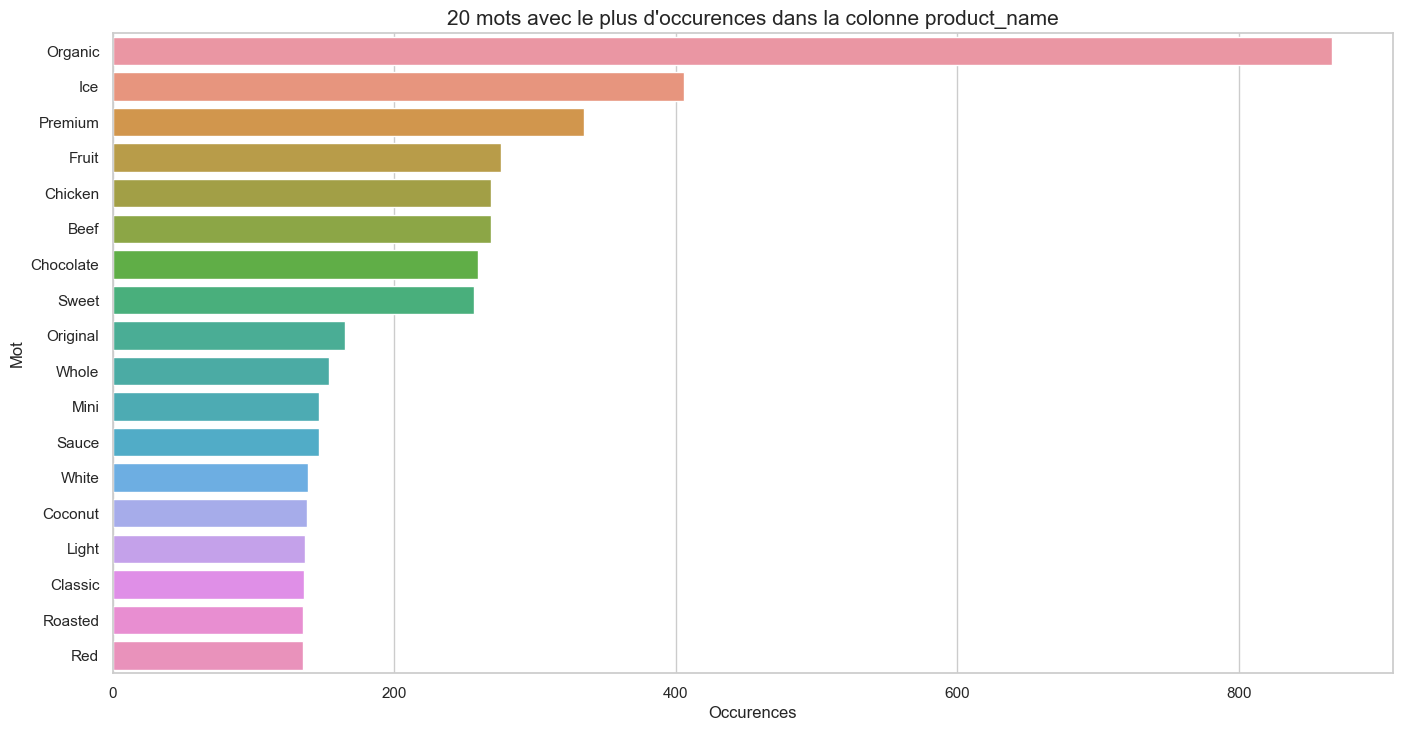

In [288]:
# import collections

# # Initialisation d'une liste pour stocker les mots populaires de chaque colonne
# mots_populaires = []

# # Pour chaque colonne de la liste object_columns, vérifier si elle existe dans le dataframe data
# for colonne in object_columns :
#     if colonne in data.columns:
#         # Création d'une liste contenant le premier mot de chaque valeur non nulle de la colonne
#         liste_mots = [str(i).split(' ', 1)[0] for i in data[colonne].dropna().tolist()]
#         # Ajout des 20 mots les plus fréquents de la colonne dans la liste mots_populaires
#         mots_populaires.append(collections.Counter(liste_mots).most_common(20))

# # print(liste_mots)
# # print(mots_populaires)

# Réglage de la taille de police pour le graphique
sns.set(font_scale=2.5)

# Pour chaque colonne et sa liste de mots populaires, tracer un graphique
for nom_colonne, mots_populaires in zip(object_columns[1:], mots_populaires[1:]):
    # Vérification que la liste de mots n'est pas vide
    if liste_mots:
        # Réglages du style et de la taille de la figure
        sns.set(style="whitegrid")
        plt.figure(figsize=(16, 8))

        # Création d'un dataframe contenant les 20 mots les plus fréquents de la colonne
        df_mots_utilises = pd.DataFrame(mots_populaires, columns = ['Mot', 'Occurences']).sort_values(by='Occurences', ascending=False)
        df_mots_utilises.head()

        # Tracé d'un graphique en barres horizontales des mots et de leur fréquence
        sns.barplot(y = 'Mot', x='Occurences', data = df_mots_utilises)
        chaine = 'occurences_de_la_colonne_' + nom_colonne
        # Ajout d'un titre au graphique
        plt.title('20 mots avec le plus d\'occurences dans la colonne ' + nom_colonne, size=15)
        
        # Suppression des articles définis et indéfinis dans les labels de l'axe y
        labels = [label.get_text() for label in plt.gca().get_yticklabels()]
        labels = [label for label in labels if label not in ['le', 'la', 'les', 'un', 'une', 'des','Le', 'La', 'Les', 'Un', 'Une', 'Des']]
        plt.yticks(range(len(labels)), labels)
        
        # Réduction de l'espace blanc autour du graphique
        plt.tight_layout()
        
        # Affichage du graphique
        #plt.show()
        save_figure_opt(chaine,"Occurence_par_variable", library='matplotlib')

# Réinitialisation de la taille de police à la valeur par défaut
sns.set(font_scale=1)


### Informations sur les données

In [289]:
df.head(1)

additives_n  ingredients_from_palm_oil_n  \
0  0.0          0.0                           

   ingredients_that_may_be_from_palm_oil_n  energy_100g  fat_100g  \
0  0.0                                      100.0        18.27      

   saturated-fat_100g  carbohydrates_100g  sugars_100g  proteins_100g  \
0  1.92                63.46               11.54        13.46           

   salt_100g  sodium_100g  nutrition-score-fr_100g            product_name  \
0  0.001593   0.075404     0.0                      Organic Salted Nut Mix   

  nutrition_grade_fr  
0  d

**Nutriscore**

In [290]:
#counts = data['nutrition_grade_fr'].value_counts()
counts = data['nutrition_grade_fr'].value_counts(dropna=False)

print(counts)


d    12000
c    7700 
e    7420 
a    5129 
b    4657 
Name: nutrition_grade_fr, dtype: int64


In [291]:
# Regrouper les données par nutriscore et calculer la somme et le pourcentage
nutriscore_sum = data.groupby('nutrition_grade_fr').sum()
nutriscore_percent = (nutriscore_sum / nutriscore_sum.sum()) * 100

# Afficher les résultats
print("Somme de chaque nutriscore:")
print(nutriscore_sum)
print("Pourcentage de chaque nutriscore:")
print(nutriscore_percent)


Somme de chaque nutriscore:
                     additives_n  ingredients_from_palm_oil_n  \
nutrition_grade_fr                                              
a                   9168.469727   0.0                           
b                   7695.977539   0.0                           
c                   13354.932617  0.0                           
d                   20959.632812  0.0                           
e                   13235.187500  0.0                           

                    ingredients_that_may_be_from_palm_oil_n   energy_100g  \
nutrition_grade_fr                                                          
a                   0.0                                      4.802846e+05   
b                   0.0                                      4.329902e+05   
c                   0.0                                      7.274982e+05   
d                   0.0                                      1.121517e+06   
e                   0.0                               

## <a name="C22">2.2 - Répartition des Nutriscores</a> 

In [295]:
# # Création d'une figure avec une taille de 8x8 pouces
# plt.figure(figsize=(8,8))

# chaine = 'Répartition des Nutriscores'
# # Ajout d'un titre à la figure
# plt.title(chaine, size=20)

# # Création d'un graphique en camembert en utilisant les valeurs de la colonne "nutrition_grade_fr"
# # Les étiquettes de chaque part sont en majuscules
# # Le pourcentage de chaque part est affiché avec une décimale
# # Les propriétés du texte sont définies pour une taille de police de 16, une couleur de police bleue et un fond blanc
# wedges, texts, autotexts = plt.pie(data.nutrition_grade_fr.value_counts().values, 
#         labels = data.nutrition_grade_fr.value_counts().index.str.upper(),
#        autopct='%1.1f%%', textprops={'fontsize': 16, 
#                                      'color' : 'b', 
#                                      'backgroundcolor' : 'w',}
#        )

# # Récupération des axes de la figure
# ax = plt.gca()

# # Ajout d'une légende aux graphiques en camembert
# # Les étiquettes des parts sont en majuscules et ont un titre "Note"
# # La légende est centrée à gauche
# # La taille de police est définie à 14
# # La boîte qui entoure la légende est ajustée pour ne pas chevaucher les graphiques en camembert
# ax.legend(wedges, data.nutrition_grade_fr.value_counts().index.str.upper(),
#           title="Note",
#           loc="center left",
#           fontsize=14,
#           bbox_to_anchor=(1, 0, 0.5, 1))
# save_figure_opt(chaine,"Repartition_Distribution_par_variable", library='matplotlib')

C:\Users\Zbook\OpenClassRoom\Projet\Projet_3\Livrable
C:\Users\Zbook\OpenClassRoom\Projet\Projet_3\Livrable\FIG\Répartition des Nutriscores\12_06_2023_21_08
C:\Users\Zbook\OpenClassRoom\Projet\Projet_3\Livrable\FIG\Répartition des Nutriscores\12_06_2023_21_08\Répartition des Nutriscores


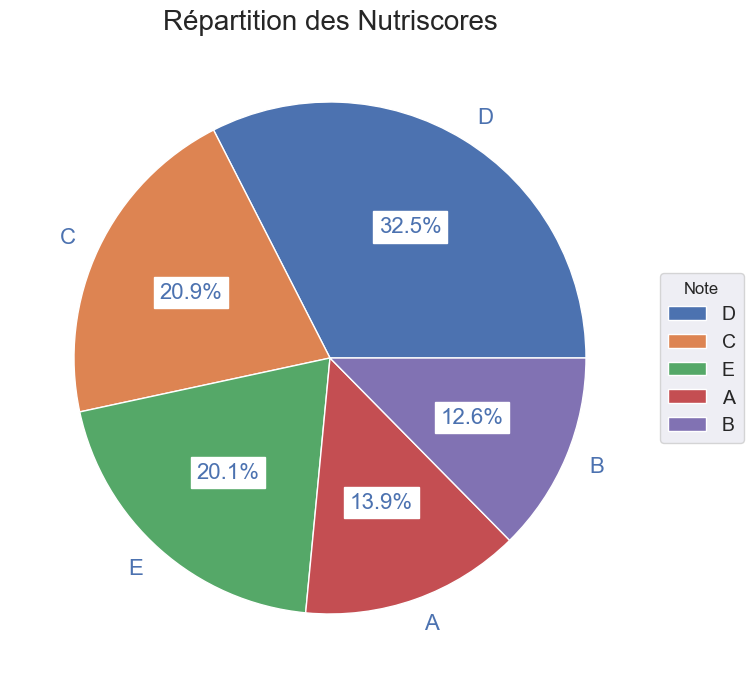

In [296]:
# Création d'une figure avec une taille de 8x8 pouces
plt.figure(figsize=(8,8))

chaine = 'Répartition des Nutriscores'
# Ajout d'un titre à la figure
plt.title(chaine, size=20)

# Création d'un graphique en camembert en utilisant les valeurs de la colonne "nutrition_grade_fr"
# Les étiquettes de chaque part sont en majuscules
# Le pourcentage de chaque part est affiché avec une décimale
# Les propriétés du texte sont définies pour une taille de police de 16, une couleur de police bleue et un fond blanc
wedges, texts, autotexts = plt.pie(data.nutrition_grade_fr.value_counts().values, 
        labels = data.nutrition_grade_fr.value_counts().index.str.upper(),
       autopct='%1.1f%%', textprops={'fontsize': 16, 
                                     'color' : 'b', 
                                     'backgroundcolor' : 'w',}
       )

# Récupération des axes de la figure
ax = plt.gca()

# Ajout d'une légende aux graphiques en camembert
# Les étiquettes des parts sont en majuscules et ont un titre "Note"
# La légende est centrée à gauche
# La taille de police est définie à 14
# La boîte qui entoure la légende est ajustée pour ne pas chevaucher les graphiques en camembert
ax.legend(wedges, data.nutrition_grade_fr.value_counts().index.str.upper(),
          title="Note",
          loc="center left",
          fontsize=14,
          bbox_to_anchor=(1, 0, 0.5, 1))

# Appel de la fonction save_figure_opt pour sauvegarder la figure
save_figure_opt(chaine,chaine)


In [297]:
print_null_pct(df)

nb of null:  0 
pct of null:  0.0


In [298]:
# Transforme l'axe x en entier
df['additives_n'] = df['additives_n'].astype(int)
# Transforme l'axe x en entier
data['additives_n'] = data['additives_n'].astype(int)

In [299]:
additives_values = df['additives_n'].unique()
print(additives_values)

[ 0  1  2  3  4  5  6  8 10  7 11  9 12]


In [300]:
df.columns

Index(['additives_n', 'ingredients_from_palm_oil_n',
       'ingredients_that_may_be_from_palm_oil_n', 'energy_100g', 'fat_100g',
       'saturated-fat_100g', 'carbohydrates_100g', 'sugars_100g',
       'proteins_100g', 'salt_100g', 'sodium_100g', 'nutrition-score-fr_100g',
       'product_name', 'nutrition_grade_fr'],
      dtype='object')

In [301]:
def adf_kpss_test(df, columns, ref_column):
    result = pd.DataFrame(columns=['ADF Statistic', 'p-value', 'KPSS Statistic', 'p-value'],
                          index=columns)
    for col in columns:
        adf_result = adfuller(df[col])
        kpss_result = kpss(df[col], regression='c')
        result.loc[col, 'ADF Statistic'] = adf_result[0]
        result.loc[col, 'p-value'] = adf_result[1]
        result.loc[col, 'KPSS Statistic'] = kpss_result[0]
        result.loc[col, 'p-value'] = kpss_result[1]
    adf_result = adfuller(df[ref_column])
    for col in columns:
        kpss_result = kpss(df[ref_column] - df[col], regression='c', nlags=int(np.ceil(3 * np.sqrt(len(df)))))
        result.loc[col, 'ADF Statistic (diff)'] = adf_result[0]
        result.loc[col, 'p-value (diff)'] = adf_result[1]
        result.loc[col, 'KPSS Statistic (diff)'] = kpss_result[0]
        result.loc[col, 'p-value (diff)'] = kpss_result[1]
    return result


In [303]:
# Remplacer NaN par 0 dans les colonnes spécifiées
df['ingredients_from_palm_oil_n'] = df['ingredients_from_palm_oil_n'].fillna(0)
df['ingredients_that_may_be_from_palm_oil_n'] = df['ingredients_that_may_be_from_palm_oil_n'].fillna(0)

# Convertir les colonnes en entiers
df['ingredients_from_palm_oil_n'] = df['ingredients_from_palm_oil_n'].astype(int)
df['ingredients_that_may_be_from_palm_oil_n'] = df['ingredients_that_may_be_from_palm_oil_n'].astype(int)


print ("Test colonne reférence nutrition-score-fr_100g" ) 
df = df.dropna(subset=['additives_n',
                       'fat_100g', 'saturated-fat_100g', 'carbohydrates_100g', 'sugars_100g', 
                       'proteins_100g', 'salt_100g', 'sodium_100g', 'nutrition-score-fr_100g','energy_100g'])

resultats_tests = adf_kpss_test(df, ['additives_n',
                                     'fat_100g', 'saturated-fat_100g', 'carbohydrates_100g', 'sugars_100g', 
                                     'proteins_100g', 'salt_100g', 'sodium_100g'], 'nutrition-score-fr_100g')
print(resultats_tests)
print ("Test colonne reférence energy_100g" ) 
df = df.dropna(subset=['additives_n', 
                       'fat_100g', 'saturated-fat_100g', 'carbohydrates_100g', 'sugars_100g', 
                       'proteins_100g', 'salt_100g', 'sodium_100g', 'nutrition-score-fr_100g','energy_100g'])

resultats_tests = adf_kpss_test(df, ['additives_n',
                                     'fat_100g', 'saturated-fat_100g', 'carbohydrates_100g', 'sugars_100g', 
                                     'proteins_100g', 'salt_100g', 'sodium_100g'], 'energy_100g')
print(resultats_tests)


Test colonne reférence nutrition-score-fr_100g
                   ADF Statistic p-value KPSS Statistic p-value  \
additives_n        -18.224597     0.01    11.726603      0.01     
fat_100g           -45.908458     0.01    4.373144       0.01     
saturated-fat_100g -25.412074     0.01    6.75543        0.01     
carbohydrates_100g -32.174735     0.1     0.254028       0.1      
sugars_100g        -22.066612     0.01    4.397304       0.01     
proteins_100g      -23.836894     0.01    5.780059       0.01     
salt_100g          -43.029118     0.01    1.177022       0.01     
sodium_100g        -43.105059     0.01    0.805865       0.01     

                    ADF Statistic (diff)  p-value (diff)  \
additives_n        -26.813349             0.010000         
fat_100g           -26.813349             0.010000         
saturated-fat_100g -26.813349             0.100000         
carbohydrates_100g -26.813349             0.088399         
sugars_100g        -26.813349             0.01000

une explication pour chaque colonne du tableau :

- La colonne "Test" indique le nom de la variable testée dans l'analyse.

- La colonne "ADF Statistic" correspond au résultat du test ADF (Augmented Dickey-Fuller) qui permet de vérifier si une série temporelle est stationnaire ou non. Plus la valeur de ce test est négative, plus il y a de chances que la série temporelle soit stationnaire.

- La colonne "p-value (ADF)" correspond à la valeur de p associée au test ADF. Elle indique si la série temporelle est stationnaire ou non en fonction d'un seuil de significativité. Si la valeur de p est inférieure au seuil de significativité (par exemple, 0,05), on peut rejeter l'hypothèse nulle selon laquelle la série temporelle n'est pas stationnaire.

- La colonne "KPSS Statistic" correspond au résultat du test KPSS (Kwiatkowski-Phillips-Schmidt-Shin) qui permet de vérifier si une série temporelle est stationnaire ou non. Plus la valeur de ce test est positive, plus il y a de chances que la série temporelle ne soit pas stationnaire.

- La colonne "p-value (KPSS)" correspond à la valeur de p associée au test KPSS. Elle indique si la série temporelle est stationnaire ou non en fonction d'un seuil de significativité. Si la valeur de p est inférieure au seuil de significativité (par exemple, 0,05), on peut rejeter l'hypothèse nulle selon laquelle la série temporelle est stationnaire.

- La colonne "ADF Statistic (diff)" correspond au résultat du test ADF (Augmented Dickey-Fuller) après avoir différencié la série temporelle. La différenciation consiste à soustraire chaque observation de la précédente. Ce test est utilisé pour vérifier si la série temporelle différenciée est stationnaire.

- La colonne "p-value (diff)" correspond à la valeur de p associée au test ADF après différenciation de la série temporelle. Elle indique si la série temporelle différenciée est stationnaire ou non en fonction d'un seuil de significativité.

- La colonne "KPSS Statistic (diff)" correspond au résultat du test KPSS après différenciation de la série temporelle. Ce test est utilisé pour vérifier si la série temporelle différenciée est stationnaire.

## <a name="C23">2.3 - Évolution des additifs </a> 

In [304]:
additives_values = data['additives_n'].unique()
print(additives_values)


[ 0  1  2  3  4  5  6  8 10  7 11  9 12]


C:\Users\Zbook\OpenClassRoom\Projet\Projet_3\Livrable
C:\Users\Zbook\OpenClassRoom\Projet\Projet_3\Livrable\FIG\Nombre d additifs par produit\12_06_2023_21_10
C:\Users\Zbook\OpenClassRoom\Projet\Projet_3\Livrable\FIG\Nombre d additifs par produit\12_06_2023_21_10\Nombre d additifs par produit


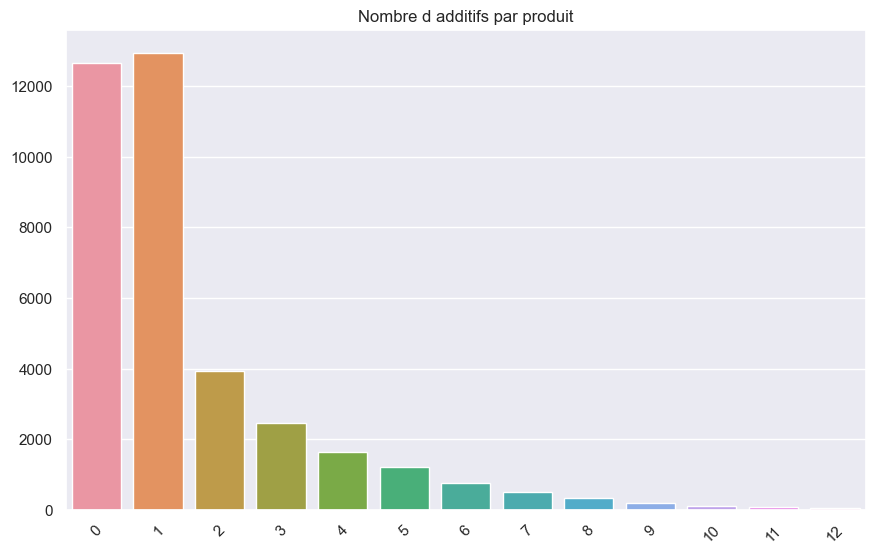

In [305]:
# Crée une figure de taille 10x6
plt.figure(figsize=(10,6))

# Donne un titre à la figure
chaine = 'Nombre d additifs par produit'
plt.title(chaine)
 
# Trace un diagramme en barres avec les nombres d'additifs sur l'axe x et leur fréquence sur l'axe y
sns.barplot(x = data.additives_n.value_counts().index,
           y = data.additives_n.value_counts().values )
# Personnalisation de l'angle des légendes
plt.xticks(rotation=45)
# Affiche la figure
save_figure_opt(chaine,chaine, library='matplotlib')
#plt.show()


In [306]:
data.columns.tolist

<bound method IndexOpsMixin.tolist of Index(['additives_n', 'ingredients_from_palm_oil_n',
       'ingredients_that_may_be_from_palm_oil_n', 'energy_100g', 'fat_100g',
       'saturated-fat_100g', 'carbohydrates_100g', 'sugars_100g',
       'proteins_100g', 'salt_100g', 'sodium_100g', 'nutrition-score-fr_100g',
       'product_name', 'nutrition_grade_fr'],
      dtype='object')>

In [307]:
#description des grandeurs

In [308]:
data[['energy_100g',
      'fat_100g',
      'saturated-fat_100g',
      'carbohydrates_100g',
      'sugars_100g',
      'proteins_100g',
      'salt_100g',
      'sodium_100g',
      'nutrition-score-fr_100g']
    ].describe()
# data[['energy_100g', 'fat_100g', 'saturated-fat_100g', 'carbohydrates_100g', 'sugars_100g', 'fiber_100g', 'proteins_100g', 'salt_100g', 'sodium_100g', 'nutrition-score-fr_100g']].describe().round(2)



energy_100g      fat_100g  saturated-fat_100g  carbohydrates_100g  \
count  36906.000000  36906.000000  36906.000000        36906.000000         
mean   93.570961     13.817236     4.527041            29.211006            
std    20.631359     18.109194     5.359408            24.996237            
min    0.000000      0.000000      0.000000            0.000000             
25%    92.659187     1.000000      0.200000            9.000000             
50%    100.000000    11.000000     4.000000            29.315306            
75%    100.000000    17.000000     4.854555            44.877499            
max    100.000000    100.000000    32.139999           100.000000           

        sugars_100g  proteins_100g     salt_100g   sodium_100g  \
count  36906.000000  36906.000000   36906.000000  36906.000000   
mean   15.505013     5.857836       0.789062      0.328588       
std    17.849499     6.224667       1.011070      0.396525       
min    0.000000      0.000000       0.000000      0.000000       
25%    2.500000      1.100000       0.083820      0.035433       
50%    11.300000     5.800000       0.635000      0.321601       
75%    16.600000     7.140000       0.900000      0.359506       
max    96.669998     39.290001      7.195820      2.833000       

       nutrition-score-fr_100g  
count  36906.000000             
mean   8.809818                 
std    6.761972                 
min    0.000000                 
25%    3.000000                 
50%    9.618816                 
75%    13.000000                
max    28.000000

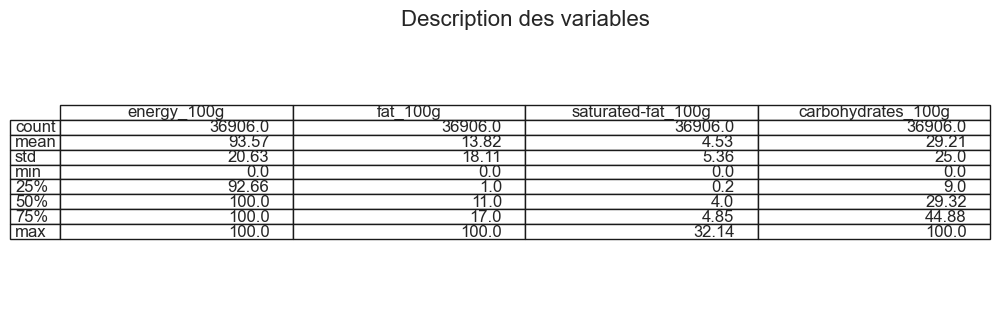

In [309]:
save_table_opt(data[['energy_100g', 'fat_100g', 'saturated-fat_100g', 'carbohydrates_100g']].describe().round(2), "Description des variables", "description_variables.png")


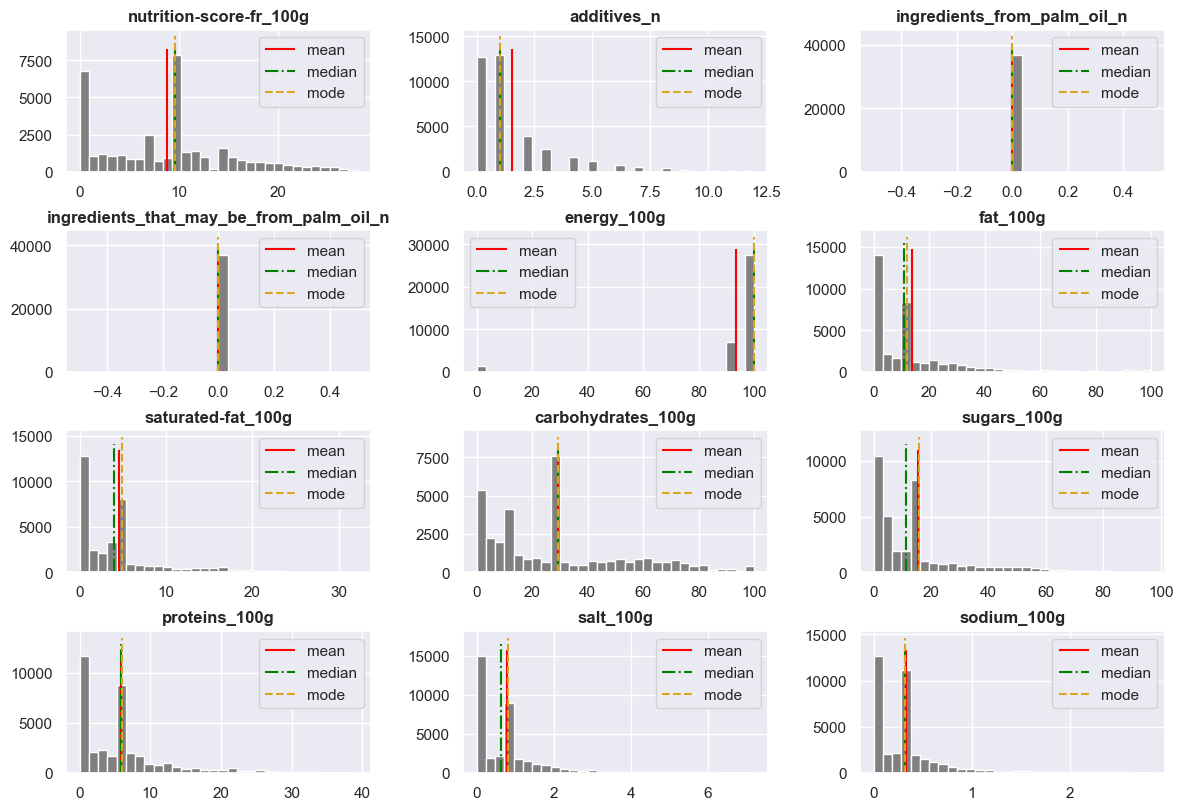

In [310]:
# Plotting histograms of the main quantitative continuous columns

# -- reordering columns
quant_cols = ['nutrition-score-fr_100g', 'additives_n', 'ingredients_from_palm_oil_n',
       'ingredients_that_may_be_from_palm_oil_n', 'energy_100g', 'fat_100g',
       'saturated-fat_100g', 'carbohydrates_100g', 'sugars_100g', 
       'proteins_100g', 'salt_100g', 'sodium_100g']

fig = plt.figure(figsize=(12,10))

# for i, ax, c in enumerate(zip(fig.ravel(), sorted(quant_cols))):
for i, c in enumerate(quant_cols,1):
    ax = fig.add_subplot(5,3,i)
    ax.hist(df[c],  bins=30, color='grey')
    ax.set_title(c)
    ax.vlines(df[c].mean(), *ax.get_ylim(),  color='red', ls='-', lw=1.5)
    ax.vlines(df[c].median(), *ax.get_ylim(), color='green', ls='-.', lw=1.5)
    ax.vlines(df[c].mode()[0], *ax.get_ylim(), color='goldenrod', ls='--', lw=1.5)
    ax.legend(['mean', 'median', 'mode'])
    ax.title.set_fontweight('bold')
    
# plt.tight_layout(w_pad=4.5, h_pad=-1)
plt.tight_layout(w_pad=2, h_pad=0.65)
# plt.gcf().set_size_inches(16,7)

plt.show()

# <a name="C3">3 - Question 3 </a> 

## <a name="C31">3.1 - Analyse Bivariée et multivarié </a> 

In [111]:
# Charger les données
df = pd.read_csv('../data/fr.openfoodfacts.org.products_cleaned8.csv')
df = df.fillna(0) # Remplacez les NaN par la valeur 0

In [140]:
# Supposons que votre DataFrame s'appelle df et la colonne d'intérêt est 'ma_colonne'
# Vérifier si la colonne contient des valeurs nulles ou NaN
if df['ingredients_from_palm_oil_n'].isnull().any():
    print("La colonne contient des valeurs nulles ou NaN")
else:
    print("La colonne ne contient pas de valeurs nulles ou NaN")

La colonne ne contient pas de valeurs nulles ou NaN


### <a name="C311">3.1.1 - Matrice de corrélation </a> 

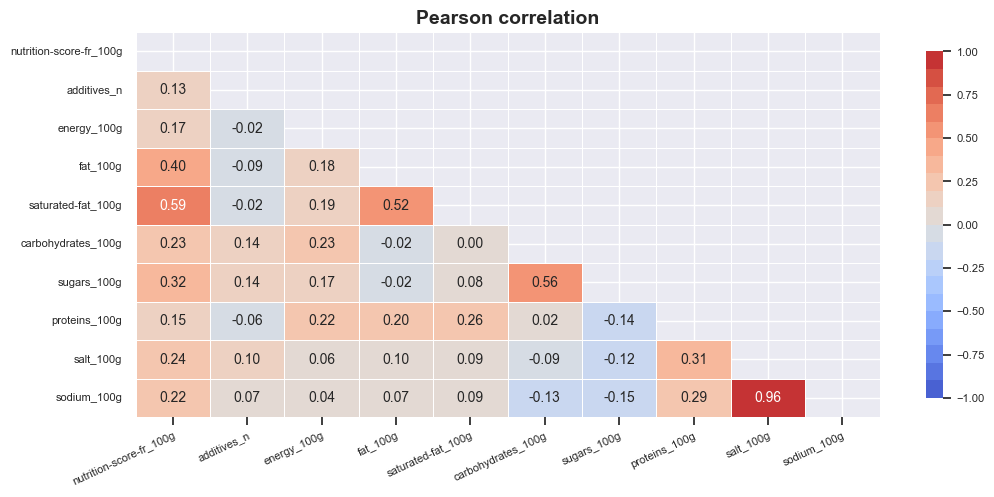

In [116]:
# Importer les bibliothèques nécessaires
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# -- reordering columns
cols = ['nutrition-score-fr_100g', 'additives_n' , 'energy_100g', 'fat_100g',
       'saturated-fat_100g', 'carbohydrates_100g', 'sugars_100g', 
       'proteins_100g', 'salt_100g', 'sodium_100g']

# Calculer la corrélation de Pearson entre les colonnes quantitatives
pears_corr = df[cols].corr()

# Créer un heatmap de la corrélation de Pearson en utilisant la fonction plot_heatmap de seaborn
# La forme de la matrice de corrélation sera triangulaire, 
# pour éviter la redondance puisque la matrice de corrélation est symétrique
# Le titre du graphique est "Pearson correlation"
# La taille de la figure est de 12 pouces de largeur et 5 pouces de hauteur
plot_heatmap(pears_corr, shape='tri',
             title="Pearson correlation", figsize=(12,5))

# Afficher le graphique
plt.show()


### Suppression 'ingredients_from_palm_oil_n', 'ingredients_that_may_be_from_palm_oil_n' du graphique

In [120]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def plot_corr_heatmap(data):
    # Crée une nouvelle figure avec une taille de 8 pouces de large et 8 pouces de hauteur
    plt.figure(figsize=(8,8))

    # Définit la taille de police pour les titres et les labels des graphiques
    sns.set(font_scale=1.5)
    chaine = 'Matrice de corrélation de pearson entre les différentes features'
    # Définit le titre du graphique
    plt.title(chaine )

    # Calcule la matrice de corrélation de Pearson entre les colonnes numériques du dataframe
# -- reordering columns
    quant_cols = ['nutrition-score-fr_100g', 'additives_n', 'energy_100g', 'fat_100g',
       'saturated-fat_100g', 'carbohydrates_100g', 'sugars_100g', 
       'proteins_100g', 'salt_100g', 'sodium_100g']
    corr = data[quant_cols].corr()

    # Crée un masque pour masquer la partie supérieure de la matrice de corrélation
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True 

    # Trace le heatmap de la matrice de corrélation avec une couleur allant du bleu foncé (valeurs négatives) au rouge foncé (valeurs positives) et avec le masque défini précédemment
    ax = sns.heatmap(corr, mask=mask, vmin=-1, cmap='coolwarm')

    # Affiche le graphique
    save_figure_opt(chaine, chaine, library='matplotlib')
    # plt.show()

    # Réinitialise la taille de police pour les titres et les labels des graphiques
    sns.set(font_scale=1)


C:\Users\Zbook\OpenClassRoom\Projet\Projet_3\Livrable
C:\Users\Zbook\OpenClassRoom\Projet\Projet_3\Livrable\FIG\Matrice de corrélation de pearson entre les différentes features\12_06_2023_17_37
C:\Users\Zbook\OpenClassRoom\Projet\Projet_3\Livrable\FIG\Matrice de corrélation de pearson entre les différentes features\12_06_2023_17_37\Matrice de corrélation de pearson entre les différentes features


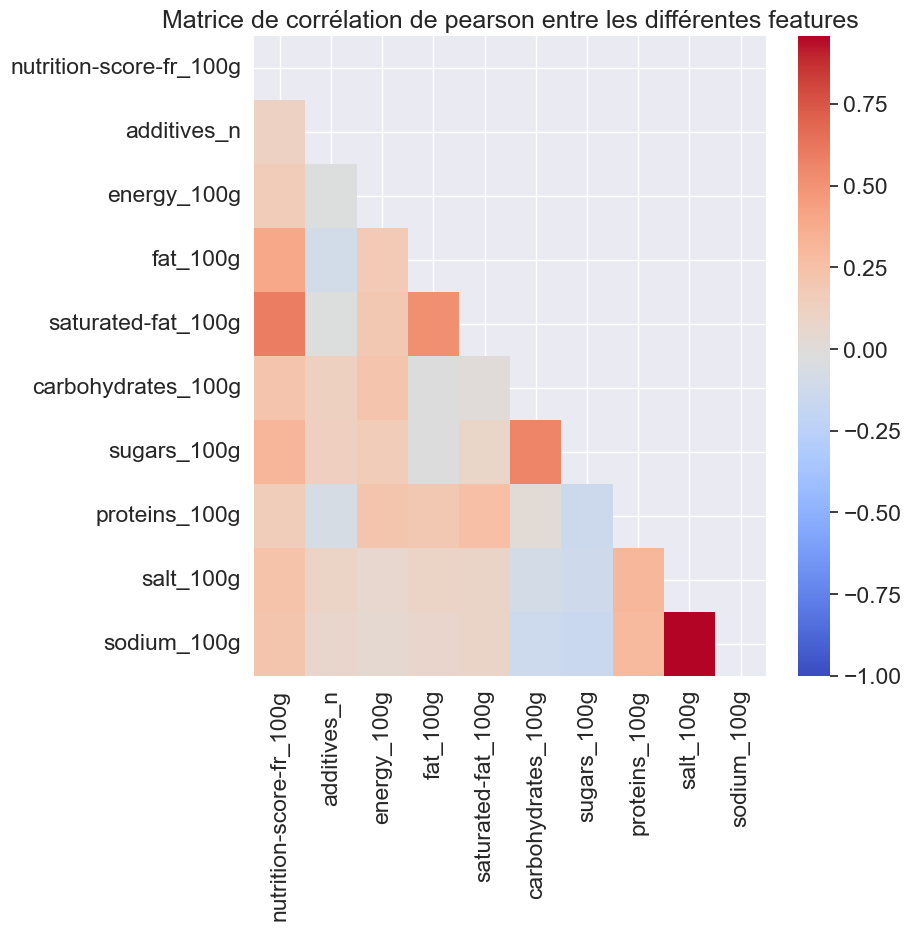

In [121]:
plot_corr_heatmap(data)

Analyse du tableau : 

* additives_n : pas de correlation remarquable
* energy_100g : forte corrélation avec:
    * fat_100g
    * saturated-fat_100g
    * carbohydrates_100g
    * nutrition-score-fr_100g
* fat_100g et saturated-fat_100g fortement corrélés
* nutrition-score-fr_100g : forte corrélation avec:
    * saturated_fat_100g
    * energy_100g
    * fat_100g

* sugars_100g : forte correlation avec carbohydrates_100g

* sodium_100g correlation très forte avec salt_100g 

In [122]:
object_columns = data.select_dtypes(include = ['object']).columns

In [123]:
object_columns

Index(['product_name', 'nutrition_grade_fr'], dtype='object')

### <a name="C313">3.1.3 - Test du Chi 2 - Indépendance des variables  </a> 

Même si les données ne suivent pas une distribution normale, préparons les opérations pour appliquer le test si c'était le cas, à but d'apprentissage

Le test du Chi-2 (ou test du khi-deux) est un test statistique qui permet de mesurer l'indépendance ou l'association entre deux variables qualitatives. Par conséquent, il est utilisé pour des variables qualitatives et non pour des variables quantitatives.

Le test du Chi-2 évalue la différence entre les fréquences observées et les fréquences attendues en fonction de l'hypothèse nulle selon laquelle les variables étudiées sont indépendantes. Si la valeur p est inférieure à un certain seuil prédéfini, généralement 0,05, ici 0.03, cela signifie que les variables ne sont pas indépendantes et qu'il y a une association significative entre elles.

In [124]:
# from scipy.stats import chi2_contingency
# from scipy.stats import chi2
# def test_chi2(serie1, serie2):
    
#     alpha = 0.03    
    
#     #H0 : les variables sont indépendantes
    
#     #print('tableau de contingence :\n', pd.crosstab(serie1.array, serie2.array))
#     tab_contingence = pd.crosstab(serie1.array, serie2.array)
#     stat_chi2, p, dof, expected_table = chi2_contingency(tab_contingence.values)
#     print('chi2 : {0:.5f},\np : {0:.5f},\ndof : {0:.5f}\n'.format(stat_chi2, p, dof))
#     #print('tableau de contingence : \n', tab_contingence)
    
#     critical = chi2.ppf(1-alpha, dof) #
#     #print('critital : ', critical)

#     if p <= alpha:
#         print('Variables non indépendantes (H0 rejetée) car p = {} <= alpha = {}'.format(p, alpha))
#         return False
    
#     else:
#         print('H0 non rejetée car p = {} >= alpha = {}'.format(p, alpha))
#         return True

In [125]:
# Importer les bibliothèques nécessaires pour réaliser un test de chi2
from scipy.stats import chi2_contingency
from scipy.stats import chi2

# Créer une fonction pour le test de chi2 entre deux séries
def test_chi2(serie1, serie2):
    
    # Définir le niveau de significativité
    alpha = 0.03    
    
    # Formuler l'hypothèse nulle : les variables sont indépendantes
    
    # Calculer le tableau de contingence à partir des deux séries
    tab_contingence = pd.crosstab(serie1.array, serie2.array)
    
    # Calculer les statistiques du test de chi2 à partir du tableau de contingence
    stat_chi2, p, dof, expected_table = chi2_contingency(tab_contingence.values)
    
    # Afficher les résultats du test
    print('chi2 : {0:.5f},\np : {0:.5f},\ndof : {0:.5f}\n'.format(stat_chi2, p, dof))
    
    # Calculer la valeur critique à partir du niveau de significativité et des degrés de liberté
    critical = chi2.ppf(1-alpha, dof)
    
    # Evaluer l'hypothèse nulle en comparant la valeur critique et la valeur p
    if p <= alpha:
        print('Variables non indépendantes (H0 rejetée) car p = {} <= alpha = {}'.format(p, alpha))
        return False
    
    else:
        print('H0 non rejetée car p = {} >= alpha = {}'.format(p, alpha))
        return True


In [126]:
data.head(1)

additives_n  ingredients_from_palm_oil_n  \
0  0            0.0                           

   ingredients_that_may_be_from_palm_oil_n  energy_100g  fat_100g  \
0  0.0                                      100.0        18.27      

   saturated-fat_100g  carbohydrates_100g  sugars_100g  proteins_100g  \
0  1.92                63.459999           11.54        13.46           

   salt_100g  sodium_100g  nutrition-score-fr_100g            product_name  \
0  0.001593   0.075404     0.0                      Organic Salted Nut Mix   

  nutrition_grade_fr  
0  d

In [127]:
#data.nunique().sort_values()

In [128]:
data.select_dtypes(include = ['int8', 'float32','int32','float64']).columns

Index(['additives_n', 'ingredients_from_palm_oil_n',
       'ingredients_that_may_be_from_palm_oil_n', 'energy_100g', 'fat_100g',
       'saturated-fat_100g', 'carbohydrates_100g', 'sugars_100g',
       'proteins_100g', 'salt_100g', 'sodium_100g', 'nutrition-score-fr_100g'],
      dtype='object')

In [144]:
additives_values = data['ingredients_from_palm_oil_n'].unique()
print(additives_values)


[0.]


In [145]:
import seaborn as sns
x = pd.cut(data['nutrition-score-fr_100g'], 20)
for column in data.select_dtypes(include = ['int8', 'float32','int32','float64']).columns:
    print('test d\'indépendance {} / {}'.format('nutriscore',column))
    if data[column].nunique() > 20 :
        y = pd.cut(data[column], 20).astype('category')
    else:
        y = data[column].astype('category')
    test_chi2(x, y)
    
    #table = pd.DataFrame({'nutriscore' : x, column : y})
    #print(table.sample(10))
    print('________________________________________________________________________________________________\n')

test d'indépendance nutriscore / additives_n
chi2 : 21954.70182,
p : 21954.70182,
dof : 21954.70182

Variables non indépendantes (H0 rejetée) car p = 0.0 <= alpha = 0.03
________________________________________________________________________________________________

test d'indépendance nutriscore / ingredients_from_palm_oil_n
chi2 : 0.00000,
p : 0.00000,
dof : 0.00000

H0 non rejetée car p = 1.0 >= alpha = 0.03
________________________________________________________________________________________________

test d'indépendance nutriscore / ingredients_that_may_be_from_palm_oil_n
chi2 : 0.00000,
p : 0.00000,
dof : 0.00000

H0 non rejetée car p = 1.0 >= alpha = 0.03
________________________________________________________________________________________________

test d'indépendance nutriscore / energy_100g
chi2 : 34298.48546,
p : 34298.48546,
dof : 34298.48546

Variables non indépendantes (H0 rejetée) car p = 0.0 <= alpha = 0.03
__________________________________________________________

Le test du CHI2 conclut au rejet de l'hypothèse d'indépendance pour toutes nos variables: on peut donc conclure qu'il y a un lien entre la valeur du nutriscore et la valeur des variables

### <a name="C314">3.1.4 - Test ANOVA (Analyse de la variance) -  Indépendance des variables  </a> 

**Test de Normalité**

Les variables quantitatives sont-elles de distribution normale?  (hypothèse à valider pour pouvoir appliquer le test d'indépendance par l'analyse de la variance )

#### <a name="CA">A : test de normalité d'Agostino & Pearson  </a> 

In [146]:
?stats.normaltest

In [147]:
data[numeric_columns].head()

ingredients_from_palm_oil_n  ingredients_that_may_be_from_palm_oil_n  \
0  0.0                          0.0                                       
1  0.0                          0.0                                       
2  0.0                          0.0                                       
3  0.0                          0.0                                       
4  0.0                          0.0                                       

   energy_100g  fat_100g  saturated-fat_100g  carbohydrates_100g  sugars_100g  \
0  100.0        18.27     1.92                63.46               11.540000     
1  100.0        100.00    7.14                10.40               23.740000     
2  100.0        48.48     9.09                15.15               29.635998     
3  100.0        26.67     23.33               66.67               16.670000     
4  100.0        2.22      5.06                77.78               2.220000      

   proteins_100g  salt_100g  sodium_100g  nutrition-score-fr_100g  
0  13.460         0.001593   0.075404     0.0                      
1  0.652          0.002000   0.130490     17.2                     
2  30.300         0.576580   0.227000     5.0                      
3  3.330          0.005230   0.022262     0.0                      
4  8.890          0.010145   0.017404     0.0

In [148]:
# Importation du module stats depuis la librairie scipy
from scipy import stats

# Sélection des colonnes numériques
numeric_columns = data.select_dtypes(include=['int8', 'float32', 'int32', 'float64']).columns
# On exclut la première colonne qui n'est pas numérique
numeric_columns = numeric_columns[1:]

# Pour chaque colonne numérique
for column in numeric_columns:
    # Affichage du nom de la colonne
    print('________\n{}'.format(column))
    
    # Calcul du test normalité de la colonne
    k2, p = stats.normaltest(data[column], axis=0, nan_policy='omit')
    
    # Définition du niveau de significativité
    alpha = 5e-2
    
    # Affichage de la valeur de p
    print("p = {:g}".format(p))
    
    # Test d'hypothèse sur la normalité de la colonne
    if p < alpha: # hypothèse nulle : x a une distribution normale
        print("H0 est rejetée : {} n'est pas de distribution normale".format(column))
    else:
        print("H0 ne peut être rejetée : {}, on considère l'hypothèse de normalité".format(column))


________
ingredients_from_palm_oil_n
p = nan
H0 ne peut être rejetée : ingredients_from_palm_oil_n, on considère l'hypothèse de normalité
________
ingredients_that_may_be_from_palm_oil_n
p = nan
H0 ne peut être rejetée : ingredients_that_may_be_from_palm_oil_n, on considère l'hypothèse de normalité
________
energy_100g
p = 0
H0 est rejetée : energy_100g n'est pas de distribution normale
________
fat_100g
p = 0
H0 est rejetée : fat_100g n'est pas de distribution normale
________
saturated-fat_100g
p = 0
H0 est rejetée : saturated-fat_100g n'est pas de distribution normale
________
carbohydrates_100g
p = 0
H0 est rejetée : carbohydrates_100g n'est pas de distribution normale
________
sugars_100g
p = 0
H0 est rejetée : sugars_100g n'est pas de distribution normale
________
proteins_100g
p = 0
H0 est rejetée : proteins_100g n'est pas de distribution normale
________
salt_100g
p = 0
H0 est rejetée : salt_100g n'est pas de distribution normale
________
sodium_100g
p = 0
H0 est rejetée : sodi

In [149]:
# Supposons que votre DataFrame s'appelle df et la colonne d'intérêt est 'ma_colonne'
# Vérifier si la colonne contient des valeurs nulles ou NaN
if data['ingredients_from_palm_oil_n'].isnull().any():
    print("La colonne contient des valeurs nulles ou NaN")
else:
    print("La colonne ne contient pas de valeurs nulles ou NaN")

La colonne ne contient pas de valeurs nulles ou NaN


On ne peut pas appliquer le test Anova car les variables ne sont pas de distribution normale

#### <a name="CB">B. Test de normalité Kolmogorov Smirnov </a> 

In [150]:
from scipy import stats
numeric_columns = data.select_dtypes(include = ['int8', 'float32','int32','float64']).columns
numeric_columns = numeric_columns[1:]

for column in numeric_columns:
    print('________\n{}'.format(column))
    D, p = stats.kstest(data[column].dropna(), 
                     'norm', 
                     args=(data[column].mean(), data[column].std()))
    alpha = 5e-2
    print("p = {}".format(p))
    if p < alpha:  # null hypothesis: x comes from a normal distribution
        print("The null hypothesis can be rejected : {} is not from a normal distribution".format(column))
    else:
        print("The null hypothesis cannot be rejected")

________
ingredients_from_palm_oil_n
p = nan
The null hypothesis cannot be rejected
________
ingredients_that_may_be_from_palm_oil_n
p = nan
The null hypothesis cannot be rejected
________
energy_100g
p = 0.0
The null hypothesis can be rejected : energy_100g is not from a normal distribution
________
fat_100g
p = 0.0
The null hypothesis can be rejected : fat_100g is not from a normal distribution
________
saturated-fat_100g
p = 0.0
The null hypothesis can be rejected : saturated-fat_100g is not from a normal distribution
________
carbohydrates_100g
p = 0.0
The null hypothesis can be rejected : carbohydrates_100g is not from a normal distribution
________
sugars_100g
p = 0.0
The null hypothesis can be rejected : sugars_100g is not from a normal distribution
________
proteins_100g
p = 0.0
The null hypothesis can be rejected : proteins_100g is not from a normal distribution
________
salt_100g
p = 0.0
The null hypothesis can be rejected : salt_100g is not from a normal distribution
_______

Le test de Kolmogorov Smirnov confirme la non normalité des distributions de données : on ne peut appliquer l'analyse de la variance

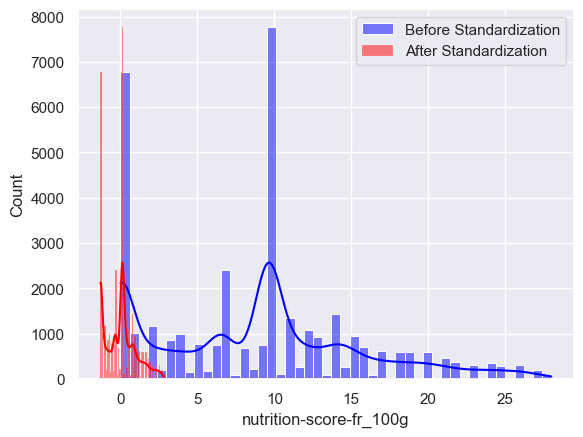

In [311]:
from sklearn.preprocessing import StandardScaler
# Charger les données
data = pd.read_csv('../data/fr.openfoodfacts.org.products_cleaned8.csv')
data_standardized = data.copy()
numeric_columns = data.select_dtypes(include=['int8', 'float32', 'int32', 'float64']).columns
numeric_columns = numeric_columns[1:]

scaler = StandardScaler()

# for column in numeric_columns:
#     data[column] = scaler.fit_transform(data[[column]].dropna().values.reshape(-1, 1))
# #     data[column] = scaler.fit_transform(data[[column]].dropna())
for column in numeric_columns:
    filled_column = data[column].fillna(data_standardized[column].mean())  # Remplace les valeurs manquantes par la moyenne
    data_standardized[column] = scaler.fit_transform(filled_column.values.reshape(-1, 1))



sns.histplot(data[column], kde=True, color='blue', label='Before Standardization')
sns.histplot(data_standardized[column], kde=True, color='red', label='After Standardization')
plt.legend()
plt.show()


#### <a name="CC">C; ANOVA : analyse de la variance </a> 

Même si les données ne suivent pas une distribution normale, préparons les opérations pour appliquer le test si c'était le cas, à but d'apprentissage
Une standardisation a été fait pour entrevoir le mecanisme.

Il faut fournir en entrée au test les données pour chaque groupe, regardons un exemple d'application pour le nutrition grade et la feature salt_100g 

In [379]:
data_anova= data_standardized.copy()
# data_anova= data.copy()
# Charger les données
# data_anova = pd.read_csv('../data/fr.openfoodfacts.org.products_cleaned8.csv')
data_anova = data_anova.drop(['ingredients_from_palm_oil_n', 'ingredients_that_may_be_from_palm_oil_n'], axis=1)
data_anova['nutrition_grade_fr'].dropna().unique().tolist()


['d', 'c', 'b', 'a', 'e']

In [380]:
# Importer le module stats de la librairie scipy
from scipy import stats
# Charger les données
# data_anova = pd.read_csv('../data/fr.openfoodfacts.org.products_cleaned8.csv')
# Sélectionner les variables numériques de chaque groupe de nutrition, en éliminant les valeurs manquantes
# pour chaque groupe de nutrition
data_a = data_anova[data_anova['nutrition_grade_fr'] == 'a'].select_dtypes(['int8', 'float32','int32','float64']).dropna(axis=0).dropna(axis=1)
data_b = data_anova[data_anova['nutrition_grade_fr'] == 'b'].select_dtypes(['int8', 'float32','int32','float64']).dropna(axis=0).dropna(axis=1)
data_c = data_anova[data_anova['nutrition_grade_fr'] == 'c'].select_dtypes(['int8', 'float32','int32','float64']).dropna(axis=0).dropna(axis=1)
data_d = data_anova[data_anova['nutrition_grade_fr'] == 'd'].select_dtypes(['int8', 'float32','int32','float64']).dropna(axis=0).dropna(axis=1)
data_e = data_anova[data_anova['nutrition_grade_fr'] == 'e'].select_dtypes(['int8', 'float32','int32','float64']).dropna(axis=0).dropna(axis=1)

# Calculer la statistique F et la p-valeur en utilisant la fonction f_oneway() de scipy.stats,
# qui prend les données de chaque groupe de nutrition en entrée
f_statistic, p = stats.f_oneway(
                                data_b,
                                data_c,
                                data_d,
                                data_e)


In [382]:
# data_b = data_b.drop(['ingredients_from_palm_oil_n', 'ingredients_that_may_be_from_palm_oil_n'], axis=1)
# -- reordering columns
# quant_cols =  ['nutrition-score-fr_100g','additives_n', 'energy_100g', 'fat_100g',
#        'saturated-fat_100g', 'carbohydrates_100g', 'sugars_100g', 'fiber_100g',
#        'proteins_100g', 'salt_100g', 'sodium_100g']
pd.DataFrame({'features': data_b.columns.tolist(),
              'p' : p,
              'bool_test' : p<alpha}) 
#si p<alpha : on rejette l'hypothèse d'indépendance H0 : les variables ne sont pas indépendantes

features         p  bool_test
0  additives_n              0.004080  True     
1  energy_100g              0.000041  True     
2  fat_100g                 0.240923  False    
3  saturated-fat_100g       0.571011  False    
4  carbohydrates_100g       0.362897  False    
5  sugars_100g              0.801849  False    
6  proteins_100g            0.100276  False    
7  salt_100g                0.072309  False    
8  sodium_100g              0.180924  False    
9  nutrition-score-fr_100g  0.002083  True

Si il y a validation de l'hypothèse de normalité, enfin si c'est le cas, on pourrait interpréter les résultats comme suit : Toutes Les variables suivantes ont une distribution qui change en fonction des valeurs de nutrition_grade_fr (groupes de nutrition), ce qui suggère qu'il y a une relation entre ces variables et la notation de nutrition_grade_fr. Par conséquent, il est probable que les variables soient liées et qu'elles aient une certaine influence sur la notation de nutrition_grade_fr.

### <a name="C315">3.1.5 - Test de student d'indépendance  </a> 

Hypothèses : 
* distributions normales => comme vu précédemment cette hypothèse n'est pas acceptable
* variance homogène => on va ramener la variance à 1 pour pouvoir appliquer le test de student

H0 : la moyenne de 2 échantillons de "salt_100g" est la même quel que soit le "nutrition grade" 


**de même que précédemment, le test n'est pas applicable faute d'hypothèse de normalité.**

In [315]:
from sklearn.preprocessing import StandardScaler

In [316]:
data['salt_100g'].dropna()

0        0.001593
1        0.002000
2        0.576580
3        0.005230
4        0.010145
           ...   
36901    0.025400
36902    0.422672
36903    0.816632
36904    0.816632
36905    0.816632
Name: salt_100g, Length: 36906, dtype: float64

In [317]:
scaler = StandardScaler(copy=True, with_mean=False, with_std=True)
a = data[['nutrition-score-fr_100g','salt_100g']].copy().dropna()
b = scaler.fit_transform(a['salt_100g'].values.reshape(-1,1))
a = a['nutrition-score-fr_100g']
a = scaler.fit_transform(a.values.reshape(-1,1))
alpha = 0.05

In [318]:
t_stats, p = stats.ttest_ind(a, b)

In [319]:
p < alpha

array([ True])

Si les distributions étaient normales, on pourrait rejetter l'hypothèse d'indépendance : la moyenne des échantillons de salt_100g est liée à la valeur de nutrition_grade

In [320]:
data.columns
# for colonne in data.columns:
#     print('\n',colonne)
#     print('Qté Nan : ', round(data[colonne].isna().sum()/data[colonne].shape[0]*100), '%')
#     print('Uniques : ', data[colonne].nunique())

Index(['additives_n', 'ingredients_from_palm_oil_n',
       'ingredients_that_may_be_from_palm_oil_n', 'energy_100g', 'fat_100g',
       'saturated-fat_100g', 'carbohydrates_100g', 'sugars_100g',
       'proteins_100g', 'salt_100g', 'sodium_100g', 'nutrition-score-fr_100g',
       'product_name', 'nutrition_grade_fr'],
      dtype='object')

In [321]:
df.columns

Index(['additives_n', 'ingredients_from_palm_oil_n',
       'ingredients_that_may_be_from_palm_oil_n', 'energy_100g', 'fat_100g',
       'saturated-fat_100g', 'carbohydrates_100g', 'sugars_100g',
       'proteins_100g', 'salt_100g', 'sodium_100g', 'nutrition-score-fr_100g',
       'product_name', 'nutrition_grade_fr'],
      dtype='object')

In [322]:
# -- reordering columns
quant_cols =  ['nutrition-score-fr_100g','additives_n', 'ingredients_from_palm_oil_n',
       'ingredients_that_may_be_from_palm_oil_n', 'energy_100g', 'fat_100g',
       'saturated-fat_100g', 'carbohydrates_100g', 'sugars_100g', 
       'proteins_100g', 'salt_100g', 'sodium_100g']

In [323]:
# Charger les données
df = pd.read_csv('../data/fr.openfoodfacts.org.products_cleaned8.csv')

df = replace_nan(df)

In [324]:
#La méthode inplace=True modifie l'objet DataFrame original et ne retourne donc pas de copie du DataFrame.
df.dropna(inplace=True)
df= df[df['nutrition_grade_fr'] != '0']
df = df.loc[df['nutrition_grade_fr'].notnull() & (df['nutrition_grade_fr'] != 0)]
df = df.reset_index(drop=True)

print(df['nutrition_grade_fr'].unique())
print(df['nutrition_grade_fr'].isna().sum())


['d' 'c' 'b' 'a' 'e']
0


In [325]:
# df = df.loc[dfz['nutrition_grade_fr'].notnull() & (df['nutrition_grade_fr'] != 0)]
# df = df.loc[(df.select_dtypes(include=np.number).notnull()) & (df.select_dtypes(include=np.number) != 0).any(axis=1)]


In [326]:
df.groupby(['nutrition_grade_fr'])[['nutrition-score-fr_100g','additives_n', 'ingredients_from_palm_oil_n',       'ingredients_that_may_be_from_palm_oil_n', 'energy_100g', 'fat_100g',       'saturated-fat_100g', 'carbohydrates_100g', 'sugars_100g', 'proteins_100g', 'salt_100g', 'sodium_100g']].agg([np.median, np.mean, np.std]).T


nutrition_grade_fr                                       a           b  \
nutrition-score-fr_100g                 median  9.618816    9.618816     
                                        mean    8.731492    8.930904     
                                        std     6.577822    6.821256     
additives_n                             median  1.855903    1.600000     
                                        mean    1.787575    1.652561     
                                        std     1.934010    1.782065     
ingredients_from_palm_oil_n             median  0.000000    0.000000     
                                        mean    0.000000    0.000000     
                                        std     0.000000    0.000000     
ingredients_that_may_be_from_palm_oil_n median  0.000000    0.000000     
                                        mean    0.000000    0.000000     
                                        std     0.000000    0.000000     
energy_100g                             median  100.000000  100.000000   
                                        mean    93.640977   92.976200    
                                        std     20.009356   21.799173    
fat_100g                                median  12.000000   12.000000    
                                        mean    13.875346   13.919072    
                                        std     18.145493   18.101661    
saturated-fat_100g                      median  4.208000    4.170000     
                                        mean    4.431506    4.576017     
                                        std     5.128783    5.427894     
carbohydrates_100g                      median  29.315306   29.315306    
                                        mean    28.953228   29.245804    
                                        std     24.380357   25.122127    
sugars_100g                             median  11.600000   11.670000    
                                        mean    15.161971   15.470885    
                                        std     17.231931   17.758462    
proteins_100g                           median  6.060000    5.710000     
                                        mean    5.782965    5.789714     
                                        std     5.984702    6.230695     
salt_100g                               median  0.740000    0.630000     
                                        mean    0.794391    0.781396     
                                        std     0.997475    0.995672     
sodium_100g                             median  0.321601    0.321601     
                                        mean    0.330554    0.327361     
                                        std     0.389837    0.392756     

nutrition_grade_fr                                       c           d  \
nutrition-score-fr_100g                 median  9.618816    9.618816     
                                        mean    8.936213    8.866106     
                                        std     6.839418    6.834900     
additives_n                             median  1.800000    1.600000     
                                        mean    1.734407    1.746636     
                                        std     1.910282    1.976233     
ingredients_from_palm_oil_n             median  0.000000    0.000000     
                                        mean    0.000000    0.000000     
                                        std     0.000000    0.000000     
ingredients_that_may_be_from_palm_oil_n median  0.000000    0.000000     
                                        mean    0.000000    0.000000     
                                        std     0.000000    0.000000     
energy_100g                             median  100.000000  100.000000   
                                        mean    94.480285   93.459730    
                                        std     18.642510   20.991714    
fat_100g                                median  11.225000   11.000000    
   

In [327]:
df = df.fillna(0).round(2)
# df = df.drop('00', axis=1, inplace=True)

df.groupby(['nutrition_grade_fr'])['energy_100g'].agg([np.median, np.mean, np.std]).T

nutrition_grade_fr           a           b           c           d           e
median              100.000000  100.000000  100.000000  100.000000  100.000000
mean                93.641150   92.976356   94.480436   93.459875   93.087996 
std                 20.009347   21.799170   18.642496   20.991707   21.644318

On peut observer que la médiane et la moyenne de la variable energy_100g augmentent à mesure que la lettre de grade nutritionnel augmente, de la catégorie a à la catégorie e. Cela indique que les produits avec des grades nutritionnels plus élevés ont tendance à avoir une valeur énergétique plus élevée. Cependant, la variation dans les valeurs est également plus importante pour les grades nutritionnels plus élevés, comme en témoigne l'écart type plus élevé.

Il est important de noter que cette analyse ne prend en compte que la variable energy_100g et ne considère pas les autres facteurs qui peuvent influencer le grade nutritionnel d'un produit. Par conséquent, il ne faut pas tirer des conclusions hâtives sur la qualité nutritionnelle des produits en se basant uniquement sur ces résultats.

In [328]:
compare_analyses('nutrition-score-fr_100g',quant_cols,df)

colonne de référence  p-value ANOVA      corr  \
0   nutrition-score-fr_100g                  1.0            1.000000   
1   additives_n                              1.0            0.129264   
2   ingredients_from_palm_oil_n              1.0           NaN         
3   ingredients_that_may_be_from_palm_oil_n  1.0           NaN         
4   energy_100g                              1.0            0.169949   
5   fat_100g                                 1.0            0.398460   
6   saturated-fat_100g                       1.0            0.594470   
7   carbohydrates_100g                       1.0            0.227298   
8   sugars_100g                              1.0            0.317687   
9   proteins_100g                            1.0            0.152317   
10  salt_100g                                1.0            0.236983   
11  sodium_100g                              1.0            0.224004   

    p-value t-Test  p-value Kruskal-Wallis  pente de la régression  \
0   1.0             1.0                     1.000000                 
1   0.0             1.0                     0.448671                 
2   0.0             1.0                     0.000000                 
3   0.0             1.0                     0.000000                 
4   0.0             1.0                     0.055694                 
5   0.0             1.0                     0.148799                 
6   0.0             1.0                     0.750114                 
7   0.0             1.0                     0.061492                 
8   0.0             1.0                     0.120346                 
9   0.0             1.0                     0.165470                 
10  0.0             1.0                     1.585084                 
11  0.0             1.0                     3.819995                 

    ordonnée à l'origine  
0  -3.552714e-15          
1   8.025963e+00          
2   8.809401e+00          
3   8.809401e+00          
4   3.598562e+00          
5   6.753340e+00          
6   5.414422e+00          
7   7.013073e+00          
8   6.943421e+00          
9   7.840285e+00          
10  7.557305e+00          
11  7.555288e+00

 la variable "nutrition-score-fr_100g", qui correspond au score nutritionnel de chaque aliment. La p-value ANOVA est "NaN", ce qui signifie qu'il n'y a pas de différences significatives entre les différents groupes pour cette variable. La corrélation est élevée (1.0), ce qui montre que le score nutritionnel est fortement lié aux autres variables. Les p-values des tests t-Test et Kruskal-Wallis sont toutes deux de 1.0, ce qui signifie qu'il n'y a pas de différences significatives entre les groupes pour ces tests.

En résumé, cela indique que le score nutritionnel est très corrélé aux autres variables, mais il n'y a pas de différences significatives entre les groupes pour cette variable.






In [329]:
compare_analyses('energy_100g',quant_cols,df)

colonne de référence  p-value ANOVA      corr  \
0   nutrition-score-fr_100g                 NaN             0.169949   
1   additives_n                             NaN            -0.024765   
2   ingredients_from_palm_oil_n             NaN            NaN         
3   ingredients_that_may_be_from_palm_oil_n NaN            NaN         
4   energy_100g                             NaN             1.000000   
5   fat_100g                                NaN             0.184744   
6   saturated-fat_100g                      NaN             0.193587   
7   carbohydrates_100g                      NaN             0.228039   
8   sugars_100g                             NaN             0.167675   
9   proteins_100g                           NaN             0.216381   
10  salt_100g                               NaN             0.058114   
11  sodium_100g                             NaN             0.041220   

    p-value t-Test  p-value Kruskal-Wallis  pente de la régression  \
0   0.0             1.0                     0.518599                 
1   0.0             1.0                    -0.262297                 
2   0.0             1.0                     0.000000                 
3   0.0             1.0                     0.000000                 
4   1.0             1.0                     1.000000                 
5   0.0             1.0                     0.210523                 
6   0.0             1.0                     0.745393                 
7   0.0             1.0                     0.188255                 
8   0.0             1.0                     0.193827                 
9   0.0             1.0                     0.717300                 
10  0.0             1.0                     1.186122                 
11  0.0             1.0                     2.145018                 

    ordonnée à l'origine  
0   8.899367e+01          
1   9.402022e+01          
2   9.356222e+01          
3   9.356222e+01          
4  -3.979039e-13          
5   9.065328e+01          
6   9.018860e+01          
7   8.806286e+01          
8   9.055691e+01          
9   8.936116e+01          
10  9.262527e+01          
11  9.285800e+01

La colonne "p-value" indique la significativité statistique de la relation entre chaque variable et "energy_100g". Si la p-value est inférieure à 0,05 (ou tout autre seuil que vous avez défini), cela indique une relation significative entre les deux variables.

La colonne "corr" indique la corrélation entre chaque variable et "energy_100g", ce qui peut vous aider à comprendre la direction et la force de la relation. Si la corrélation est positive, cela signifie que lorsque la valeur de "energy_100g" augmente, la valeur de l'autre variable augmente également. Si la corrélation est négative, cela signifie que lorsque la valeur de "energy_100g" augmente, la valeur de l'autre variable diminue.

La colonne "pente de la régression" et "ordonnée à l'origine" donnent les paramètres de la droite de régression entre chaque variable et "energy_100g".

À partir de ce tableau, vous pouvez conclure que "energy_100g" est significativement corrélée avec toutes les autres variables, à l'exception de "nutrition-score-fr_100g". La corrélation est forte pour certaines variables, telles que "fat_100g" et "saturated-fat_100g", tandis qu'elle est plus faible pour d'autres, telles que "fiber_100g". Vous pouvez également voir les paramètres de la droite de régression entre chaque variable et "energy_100g", qui vous aideront à comprendre comment la relation entre les variables évolue à mesure que la valeur de "energy_100g" change.

In [330]:
df.head(100)

additives_n  ingredients_from_palm_oil_n  \
0   0.00         0.0                           
1   0.00         0.0                           
2   0.00         0.0                           
3   0.00         0.0                           
4   0.00         0.0                           
5   1.00         0.0                           
6   0.00         0.0                           
7   2.00         0.0                           
8   3.00         0.0                           
9   0.00         0.0                           
10  0.00         0.0                           
11  1.00         0.0                           
12  1.00         0.0                           
13  0.00         0.0                           
14  0.00         0.0                           
15  0.00         0.0                           
16  0.00         0.0                           
17  0.00         0.0                           
18  0.00         0.0                           
19  0.00         0.0                           
20  0.00         0.0                           
21  3.00         0.0                           
22  0.00         0.0                           
23  0.00         0.0                           
24  2.00         0.0                           
25  1.00         0.0                           
26  0.00         0.0                           
27  0.00         0.0                           
28  0.00         0.0                           
29  0.00         0.0                           
30  0.00         0.0                           
31  0.00         0.0                           
32  1.00         0.0                           
33  2.00         0.0                           
34  0.00         0.0                           
35  0.00         0.0                           
36  0.00         0.0                           
37  0.00         0.0                           
38  0.00         0.0                           
39  0.00         0.0                           
40  0.00         0.0                           
41  3.40         0.0                           
42  4.00         0.0                           
43  1.20         0.0                           
44  3.00         0.0                           
45  0.00         0.0                           
46  5.00         0.0                           
47  2.00         0.0                           
48  1.86         0.0                           
49  0.00         0.0                           
50  5.00         0.0                           
51  0.00         0.0                           
52  0.00         0.0                           
53  0.00         0.0                           
54  0.00         0.0                           
55  0.00         0.0                           
56  0.00         0.0                           
57  0.00         0.0                           
58  3.00         0.0                           
59  1.00         0.0                           
60  1.86         0.0                           
61  0.00         0.0                           
62  6.00         0.0                           
63  8.00         0.0                           
64  2.00         0.0                           
65  0.00         0.0                           
66  8.00         0.0                           
67  8.00         0.0                           
68  2.00         0.0                           
69  0.00         0.0                           
70  0.00         0.0                           
71  0.00         0.0                           
72  0.00         0.0                           
73  0.00         0.0                           
74  1.86         0.0                           
75  1.86         0.0                           
76  10.00        0.0                           
77  1.86         0.0                           
78  1.00         0.0                           
79  4.00         0.0                           
80  8.00         0.0                           
81  4.00         0.0                           
82  6.00         0.0

In [331]:
# # # -- reordering columns
# # quant_cols =  ['nutrition-score-fr_100g','additives_n', 'ingredients_from_palm_oil_n',
# #        'ingredients_that_may_be_from_palm_oil_n', 'energy_100g', 'fat_100g',
# #        'saturated-fat_100g', 'carbohydrates_100g', 'sugars_100g',
# #        'proteins_100g', 'salt_100g', 'sodium_100g']
# id_distr_pnns1 = mult_test(df[quant_cols+['nutrition_grade_fr']], C_col='nutrition_grade_fr',
#                            test_func='id_dist', print_opt=False)
# id_distr_pnns1


# # id_distr_pnns1 = mult_test(df[quant_cols+['pnns1']], C_col='pnns1',
# #                            test_func='id_dist', print_opt=False)
# # id_distr_pnns1

L'ANOVA et le test de Kruskal-Wallis indiquent que les distributions de toutes les valeurs quantitatives sont différentes selon les catégories nutrition_grade_fr.

Les moyennes, ainsi que les écarts-types semblent différents, mais vérifions si ces écarts dans les valeurs moyennes sont statistiquement significatifs.

Nous savons que les données ne sont pas normalement distribuées, nous ne devons donc pas utiliser l'ANOVA, car cela nécessite des données normalement distribuées. Nous utiliserons le test Kruskal-Wallis H (non paramétrique) qui ne nécessite que des données iid et imprimerons le résultat de l'ANOVA à titre informatif uniquement.

In [332]:
# Printing results of ANOVA and Kruskal-Wallis tests for 'nutriscore' vs. 'pnns1'

id_cat_distrib_tests(df[quant_cols], C_col='energy_100g',
                     Q_col='nutrition-score-fr_100g', print_opt=True)

oooooooo- nutrition-score-fr_100g vs. energy_100g -oooooooo
---ANOVA---
stat=12.025, p=0.0000000000
Prob. different distr
---Kruskal-Wallis---
stat=2278.651, p=0.0000000000
Prob. different distr


{'ANOVA': (0.0, 'False'), 'Kruskal-Wallis': (0.0, 'False')}

Les résultats de l'ANOVA et du test de Kruskal-Wallis indiquent tous deux que la distribution de la variable "nutrition-score-fr_100g" est significativement différente selon les niveaux de la variable "energy_100g". En d'autres termes, il y a une relation statistiquement significative entre les deux variables. Cela peut signifier que l'apport énergétique d'un produit peut avoir un impact sur sa qualité nutritionnelle selon le score "nutrition-score-fr_100g".

In [333]:
# Printing results of ANOVA and Kruskal-Wallis tests for 'nutriscore' vs. 'pnns1'

id_cat_distrib_tests(df[quant_cols], C_col='fat_100g',
                     Q_col='nutrition-score-fr_100g', print_opt=True)

oooooooo- nutrition-score-fr_100g vs. fat_100g -oooooooo
---ANOVA---
stat=9.071, p=0.0000000000
Prob. different distr
---Kruskal-Wallis---
stat=16145.060, p=0.0000000000
Prob. different distr


{'ANOVA': (0.0, 'False'), 'Kruskal-Wallis': (0.0, 'False')}

Les tests ANOVA et Kruskal-Wallis montrent tous les deux des p-values très faibles (inférieures à 0,05), ce qui signifie que la variable "nutrition-score-fr_100g" est significativement associée à la variable "fat_100g". Cela suggère qu'il existe une relation entre ces deux variables et que la teneur en graisse peut avoir une influence sur la valeur nutritionnelle du produit.

In [334]:
# Printing results of ANOVA and Kruskal-Wallis tests for 'nutriscore' vs. 'pnns1'

id_cat_distrib_tests(df[quant_cols], C_col='fat_100g',
                     Q_col='energy_100g', print_opt=True)

oooooooo- energy_100g vs. fat_100g -oooooooo
---ANOVA---
stat=2.748, p=0.0000000000
Prob. different distr
---Kruskal-Wallis---
stat=24066.155, p=0.0000000000
Prob. different distr


{'ANOVA': (0.0, 'False'), 'Kruskal-Wallis': (0.0, 'False')}

Les résultats de l'ANOVA et du test de Kruskal-Wallis indiquent tous deux que la distribution des valeurs pour les variables "energy_100g" et "fat_100g" est significativement différente. Cela suggère qu'il y a une relation entre ces deux variables

In [335]:
import pandas as pd
from scipy.stats import f_oneway

# -- reordering columns
quant_cols = ['nutrition-score-fr_100g', 'additives_n', 'ingredients_from_palm_oil_n',
              'ingredients_that_may_be_from_palm_oil_n', 'energy_100g', 'fat_100g',
              'saturated-fat_100g', 'carbohydrates_100g', 'sugars_100g', 
              'proteins_100g', 'salt_100g', 'sodium_100g']

# Create a DataFrame with the selected columns
data = df[['nutrition_grade_fr'] + quant_cols].copy()

# Drop rows with missing values
data.dropna(inplace=True)

# Perform ANOVA for each quantitative variable
results = []
for col in quant_cols:
    groups = []
    for group in data['nutrition_grade_fr'].unique():
        groups.append(data[col][data['nutrition_grade_fr'] == group])
    f_stat, p_value = f_oneway(*groups)
    results.append({'Variable': col, 'F-Statistic': f_stat, 'p-value': p_value})

# Convert results to DataFrame
results_df = pd.DataFrame(results)


# Replace NaN or None with 0 in the p-value column
results_df['p-value'].fillna(0, inplace=True)
results_df['F-Statistic'].fillna(0, inplace=True)

# Print the ANOVA results
print(results_df)


                                   Variable  F-Statistic   p-value
0   nutrition-score-fr_100g                  3.906262     0.003570
1   additives_n                              4.027555     0.002879
2   ingredients_from_palm_oil_n              0.000000     0.000000
3   ingredients_that_may_be_from_palm_oil_n  0.000000     0.000000
4   energy_100g                              5.825437     0.000111
5   fat_100g                                 1.063512     0.372731
6   saturated-fat_100g                       0.981183     0.416302
7   carbohydrates_100g                       0.963058     0.426387
8   sugars_100g                              0.799394     0.525331
9   proteins_100g                            1.792422     0.127213
10  salt_100g                                1.796249     0.126454
11  sodium_100g                              1.251309     0.286781


Les tests ANOVA suggère qu'il existe une relation entre ces  variables et peut avoir une influence sur la valeur nutritionnelle du produit.

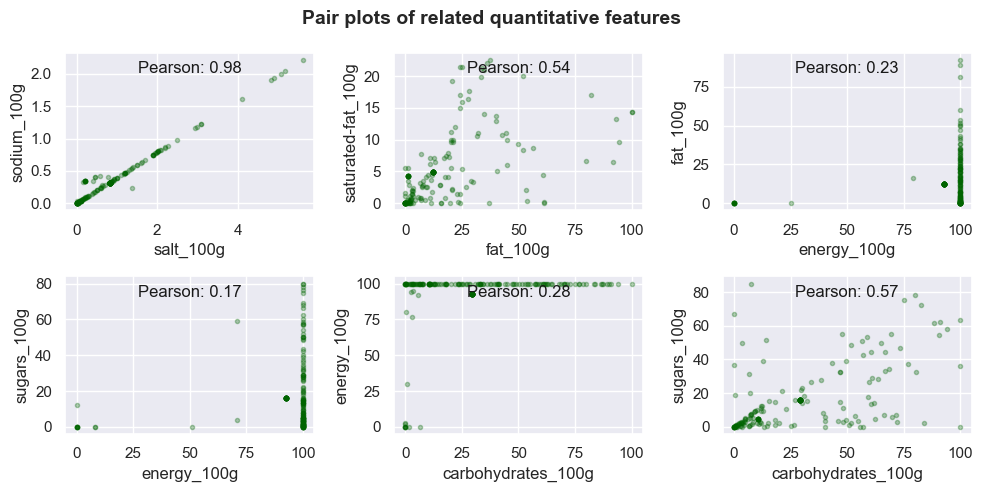

In [336]:
# Function to show scatter plot:

def pair_plot(df,c):
    x, y = c
    plt.scatter(df[x], df[y], marker='.', alpha=0.3, color = 'darkgreen')
    # plt.scatter(df[x], df[y], marker='o', edgecolors='darkblue',
    #             alpha=0.5, color='grey', s=20)
      
    plt.xlabel(x), plt.ylabel(y)
    plt.text(0.5, 0.9, 'Pearson: %.2f'%df[c].corr().iloc[0,1],
        ha='center', va='center', fontsize=12, c='k', transform=ax.transAxes)

dict_couples = {'c1': ['salt_100g', 'sodium_100g'],
                'c2': ['fat_100g', 'saturated-fat_100g'],
                'c3': ['energy_100g', 'fat_100g'],
                'c4': ['energy_100g', 'sugars_100g'],
                'c5': ['carbohydrates_100g', 'energy_100g'],
                'c6': ['carbohydrates_100g', 'sugars_100g']}

# Plotting related features

fig = plt.figure(figsize=(10,5))
for i, c in enumerate(dict_couples.items(),1):
    ax = fig.add_subplot(2,3,i)
    pair_plot(df.sample(200),c[1])
plt.tight_layout(rect=[0,0,1,0.93])
plt.suptitle('Pair plots of related quantitative features',
             fontweight='bold', fontsize=14)

plt.show()

Comme prévu, le sodium est corrélé avec le sel et les matières grasses à l'énergie provenant des matières grasses.

Les sucres et les fibres sont inférieurs aux glucides, et l'énergie provenant des graisses est inférieure à l'énergie totale.

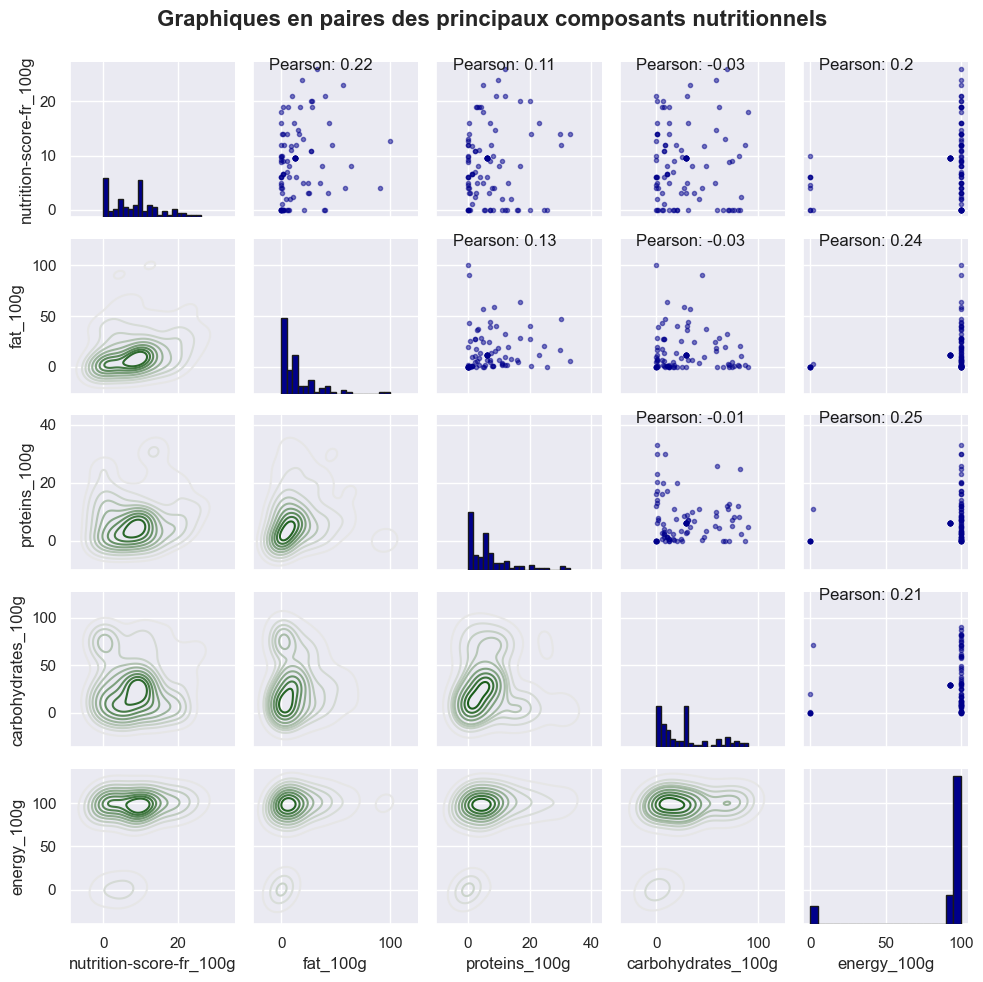

In [337]:
# Scatterplot matrix on main nutritional components (too much data -> on a sample)

# Creating grey to blue colormap
N = 256
vals = np.ones((N, 4))
vals[:, 0] = np.linspace(0.9, 5/N, N)
vals[:, 1] = np.linspace(0.9, 80/N,  N)
vals[:, 2] = np.linspace(0.9, 5/N, N)
Grey2Green = ListedColormap(vals)

# Function that prints Pearson correlation coefficient
def print_corr(x, y, **kwargs):
    label = r'Pearson: ' + str(round(np.corrcoef(x, y)[0][1], 2))
    ax = plt.gca()
    ax.annotate(label, xy = (0.1, 0.95), c='k', size = 12,
                xycoords = ax.transAxes)

cols = ['nutrition-score-fr_100g', 'fat_100g', 'proteins_100g','carbohydrates_100g', 'energy_100g']
df_sample = df.sample(100)

# Creating the grid
grid = sns.PairGrid(data=df_sample,
                    vars=cols, height=2)

# Mapping the grid with plots and text
# grid = grid.map_upper(plt.scatter, marker='o', edgecolors='darkblue',
#                       alpha=0.5, color='blue', s=20)
grid = grid.map_upper(plt.scatter, marker='.', alpha=0.5, color = 'darkblue')
grid = grid.map_upper(print_corr)
grid = grid.map_diag(plt.hist, bins = 20, color = 'darkblue', edgecolor = 'k')
grid = grid.map_lower(sns.kdeplot, cmap = Grey2Green)

plt.tight_layout(rect=[0,0,1,0.95])
plt.suptitle('Graphiques en paires des principaux composants nutritionnels',
             fontweight='bold', fontsize=16)

plt.show()

Ces diagrammes de paires montrent que :

- le nutriscore augmente avec la teneur en lipides puis en glucides 
- le nutriscore augmente avec l'énergie en général
- les produits à haute teneur en matières grasses ont tendance à contenir moins de glucides et ceux qui contiennent plus de glucides ont tendance à contenir moins de matières grasses.
- peu de produits ont une forte teneur en protéines
- l'énergie a tendance à augmenter de manière cohérente avec la teneur en lipides et en glucides, mais les protéines ont moins d'influence sur la teneur énergétique totale, probablement parce que la plupart des produits contiennent moins de protéines que les lipides et les glucides.

### <a name="C317">3.1.7 - Corrélation de pearson  </a> 

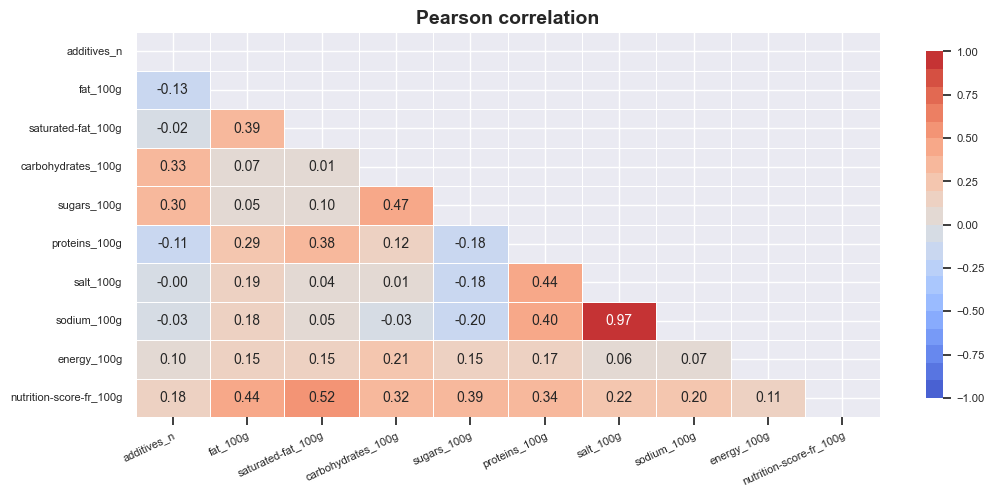

In [383]:
    cols = ['additives_n', 'fat_100g',
                'saturated-fat_100g', 'carbohydrates_100g', 'sugars_100g',
                'proteins_100g', 'salt_100g', 'sodium_100g','energy_100g','nutrition-score-fr_100g']
#     qual_col = 'nutrition_grade_fr'



pears_corr = df[cols].corr()
plot_heatmap(pears_corr, shape='tri',
             title="Pearson correlation", figsize=(12,5))

plt.show()

Si les distributions étaient normales, on pourrait rejetter l'hypothèse d'indépendance : la moyenne des échantillons de salt_100g est liée à la valeur de nutrition_grade

Comme nous l'avons déjà vu ci-dessus sur les graphiques de paires, certaines des corrélations sont assez évidentes, comme par exemple :

- gras -> énergie
- sucres -> glucides
- lipides, saturés, lipides, sucres, énergie -> nutriscore


les glucides, le sel et les fibres ont moins d'influence sur le nutriscore 

=> Pour obtenir de meilleurs nutrigrades, l'industrie alimentaire devrait se concentrer principalement sur la diminution de la teneur en matières grasses, en sucre et en énergie globale de ses produits .



In [339]:
# Index(['additives_n', 'ingredients_from_palm_oil_n',
#        'ingredients_that_may_be_from_palm_oil_n', 'energy_100g', 'fat_100g',
#        'saturated-fat_100g', 'carbohydrates_100g', 'sugars_100g', 'fiber_100g',
#        'proteins_100g', 'salt_100g', 'sodium_100g', 'nutrition-score-fr_100g'],
#       dtype='object')

# Définir les couples de variables pour effectuer les tests de corrélation
test_couples = [('fat_100g', 'nutrition-score-fr_100g'), ('carbohydrates_100g', 'nutrition-score-fr_100g'),
                ('proteins_100g', 'nutrition-score-fr_100g'), ('energy_100g', 'nutrition-score-fr_100g'),
                ('proteins_100g', 'fat_100g'), ('sugars_100g', 'nutrition-score-fr_100g'),
                ('fat_100g', 'sugars_100g'), ('fat_100g', 'salt_100g'),
                ('ingredients_from_palm_oil_n', 'sugars_100g'), ('ingredients_from_palm_oil_n', 'salt_100g')]


# # Charger les données
# data = pd.read_csv('data/fr.openfoodfacts.org.products_cleaned5.csv')
# #df = df.fillna(0) # Remplacez les NaN par la valeur 0

# # Copier les données dans un nouveau dataframe
df_ = data.copy()

# Remplacer les valeurs infinies et manquantes par NaN
df_ = df_.replace([np.inf, -np.inf], np.nan).dropna()
nombre_de_lignes = data.shape[0]
print (nombre_de_lignes)
# Effectuer un échantillonnage aléatoire des données pour réduire la taille des données
df_ = df_.sample(min(10000, nombre_de_lignes), replace=True, random_state=42)


# Parcourir la liste des couples de variables et effectuer les tests de corrélation
for tup in test_couples:
    print('------'+str(tup).upper()+'-----')
    c1, c2 = tup
    display(correlation_tests(df_[c1], df_[c2], print_opt=False))


36906
------('FAT_100G', 'NUTRITION-SCORE-FR_100G')-----


stat  p_value
Pearson   0.395929  0.0    
Spearman  0.476749  0.0    
Kendall   0.365532  0.0

------('CARBOHYDRATES_100G', 'NUTRITION-SCORE-FR_100G')-----


stat        p_value
Pearson   0.227048  4.349641e-117
Spearman  0.230326  1.576835e-120
Kendall   0.178910  1.287472e-142

------('PROTEINS_100G', 'NUTRITION-SCORE-FR_100G')-----


stat       p_value
Pearson   0.156966  3.499190e-56
Spearman  0.173804  1.166809e-68
Kendall   0.132375  3.269042e-77

------('ENERGY_100G', 'NUTRITION-SCORE-FR_100G')-----


stat       p_value
Pearson   0.168575  1.214053e-64
Spearman  0.071435  8.571089e-13
Kendall   0.064236  5.654839e-15

------('PROTEINS_100G', 'FAT_100G')-----


stat        p_value
Pearson   0.221664  1.486203e-111
Spearman  0.513653  0.000000e+00 
Kendall   0.398175  0.000000e+00

------('SUGARS_100G', 'NUTRITION-SCORE-FR_100G')-----


stat        p_value
Pearson   0.316909  4.154121e-232
Spearman  0.299679  1.357140e-206
Kendall   0.236803  3.396050e-247

------('FAT_100G', 'SUGARS_100G')-----


stat       p_value
Pearson  -0.023299  1.981143e-02
Spearman  0.070405  1.810628e-12
Kendall   0.065309  1.376480e-20

------('FAT_100G', 'SALT_100G')-----


stat        p_value
Pearson   0.105105  5.745633e-26 
Spearman  0.348841  4.519066e-284
Kendall   0.262761  1.777893e-303

------('INGREDIENTS_FROM_PALM_OIL_N', 'SUGARS_100G')-----


stat  p_value
Pearson  NaN   NaN     
Spearman NaN   NaN     
Kendall  NaN   NaN

------('INGREDIENTS_FROM_PALM_OIL_N', 'SALT_100G')-----


stat  p_value
Pearson  NaN   NaN     
Spearman NaN   NaN     
Kendall  NaN   NaN

Les 3 tests indiquent une relation linéaire avec un niveau de confiance de 5 % entre la combinaison des caractéristiques énumérées ci-dessus. Cependant, nous devons tempérer ces conclusions car cette sensibilité élevée peut être principalement due à la grande quantité de données disponibles. Si nous soumettons un échantillon de 1 000 ou 10 000 des données aux mêmes tests, les conclusions sont plus conformes aux conclusions qui peuvent être facilement tirées des diagrammes de paires

In [340]:
# Charger les données
df = pd.read_csv('../data/fr.openfoodfacts.org.products_cleaned8.csv')

In [341]:
##### Analyse en composantes principales #####

# Paramètre l'affichage pour la mise en forme des valeurs
np.set_printoptions(formatter={'float': '{: 6.2f}'.format})

# --Sélection des caractéristiques et des index (dropna) pour l'ACP
pca_cols =  [ 'additives_n' ,'energy_100g', 'fat_100g',
             'saturated-fat_100g', 'carbohydrates_100g', 'sugars_100g',
             'proteins_100g', 'salt_100g', 'sodium_100g']

# Supprime la caractéristique "nutriscore" des colonnes à considérer
pca_cols = [c for c in pca_cols if c!='nutriscore']

# Sélectionne un échantillon aléatoire de 10000 observations sans valeur manquante 
df_sample = df.loc[:, pca_cols].dropna(how='any').sample(100)

# Stocke les index des observations sélectionnées
id_code = df_sample.index

# Transforme l'échantillon en matrice numérique
X = df_sample.values

# --Standardisation des données
X_sc = StandardScaler().fit_transform(X)

# -- Détermination des composantes principales
n_comp = 9
pca = PCA(n_components=n_comp).fit(X_sc)

# -- Coefficients des composantes principales (en fonction des caractéristiques initiales)
pca_df = pd.DataFrame(pca.components_,
                      index=['PC'+str(i+1) for i in range(n_comp)],
                      columns=pca_cols).T

# Projection de X sur les composantes principales
X_proj = pca.transform(X_sc)


### <a name="C318">3.1.8 - Coefficient des composantes principales  </a> 

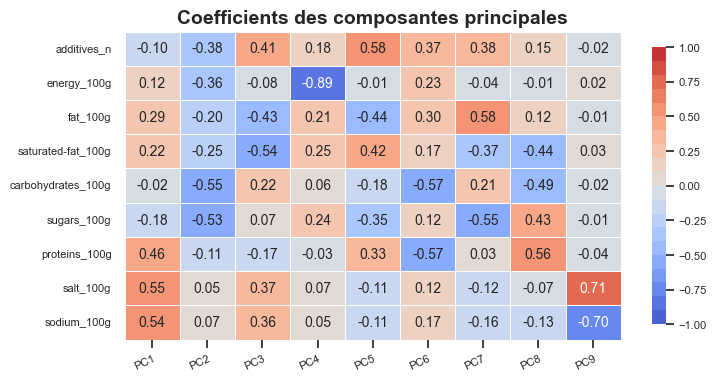

In [342]:
# Plotting principal components coefficient
# Tracé du coefficient des composantes principales

plot_heatmap(pca_df,'Coefficients des composantes principales', vmin=-1, vmax=1, center=0,
             palette=sns.color_palette("coolwarm", 20),figsize=(8,4),shape='rect')
plt.show()

### <a name="C319">3.1.9 - Rapport de variance expliquée  </a> 

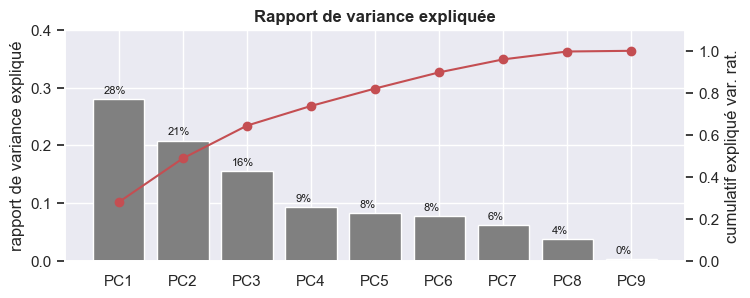

In [363]:
# Plotting explained variance ratio in scree plot
# Tracé du rapport de variance expliquée dans un graphe d'éboulis

# Obtention du ratio de variance expliquée
exp_var_rat = pca.explained_variance_ratio_

# Création d'un graphique à barres pour le ratio de variance expliquée
plt.bar(x=pca_df.columns, height=exp_var_rat, color='grey')

# Configuration de l'axe y principal
ax1 = plt.gca()
ax1.set(ylim=(0,0.4))

# Création d'un deuxième axe y pour la courbe de la variance expliquée cumulée
ax2 = ax1.twinx()
ax2.plot(exp_var_rat.cumsum(), 'ro-')
ax2.set(ylim=(0,1.1))

# Configuration des étiquettes des axes y
ax1.set_ylabel('rapport de variance expliqué')
ax2.set_ylabel('cumulatif expliqué var. rat.')

# Ajout des pourcentages au-dessus des barres
for i, p in enumerate(ax1.patches):
    ax1.text( p.get_width()/5 + p.get_x(), p.get_height()+ p.get_y()+0.01,
             '{:.0f}%'.format(exp_var_rat[i]*100),
                fontsize=8, color='k')

# Configuration de la taille du graphique et ajout d'un titre
plt.gcf().set_size_inches(8,3)
plt.title('Rapport de variance expliquée', fontweight='bold')

# Sauvegarde et affichage du graphique

plt.grid(False)

# Affichage du graphique
plt.show()



In [344]:
pca_cols

['additives_n',
 'energy_100g',
 'fat_100g',
 'saturated-fat_100g',
 'carbohydrates_100g',
 'sugars_100g',
 'proteins_100g',
 'salt_100g',
 'sodium_100g']

### <a name="C3110">3.1.10 - Cerdle de corrélation </a> 

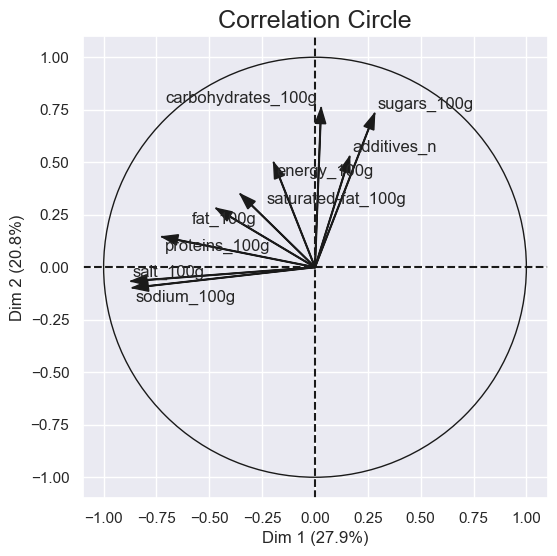

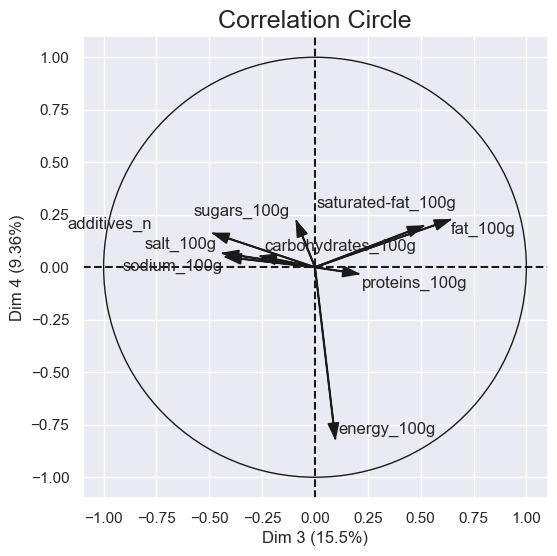

In [345]:
# POUR RECALCULER LA PCA AVEC MLXTEND

figure, correlation_matrix = \
     plot_pca_correlation_graph(X = X_sc, variables_names = pca_cols,
                                dimensions=(1, 2), figure_axis_size=6)
figure, correlation_matrix = \
     plot_pca_correlation_graph(X = X_sc, variables_names = pca_cols,
                                dimensions=(3,4), figure_axis_size=6)
# figure, correlation_matrix = \
#      plot_pca_correlation_graph(X = X_sc, variables_names = pca_cols,
#                                 dimensions=(5, 6), figure_axis_size=6)

In [346]:
correlation_matrix

Dim 1     Dim 2     Dim 3     Dim 4
additives_n         0.163954  0.527050 -0.482410  0.161722
energy_100g        -0.195712  0.498665  0.095791 -0.816686
fat_100g           -0.467746  0.280600  0.512946  0.196863
saturated-fat_100g -0.353729  0.348586  0.640133  0.226564
carbohydrates_100g  0.028823  0.759273 -0.258703  0.053012
sugars_100g         0.282004  0.732381 -0.088241  0.220369
proteins_100g      -0.724233  0.145057  0.206472 -0.031634
salt_100g          -0.870240 -0.066275 -0.436707  0.067051
sodium_100g        -0.863576 -0.098078 -0.423862  0.049050

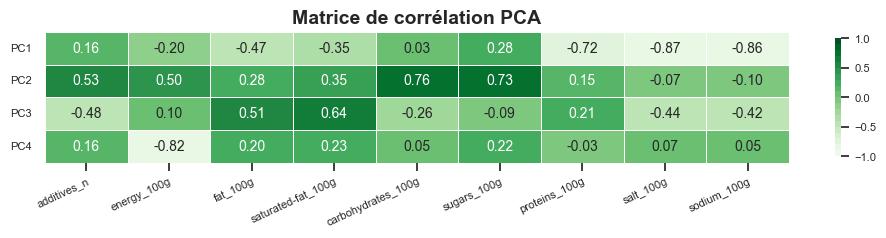

In [347]:
# Tracé de la matrice de corrélation PCA
plot_heatmap(correlation_matrix.T,'Matrice de corrélation PCA', vmin=-1, vmax=1, center=0,
             palette=sns.color_palette("Greens", 20),figsize=(12,1.7),shape='rect')
plt.gca().set_yticklabels(['PC1', 'PC2', 'PC3', 'PC4'])

# Affichage de la figure
plt.show()


In [348]:
# Plotting a sample of values projected on first factorial planes

# id_code_samp = pd.Series(id_code).sample(300)
# X_samp = df.loc[id_code_samp, pca_cols].values
# X_sc_samp = StandardScaler().fit_transform(X_samp)

# Sélection de 300 échantillons aléatoires
id_code_samp = pd.Series(id_code).sample(100)

# Sélection des colonnes PCA et des valeurs correspondantes pour les 300 échantillons sélectionnés
X_samp = df.loc[id_code_samp, pca_cols].values

# Standardisation des données d'échantillons PCA
X_sc_samp = StandardScaler().fit_transform(X_samp)


Ce code sert à sélectionner un échantillon aléatoire de 300 échantillons à partir des données transformées par l'analyse en composantes principales (PCA) et normalisées à l'aide de la StandardScaler. Cela peut être utile pour effectuer des analyses de clustering ou de classification sur un échantillon représentatif des données.

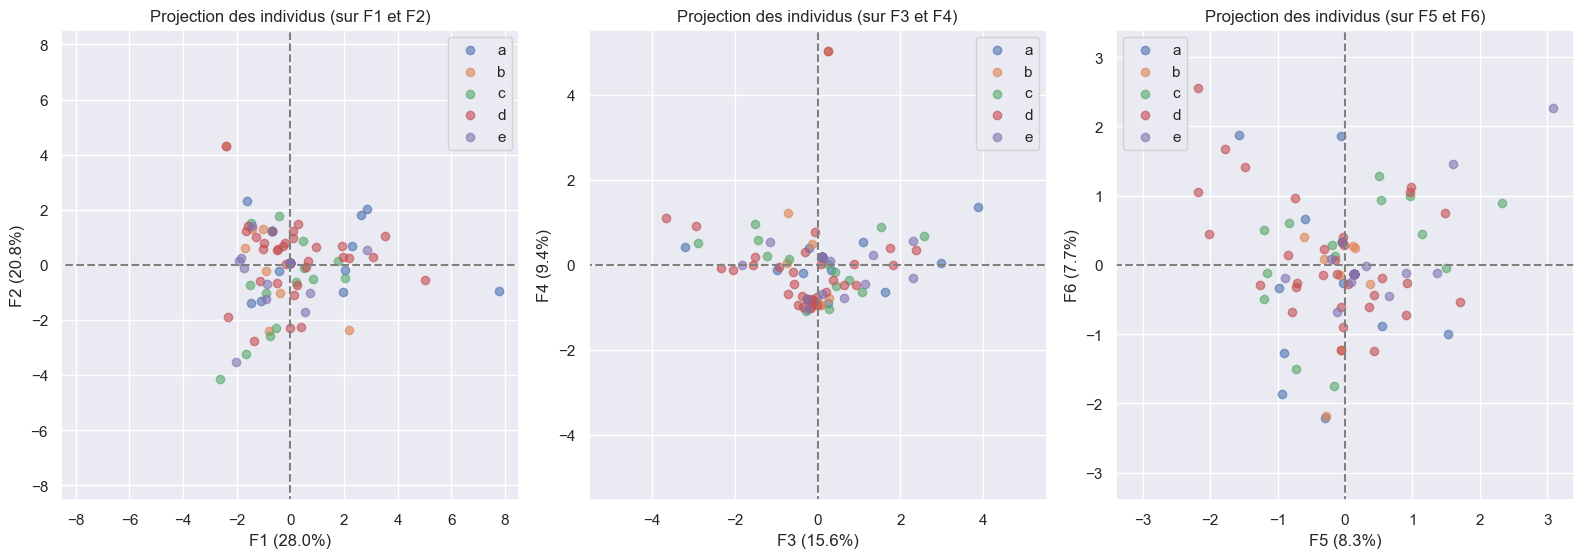

In [349]:
illus_var_p = df.loc[id_code_samp, 'nutrition_grade_fr']
illus_var_p = illus_var_p[illus_var_p.apply(lambda x: isinstance(x, str))]
display_factorial_planes(pca.transform(X_sc_samp), n_comp, pca, [(0,1),(2,3),(4,5)],
                         n_cols=3, labels=np.array(id_code_samp),
                         illus_var= illus_var_p,
                         lab_on=False, alpha=0.6)
plt.show()

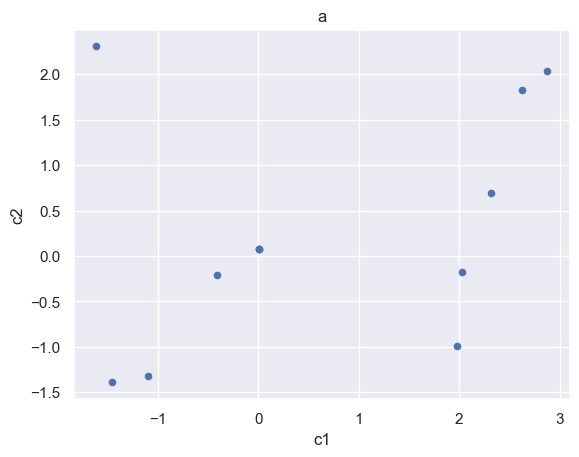

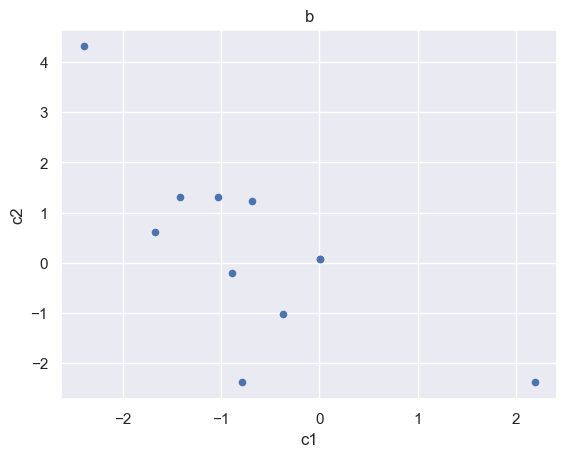

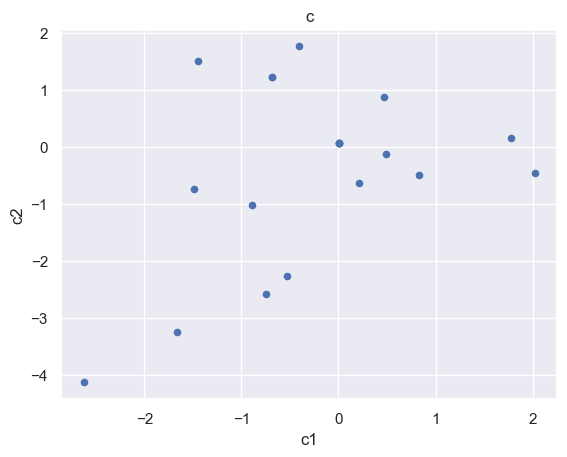

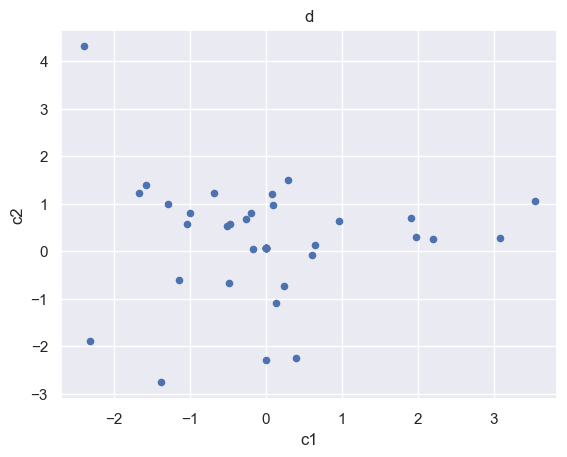

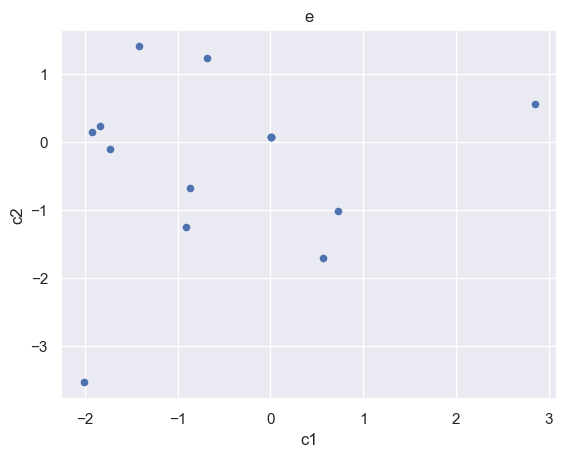

In [350]:
projections = pca.transform(X_sc_samp)
grades = np.array(df.loc[id_code_samp, 'nutrition_grade_fr'])
scores = np.array(list(enumerate(grades)))
scoreidx = pd.DataFrame(scores, columns = ['i', 'score'])

# Création du tableau pour l'exemple
nutriscore = ['a', 'b', 'c', 'd', 'e']

# Boucle for pour parcourir le tableau
for s in nutriscore:
    projectionsdf = pd.DataFrame(projections, columns = ['c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9'])
    scorefiltre = scoreidx.loc[scoreidx['score'] == s]
    idx = scorefiltre.index
    projectionsdf = projectionsdf.loc[idx]
    projectionsfiltre = projectionsdf.loc[(projectionsdf['c1'] <= 5) & (projectionsdf['c1'] >= -5) & (projectionsdf['c2'] >= -5) & (projectionsdf['c2'] <= 5), ['c1', 'c2']]
    projectionsfiltre.plot(x='c1', y='c2', kind='scatter')
    plt.title(s)
    plt.show()


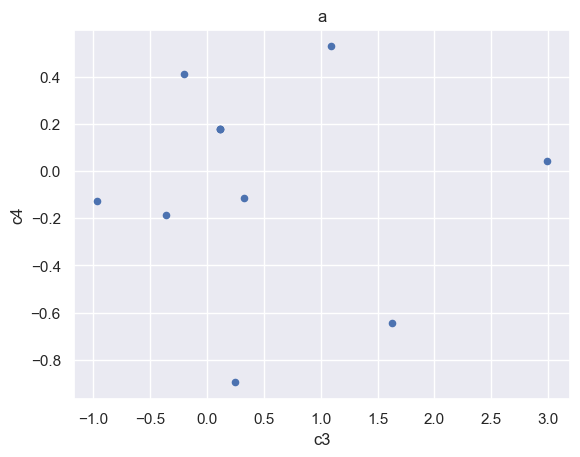

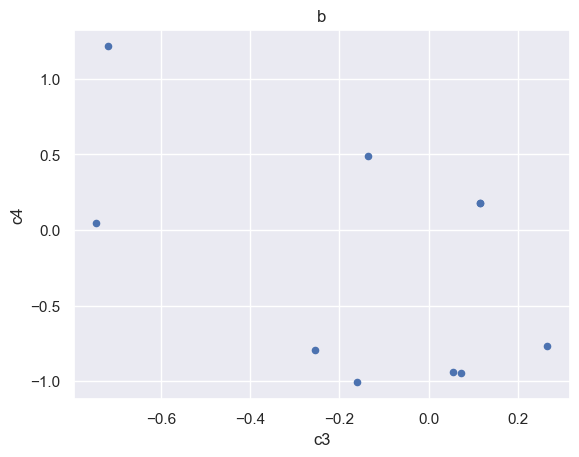

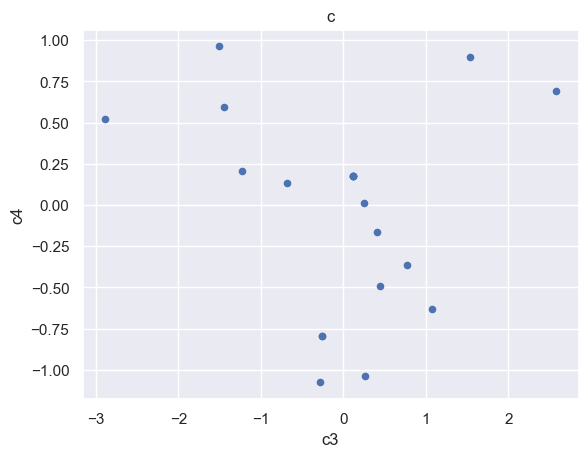

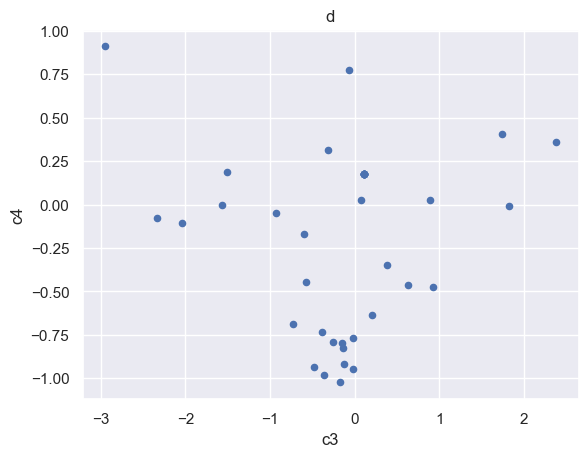

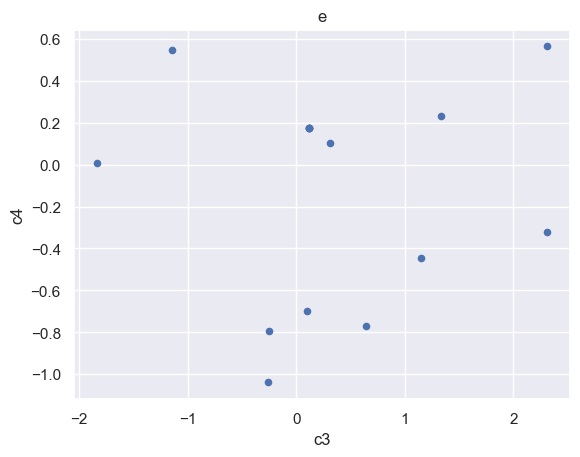

In [351]:
projections = pca.transform(X_sc_samp)
grades = np.array(df.loc[id_code_samp, 'nutrition_grade_fr'])
scores = np.array(list(enumerate(grades)))
scoreidx = pd.DataFrame(scores, columns = ['i', 'score'])

# Création du tableau pour l'exemple
nutriscore = ['a', 'b', 'c', 'd', 'e']

# Boucle for pour parcourir le tableau
for s in nutriscore:
    projectionsdf = pd.DataFrame(projections, columns = ['c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9'])
    scorefiltre = scoreidx.loc[scoreidx['score'] == s]
    idx = scorefiltre.index
    projectionsdf = projectionsdf.loc[idx]
    projectionsfiltre = projectionsdf.loc[(projectionsdf['c3'] <= 3) & (projectionsdf['c3'] >= -3) & (projectionsdf['c4'] >= -3) & (projectionsdf['c4'] <= 3), ['c3', 'c4']]
    projectionsfiltre.plot(x='c3', y='c4', kind='scatter')
    plt.title(s)
    plt.show()


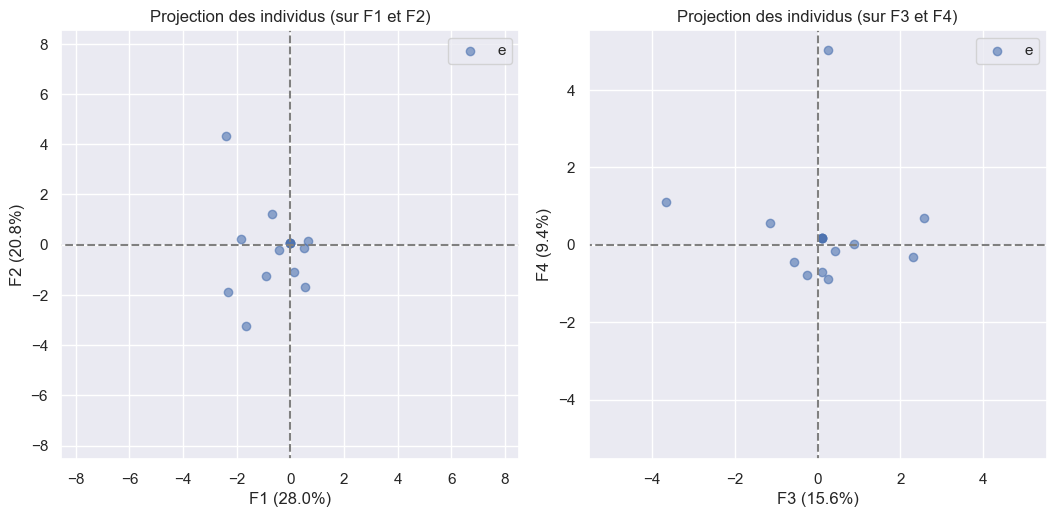

In [352]:
n_comp = 4
# Sélection de 300 échantillons aléatoires
# id_code_samp = pd.Series(id_code).sample(500)
# illus_var_p = df.loc[id_code_samp, 'nutrition_grade_fr']
# illus_var_p = df.loc[id_code_samp['nutrition_grade_fr'] == 'a', 'nutrition_grade_fr']
illus_var_p = df.loc[(df.index.isin(id_code_samp)) & (df["nutrition_grade_fr"] == "e"), "nutrition_grade_fr"]
# print(illus_var_p)

# Filtrer les valeurs 'A' dans la série 'nutrition_grade_fr'
# filtre = (df.loc[id_code_samp, 'nutrition_grade_fr'] == 'A')
# illus_var_p = df.loc[id_code_samp, 'nutrition_grade_fr'][filtre]
# print (id_code_samp)
# # illus_var_p.head()


illus_var_p = illus_var_p[illus_var_p.apply(lambda x: isinstance(x, str))]
display_factorial_planes(pca.transform(X_sc_samp), n_comp, pca, [(0,1),(2,3),(4,5)],
                         n_cols=3, labels=np.array(id_code_samp),
                         illus_var= illus_var_p,
                         lab_on=False, alpha=0.6)

# plt.set_xlim([-5, 5])
# plt.set_xlim([-5, 5])
# # plt.ylim([-5,5])
# print(illus_var_p)
# print(df)
# plt.show()
# plt.figure(figsize = (10,2))
# sns.set(font_scale=1)
# sns.distplot(illus_var_p, bins=50)
# chaine = 'Distribution d individu'
# plt.title(chaine)


### Analyse des composantes
#### Composantes 1
Les variables quantitatives contre-corrélées à cette composantes sont le taux de graisses, de graisses saturées et l'apport calorique. 
Cette composante représente donc l'apport en graisse et l'apport en énergie. 

#### Composantes 2
Les variables quantitatives corrélées à cette composantes sont le taux de sel et de sodium. 
Cette composante représente donc l'apport en sel. 

#### Composantes 3
Les variables quantitatives corrélées à cette composantes sont le taux d'huile de palme et autres additifs. 
Cette composante représente donc les additifs. 

#### Composantes 4
Les variables quantitatives corrélées à cette composantes sont dans un sens le taux de graisses, de graisses saturées et dans l'autre sens, le taux de glucide et de sucre. 
Cette composante représente donc le côté sucré ou salé de l'aliment. 

### Analyse des nutriscores projetés sur les composantes principales
Les aliments se répartissent équitablement sur tous les axes, il n'y a pas de corrélation entre le nutriscore et les apports énergétiques, les taux de graisse, de sel ou de sucre.


###  Regroupement ou Clustering
Les quatre premières CP (Composantes Principales) expliquent 73 % de la variance totale. Nous allons garder ces 4 et essayer de trouver des clusters.

In [354]:
# KMeans Clustering
# Regroupement de KMeans
# Charger les données
df = pd.read_csv('../data/fr.openfoodfacts.org.products_cleaned8.csv')
# --Sélection des caractéristiques et des index (dropna) pour l'ACP
numeric_cols =  [ 'additives_n', 'ingredients_from_palm_oil_n',
             'ingredients_that_may_be_from_palm_oil_n', 'energy_100g', 'fat_100g',
             'saturated-fat_100g', 'carbohydrates_100g', 'sugars_100g', 
             'proteins_100g', 'salt_100g', 'sodium_100g']

# Nombre de clusters
n_clust = 5

# Création d'un objet KMeans avec 5 clusters et entraînement du modèle sur les données projetées X_proj
km = KMeans(n_clusters=n_clust).fit(X_proj)

# Attribution des labels de cluster pour chaque individu
clustK = km.labels_

# Ajout de la colonne 'cluster_Kmeans' dans le DataFrame df pour stocker les labels de cluster pour chaque individu
df.loc[id_code, 'cluster_Kmeans'] = clustK

# Suppression des individus qui n'ont pas de label de cluster dans le DataFrame df
df.dropna(subset=['cluster_Kmeans'], inplace=True)

# Suppression des valeurs manquantes dans les colonnes numériques du DataFrame df
df[numeric_cols].dropna()

# Affichage des labels de clusters uniques
df['cluster_Kmeans'].unique()


array([  3.00,   1.00,   0.00,   4.00,   2.00])

Ce code effectue un clustering KMeans sur un ensemble de données numériques et assigne chaque observation à un cluster. Cela permet de regrouper des observations similaires ensemble en fonction de leurs caractéristiques numériques.

La variable n_clust définit le nombre de clusters souhaité pour l'algorithme de clustering KMeans. Ensuite, la méthode KMeans.fit() est utilisée pour ajuster le modèle KMeans à nos données projetées X_proj. La variable clustK contient les étiquettes de cluster prédites pour chaque observation de X_proj.

En tirant des conclusions sur la taille et la composition de chaque cluster, il est possible d'identifier des groupes de données similaires qui peuvent aider à comprendre les relations et les tendances sous-jacentes dans les données. Cela peut aider à prendre des décisions éclairées et à formuler des stratégies de manière plus efficace en fonction des caractéristiques communes des différents groupes.

In [355]:
## KMeans Clustering

n_clust = 5
km = KMeans(n_clusters=n_clust).fit(X_proj)
clustK = km.labels_
df.loc[id_code, 'cluster_Kmeans'] = clustK

In [357]:
pca_cols = ['additives_n', 'ingredients_from_palm_oil_n',
            'ingredients_that_may_be_from_palm_oil_n', 'energy_100g', 'fat_100g',
            'saturated-fat_100g', 'carbohydrates_100g', 'sugars_100g',
            'proteins_100g', 'salt_100g', 'sodium_100g']

# Filtrer les lignes contenant des valeurs manquantes dans les colonnes d'intérêt
cols = pca_cols + ['cluster_Kmeans']
df_filtered = df[cols].dropna()

# Calculer la matrice de corrélation PPS
pps_corr = pps.matrix(df_filtered).round(2)

# Arrondir les valeurs de la matrice de corrélation à 2 décimales
pps_corr = pps_corr.round(2)

# Afficher le graphique PPS
pps.matrix(df_filtered).pivot(columns='x', index='y', values='ppscore').style.background_gradient(cmap='coolwarm')

# # # Création du DataFrame nettoyé
# df_cleaned = df.dropna(subset=pca_cols, how='any')
# df_cleaned[cols] = df_cleaned[cols].applymap(lambda x: round(x, 2))

# # Calcul de la matrice de ppscore
# pps_corr = pps.matrix(df_cleaned[cols])

# # # Affichage du graphique
# sns.heatmap(pps_corr, cmap='Blues', annot=True)
# plt.title('Sampled Predictive Power Score (ppscore)')
# plt.show()


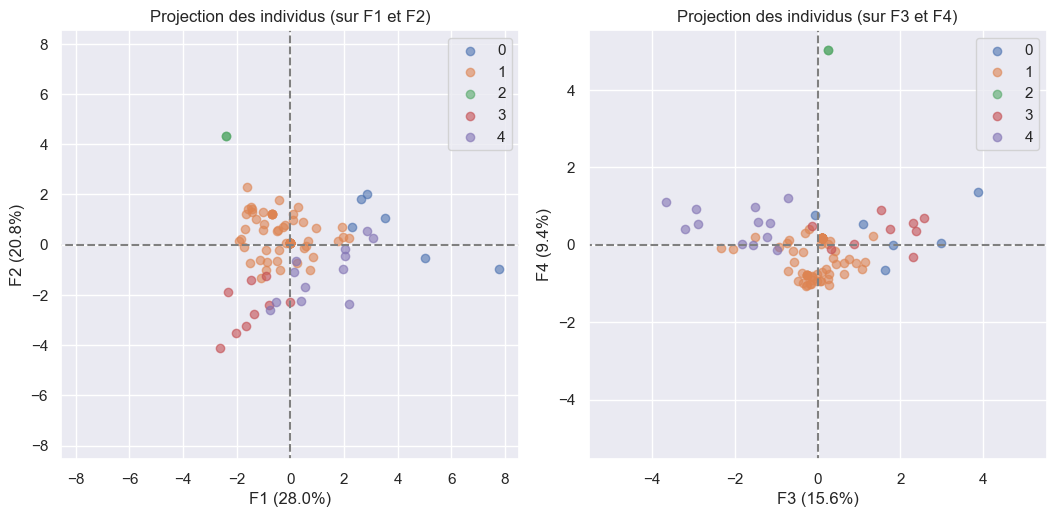

In [358]:
display_factorial_planes(pca.transform(X_sc_samp), n_comp, pca, [(0,1),(2,3),(4,5)],
                         n_cols=3, labels=np.array(id_code_samp),
                         illus_var= df.loc[id_code_samp, 'cluster_Kmeans'],
                         lab_on=False, alpha=0.6)
# 
plt.show()

# QUESTION 4

**Élaborer une idée d’application. Identifier des arguments justifiant la faisabilité (ou non) de l’application à partir des données Open Food Facts.**

Idées : 
* Identifier les caractéristiques nutritionnelles des produits mauvais nutriscores et étiqueter automatiquement les produits qui ont des caractéristiques similaires
* **Calcul automatique de nutriscore**
* Vérifier si le nombre d'additifs est lié au nutriscore / mettre un indicateur sur le nombre d'additifs

In [359]:
data.head(1)

nutrition_grade_fr  nutrition-score-fr_100g  additives_n  \
0  d                  0.0                      0.0           

   ingredients_from_palm_oil_n  ingredients_that_may_be_from_palm_oil_n  \
0  0.0                          0.0                                       

   energy_100g  fat_100g  saturated-fat_100g  carbohydrates_100g  sugars_100g  \
0  100.0        18.27     1.92                63.46               11.54         

   proteins_100g  salt_100g  sodium_100g  
0  13.46          0.0        0.08

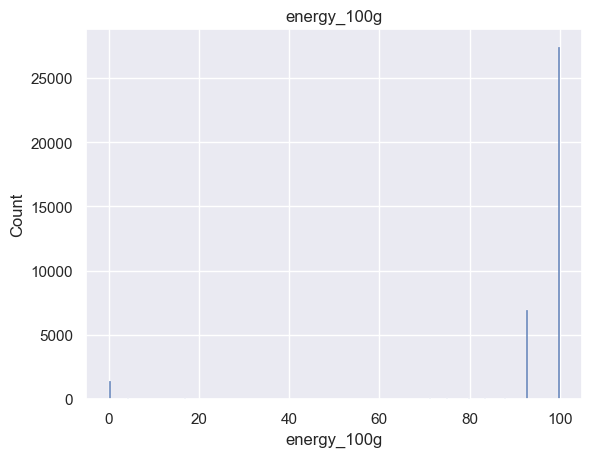

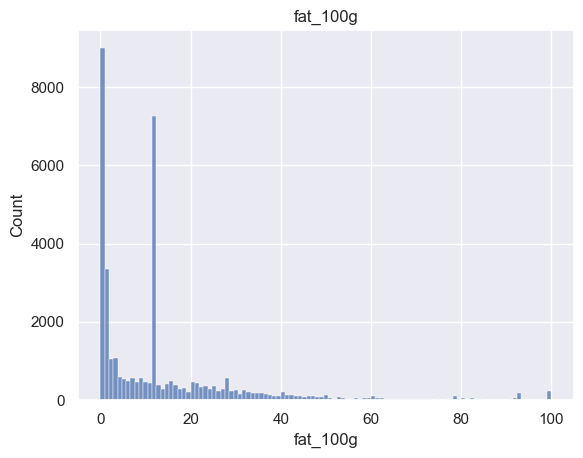

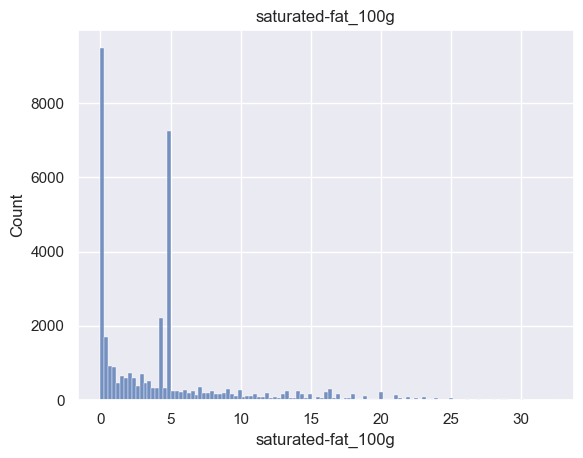

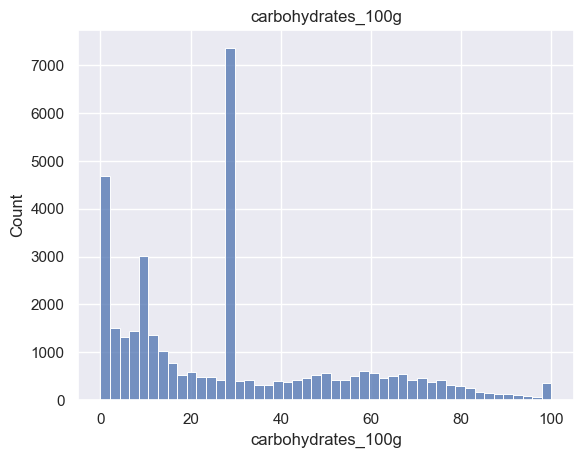

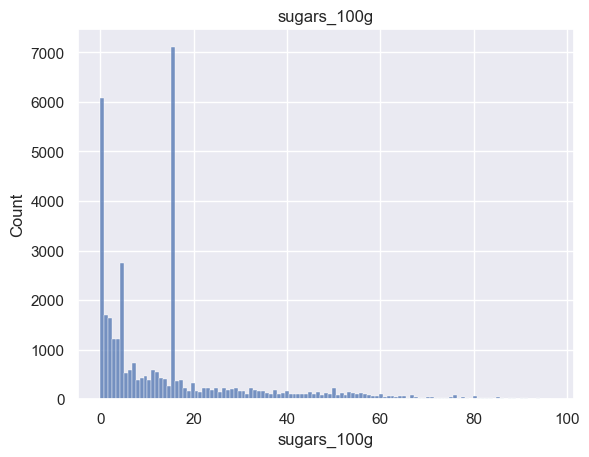

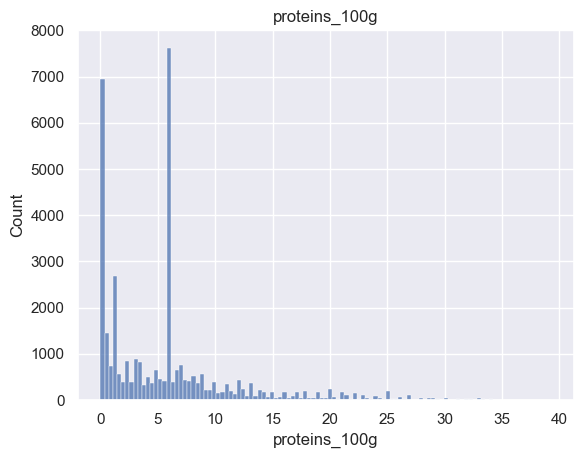

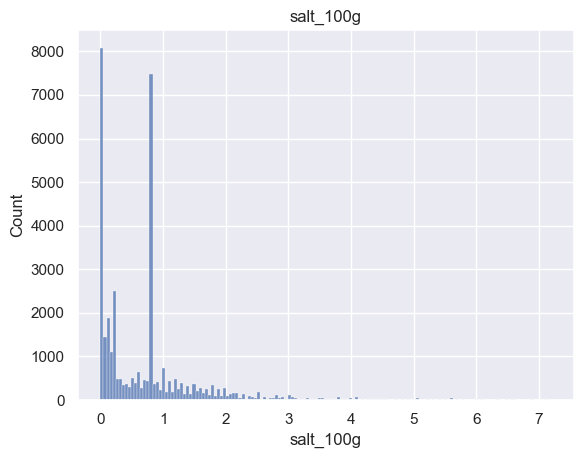

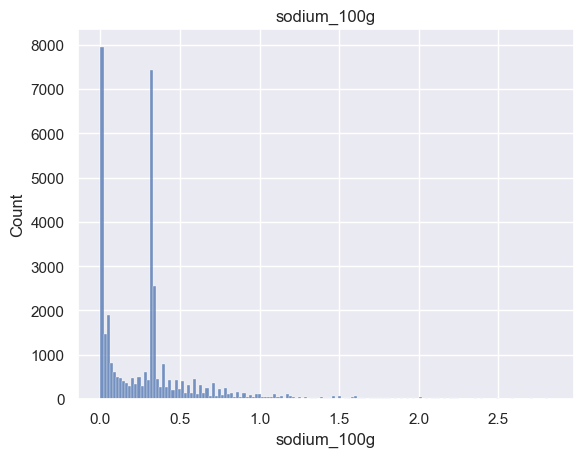

In [362]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Charger les données
data = pd.read_csv('../data/fr.openfoodfacts.org.products_cleaned8.csv')

# Variables pertinentes
variables = ["product_name",  "energy_100g", "fat_100g", "saturated-fat_100g",
             "carbohydrates_100g", "sugars_100g",  "proteins_100g", "salt_100g", "sodium_100g",'nutrition_grade_fr']

# Filtrer les données
filtered_data = data[variables]

# Traiter les valeurs manquantes
filtered_data = filtered_data.dropna()

# Traiter les valeurs aberrantes
for col in filtered_data.columns:
    if col.endswith("_100g"):
        filtered_data = filtered_data[filtered_data[col] >= 0]
        filtered_data = filtered_data[filtered_data[col] <= 100]

# Calcul du Nutri-Score
def compute_nutriscore(row):
    # Calcul des points selon les règles officielles du Nutri-Score 
    score = 0
    energy_points = 0
    saturated_fat_points = 0
    sugars_points = 0
    sodium_points = 0
    fiber_points = 0
    proteins_points = 0
    
    # Points pour l'énergie
    if row["energy_100g"] <= 335:
        energy_points = 0
    elif row["energy_100g"] <= 670:
        energy_points = 1
    elif row["energy_100g"] <= 1005:
        energy_points = 2
    elif row["energy_100g"] <= 1340:
        energy_points = 3
    elif row["energy_100g"] <= 1675:
        energy_points = 4
    else:
        energy_points = 5
        
    # Points pour les acides gras saturés
    if row["saturated-fat_100g"] <= 1:
        saturated_fat_points = 0
    elif row["saturated-fat_100g"] <= 2:
        saturated_fat_points = 1
    elif row["saturated-fat_100g"] <= 3:
        saturated_fat_points = 2
    elif row["saturated-fat_100g"] <= 4:
        saturated_fat_points = 3
    elif row["saturated-fat_100g"] <= 5:
        saturated_fat_points = 4
    else:
        saturated_fat_points = 5
    
    # Points pour les sucres
    if row["sugars_100g"] <= 4.5:
        sugars_points = 0
    elif row["sugars_100g"] <= 9:
        sugars_points = 1
    elif row["sugars_100g"] <= 13.5:
        sugars_points = 2
    elif row["sugars_100g"] <= 18:
        sugars_points = 3
    elif row["sugars_100g"] <= 22.5:
        sugars_points = 4
    else:
        sugars_points = 5
    
    # Points pour le sodium ou sel
    if row["sodium_100g"] <= 90:
        sodium_points = 0
    elif row["sodium_100g"] <= 180:
        sodium_points = 1
    elif row["sodium_100g"] <= 270:
        sodium_points = 2
    elif row["sodium_100g"] <= 360:
        sodium_points = 3
    elif row["sodium_100g"] <= 450:
        sodium_points = 4
    else:
        sodium_points = 5
        
        
    # Points pour les protéines
    if row["proteins_100g"] >= 1.6:
        proteins_points = 0.5 * np.floor((row["proteins_100g"] - 1.6) / 0.8)
        
    # Score final
    score = energy_points + saturated_fat_points + sugars_points + sodium_points - fiber_points - proteins_points
    
    if score <= -1:
        return "A"
    elif score <= 2:
        return "B"
    elif score <= 10:
        return "C"
    elif score <= 18:
        return "D"
    else:
        return "E"

filtered_data["nutriscore_f"] = filtered_data.apply(compute_nutriscore, axis=1)

# Visualisations univariées
for col in filtered_data.columns:
    if col.endswith("_100g"):
        plt.figure()
        sns.histplot(data=filtered_data, x=col)
        plt.title(col)
        plt.show()

# Sauvegarder le résultat
filtered_data.to_csv("nutriscore_data_v3.csv", index=False)

### Random Forest Regressor

Le modèle par régression linéaire ne semble pas donner de bons résultats. Essayons un modèle non linéaire (modèle d'ensemble : Random Forest)

In [233]:
data_reg = df[df['nutrition-score-fr_100g'].isna() == False].select_dtypes(['int32','float64'])

In [234]:
data_reg = data_reg.drop(['fiber_100g','additives_n'], axis=1).dropna(axis=0)

In [246]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


X = data_reg.copy()
y = X['nutrition-score-fr_100g']
X = X.drop(['nutrition-score-fr_100g'],axis=1)


scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state=42)


In [236]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

params = {
    'n_estimators': [50],
    'verbose' : [1]
}

rfr = GridSearchCV(RandomForestRegressor(), params, cv = 5)

In [237]:
rfr.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    2.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    2.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    2.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid={'n_estimators': [50], 'verbose': [1]})

In [238]:
rfr.best_estimator_

RandomForestRegressor(n_estimators=50, verbose=1)

In [271]:

print('R² sur jeu d\'entraînement : ', rfr.best_estimator_.score(X_train,y_train))
print('R² sur jeu de test', rfr.best_estimator_.score(X_test,y_test))


R² sur jeu d'entraînement :  0.975143109676479
R² sur jeu de test 0.8345573198212473


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished


In [241]:
from sklearn.metrics import mean_squared_error,mean_absolute_percentage_error
from math import sqrt
print('RMSE = ', sqrt(mean_squared_error(y_test, rfr.best_estimator_.predict(X_test))))

y_pred_test = rfr.best_estimator_.predict(X_test)
# Calcul du MAP
# map_score = mean_absolute_percentage_error(y_test, y_pred_test)
# print("MAPE:", map_score)

RMSE =  3.3598987137603666


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished


In [272]:
lr = LinearRegression().fit(X_train, y_train)
print('R² sur jeu d\'entraînement : ', lr.score(X_train,y_train))
print('R² sur jeu de test', lr.score(X_test,y_test))
print('Poids de chaque variable dans la régression', lr.coef_)
print('ordonnée à l\'origine', lr.intercept_)


R² sur jeu d'entraînement :  0.654236535301667
R² sur jeu de test 0.6307261634958914
Poids de chaque variable dans la régression [ -0.20   0.07   0.57   1.47   3.85   0.17   3.58  -0.83  74.83 -72.40
  -0.48   1.09]
ordonnée à l'origine 10.416207057289565


In [249]:
from sklearn.metrics import mean_absolute_percentage_error

# Pour Random Forest Regressor
y_pred_rf = rfr.predict(X_test)
mape_rf = mean_absolute_percentage_error(y_test, y_pred_rf)
print("MAPE RF:", mape_rf)

# Pour Régression Linéaire
y_pred_lr = lr.predict(X_test)
mape_lr = mean_absolute_percentage_error(y_test, y_pred_lr)
print("MAPE LR:", mape_lr)

MAPE RF: 1390312803375888.0
MAPE LR: 2933007598081659.0


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished


In [269]:
resultat = pd.DataFrame({'nutriscore_reel' : y_test, 'prediction' : lr.predict(X_test)}).reset_index()

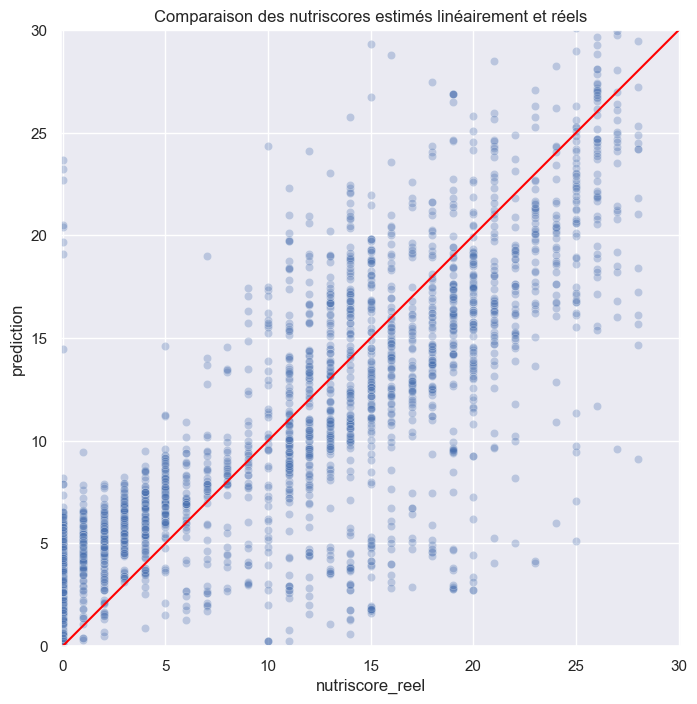

In [270]:
plt.figure(figsize=(8,8))
plt.axis('equal')
plt.title('Comparaison des nutriscores estimés linéairement et réels')
sns.scatterplot(x = resultat['nutriscore_reel'], y = resultat['prediction'], alpha=0.3)
sns.lineplot([0 , 30], [0, 30], color='red')
ax = plt.gca()
ax.set_xlim(0,30)
ax.set_ylim(0,30)
plt.show()

In [274]:
from sklearn.metrics import mean_squared_error
from math import sqrt

print('root mean squared error RMSE: ', sqrt(mean_squared_error(y_true = resultat['nutriscore_reel'], y_pred = resultat['prediction'])))

root mean squared error RMSE:  5.019687444136067


In [259]:
pertinence_variables = pd.DataFrame()

In [260]:
pertinence_variables['coefs'] = lr.coef_.T

In [261]:
pertinence_variables

coefs
0  -0.201276 
1   0.067553 
2   0.570473 
3   1.472018 
4   3.846567 
5   0.168602 
6   3.583302 
7  -0.831343 
8   74.831136
9  -72.404837
10 -0.482152 
11  1.093930

In [262]:
pertinence_variables['colonnes']= data_reg.drop(['nutrition-score-fr_100g'], axis=1).columns.tolist()

In [263]:
pertinence_variables['coefs'] = abs(pertinence_variables['coefs'])

In [264]:
pertinence_variables.sort_values(by='coefs', inplace=True, ascending=False)

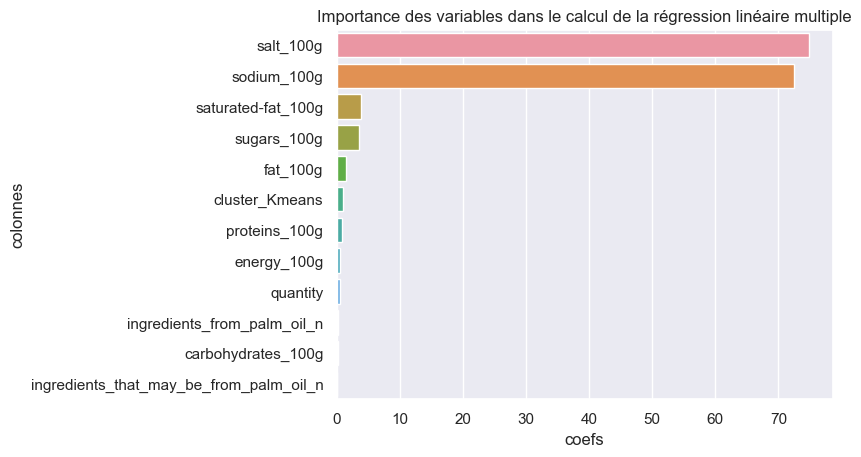

In [265]:
plt.title('Importance des variables dans le calcul de la régression linéaire multiple')
sns.barplot(x = pertinence_variables['coefs'], y =pertinence_variables['colonnes'])
plt.show()

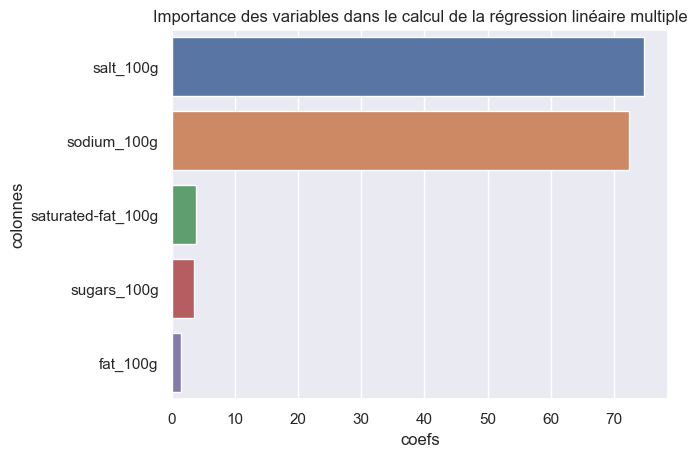

In [266]:
import matplotlib.pyplot as plt
import seaborn as sns

# Trie les variables par ordre décroissant selon les coefficients
pertinence_variables_sorted = pertinence_variables.nlargest(5, 'coefs')

# Crée le graphique à barres
plt.title('Importance des variables dans le calcul de la régression linéaire multiple')
sns.barplot(x=pertinence_variables_sorted['coefs'], y=pertinence_variables_sorted['colonnes'])

# Affiche le graphique
plt.show()


In [250]:
resultat = pd.DataFrame({'nutriscore_reel' : y_test, 'prediction' : lr.predict(X_test)}).reset_index()

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished


(-1.4000000000000001, 29.4, -2.23020729044472, 41.62011883894635)

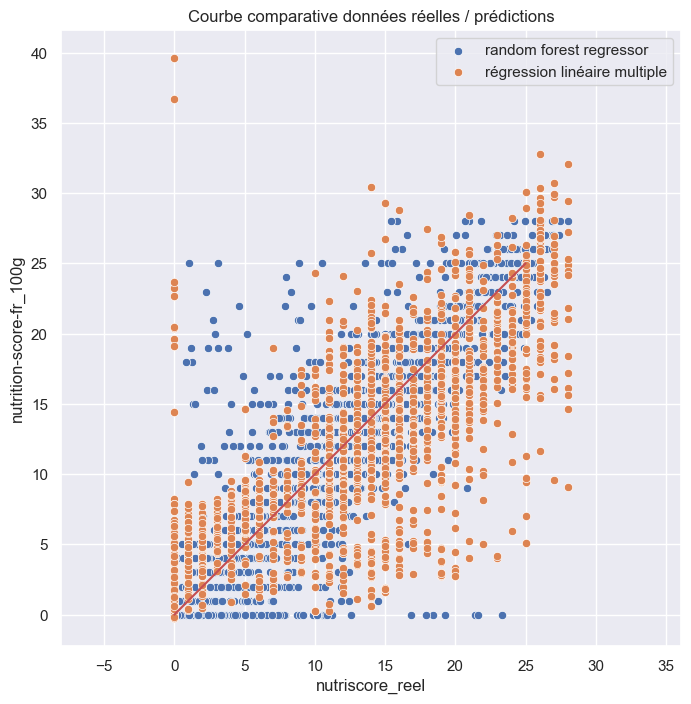

In [251]:

plt.figure(figsize=(8,8))
plt.title('Courbe comparative données réelles / prédictions')
sns.scatterplot(x = rfr.predict(X_test),y = y_test)
sns.scatterplot(x = resultat['nutriscore_reel'], y = resultat['prediction'])
plt.legend(['random forest regressor', 'régression linéaire multiple'])
sns.lineplot([0,25],[0,25], color='r')
ax = plt.gca()
ax.set_xlim(0,25)
ax.set_ylim(0,25)
ax.axis('equal')

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished


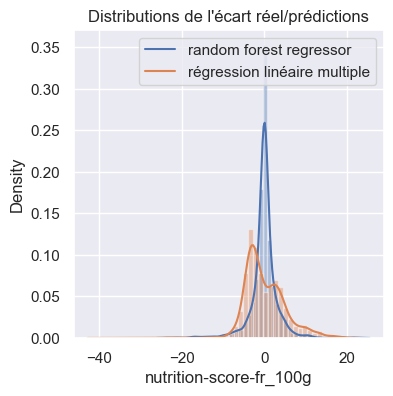

In [268]:
plt.figure(figsize=(4,4))
plt.title('Distributions de l\'écart réel/prédictions')
sns.distplot(rfr.predict(X_test) -  y_test)
sns.distplot(resultat['nutriscore_reel'] - resultat['prediction'])
plt.legend(['random forest regressor', 'régression linéaire multiple'])

In [253]:
rfr.best_estimator_.feature_importances_

array([  0.00,   0.00,   0.01,   0.06,   0.49,   0.02,   0.19,   0.05,
         0.07,   0.10,   0.01,   0.00])

In [254]:
random_forest_features = pd.DataFrame({'feature' : data_reg.drop(['nutrition-score-fr_100g'],axis=1).columns,
                                      'importance' : rfr.best_estimator_.feature_importances_})

In [255]:
random_forest_features.sort_values(by='importance',ascending=False, inplace=True)

<Axes: title={'center': 'Importance des variables dans le random forest'}, xlabel='importance', ylabel='feature'>

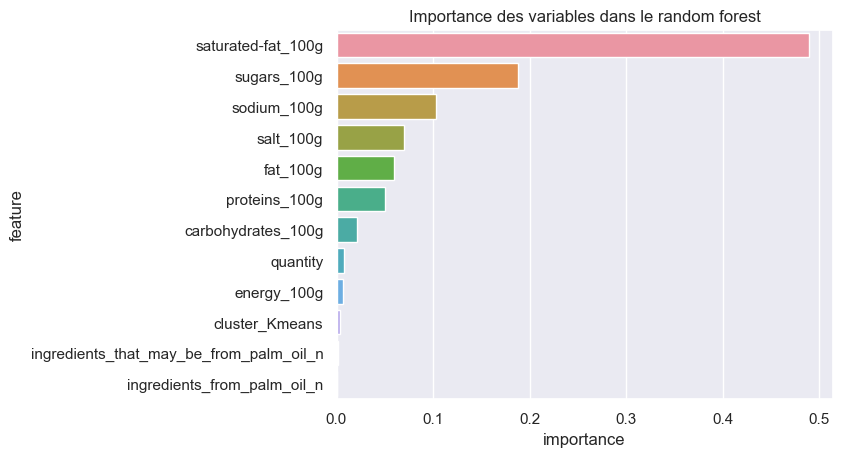

In [256]:
plt.title('Importance des variables dans le random forest')

sns.barplot(y = random_forest_features['feature'], x=random_forest_features['importance'])

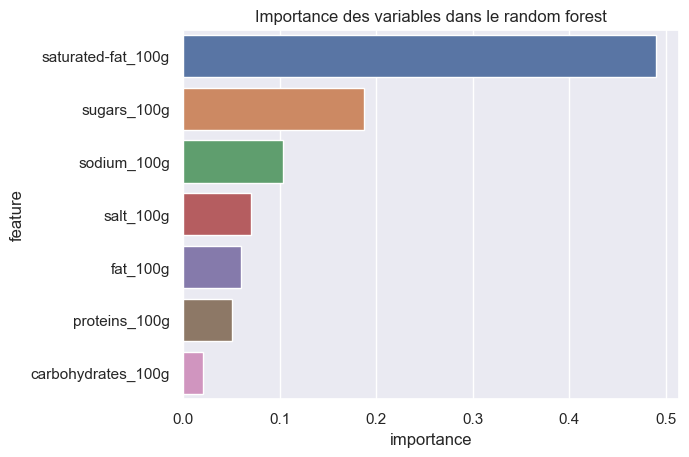

In [267]:
import matplotlib.pyplot as plt
import seaborn as sns

# Trie les variables par ordre décroissant selon l'importance
random_forest_features_sorted = random_forest_features.nlargest(7, 'importance')

# Crée le graphique à barres
plt.title('Importance des variables dans le random forest')
sns.barplot(y=random_forest_features_sorted['feature'], x=random_forest_features_sorted['importance'])

# Affiche le graphique
plt.show()


Graphiquement, on observe assez nettement que le random forest décrit mieux la variance du jeu de données que le modèle par régression linéaire multiple :
* écart quasi nul pour une partie plus importante des données, 
* pour les écarts plus important, la porportion est plus faible que pour la régression linéaire.

# QUESTION 5

**Rédiger un rapport d’exploration et pitcher votre idée durant la soutenance du projet.** : voir support de présentation